# $\textbf{Predicting LFSRs Using Feedforward Neural Networks}$
$\text{Author: Ryan Burns}$

$\text{For background on LFSRs and maximum-length }m\text{-sequences, visit: }\textit{https://en.wikipedia.org/wiki/Linear-feedback_shift_register.}$
$\text{It is assumed that a finite list of primitive polynomial coefficients (stored as hex values) are available for the polynomial degree specified below}$
$\text{via a locally stored file with name <degree>.txt. For degree-10 polynomials, for example, the corresponding primitive polynomial coefficients}$
$\text{would have file name 10.txt. LFSRs are built for each polynomial, each yielding a pseudorandom binary sequence of length/period }2^{\text{degree}}-1.$

### $\textbf{Import Dependencies}$

In [1]:
# System imports
from os import environ
from time import time

# So numpy and Tensorflow can cooperate
environ['KMP_DUPLICATE_LIB_OK']='True'

# Numpy imports
from numpy import array, matmul, transpose, identity, hstack, vstack, shape
from numpy import expand_dims, zeros, correlate, linspace, arange

# Galois / LFSR utilities
from galois_tools import *
from m_sequence_viz import *

# Plotting functionality
from matplotlib import pyplot as plt

# Tensorflow/Keras functionality
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model;
from tensorflow.keras.optimizers import RMSprop;
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives;

### $\textbf{Plotting Macro (Requires IPython)}$

In [2]:
%matplotlib notebook

### $\textbf{Specify LFSR & Neural Net Parameters}$

In [3]:
###########################
# Specify LFSR parameters #
###########################

# Primitive polynomial degree
deg = 10 # (= number of bits)

# Length of m-sequence generated
M = 2**deg - 1 # (bits)

# Initial state of register
seed = 1 # (decimal form)

# Primitive polynomial choice
p = 11 # (index in catalog)

###############################
# Network training parameters #
###############################

# Number of RMSprop training epochs
N_epoch = 16000

# Batch size equal to m-sequence length
N_batch = 2**deg - 1

# Learning rate for RMSprop
learning_rate = 0.001

#########################
# Behavioral parameters #
#########################

# Turn ON/OFF correlation plot
plot_correlations = True

### $\textbf{Load Primitive Polynomial Coefficients of Specified Degree Over }GF(2)$

In [4]:
#############################################################
# Load coeff. of primitive polynomials over GF(2) from file #
#############################################################

# Read list of primitive polynomial coefficients for definition
# of the linear feedback shift registers yielding m-sequences
coeff_catalog = read_polynomials_from_file(deg=deg)

###########################################################
# Generate linear feedback shift registers w/ polynomials #
###########################################################

# Define a bank of LFSRs - 1 per polynomial in the catalog
LFSRs = [LFSR(mask=eval(hex2bin(coeff_catalog[n], nbits=deg)), 
    seed=seed, order=deg, register_id=str(n)) 
    for n in range(len(coeff_catalog))]

### $\textbf{Compute Auto- & Cross-Correlations of Two m-Sequences}$

<IPython.core.display.Javascript object>


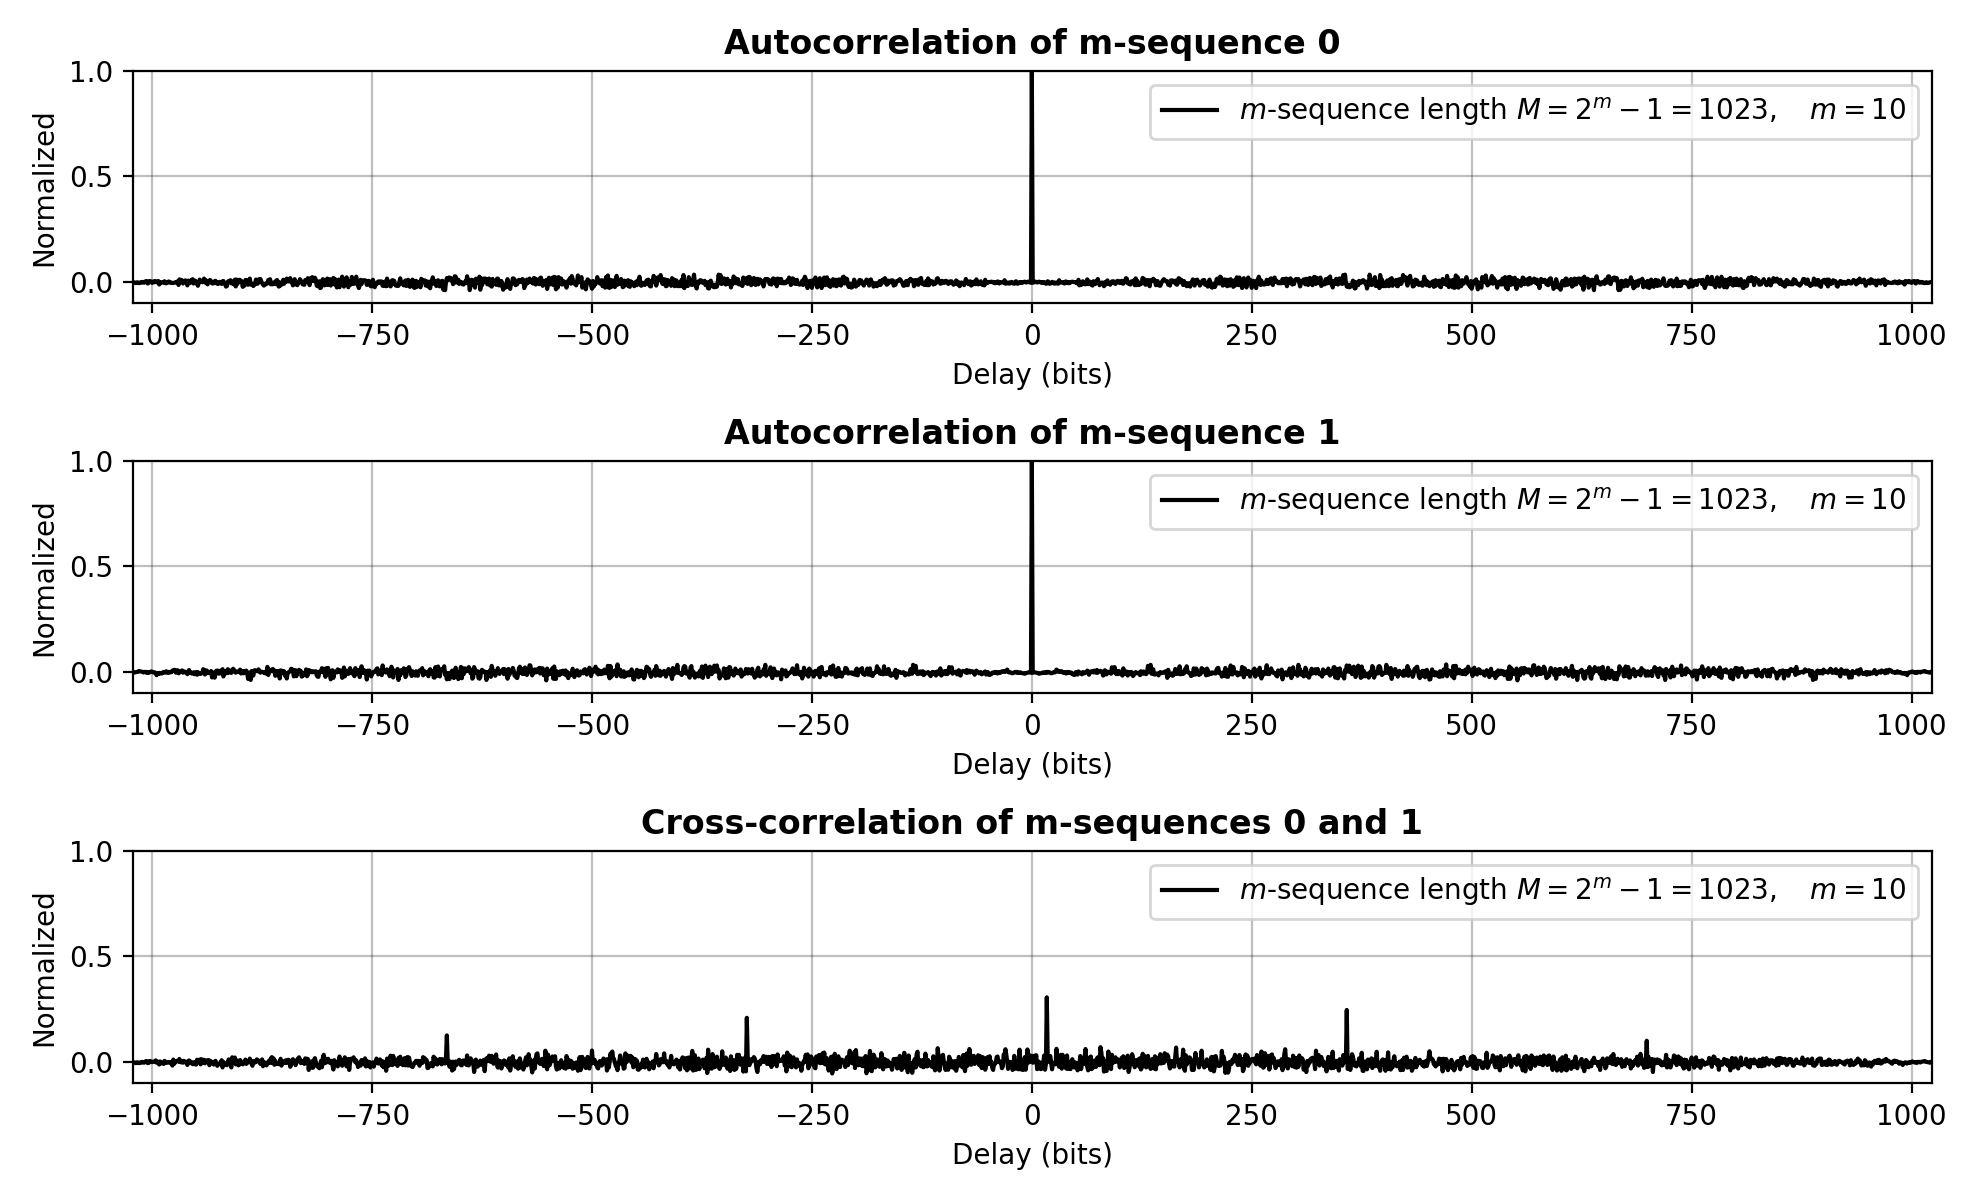

In [5]:
# Optional correlation plot...
if plot_correlations:

    ##################################################
    # Generate m-sequences for each LFSR in the bank #
    ##################################################

    # Maximimum length binary sequences of length M = 2^deg - 1 via LFSRs
    m_sequences = vstack(tuple(register.m_sequence() for register in LFSRs))

    # Convert m-sequences from logical {0,1} to algebraic {-1,+1} representation
    algebraic_m_sequences = m_sequences.astype('float64') * 2 - 1

    ###################################################
    # Visualize correlation properties of m-sequences #
    ###################################################

    # Plot the correlations of the 1st 2 m-sequences generated above
    correlation_example(m_sequence0=algebraic_m_sequences[p,:], 
        m_sequence1=algebraic_m_sequences[p + 1,:],  deg=deg)

### $\textbf{Generate Training Set: 1 Full LFSR Period}$

In [6]:
#########################################################
# Buffer in b[n] a total of 2^deg + deg m-sequence bits #
#########################################################

# Maximimum length binary sequences of length M = 2^deg - 1 via LFSRs
b = vstack(tuple(register.stream(2**deg + deg) for register in LFSRs))

########################################################
# n'th LFSR register state observations, n = 0,1,2,... #
########################################################

# Input LFSR windows (deg-bit observation vectors)
X = array([b[p,n:(n + deg)] for n in range(b.shape[1] - deg - 1)])

############################################################
# (n+1)'st LFSR register state observations, n = 0,1,2,... #
############################################################

# Target LFSR windows, 1 epoch into future from X
Y = array([b[p,(n + 1):(1 + n + deg)] for n in range(b.shape[1] - deg - 1)])

### $\textbf{Define Feedforward Binary Neural Network}$

In [38]:
###############################################################################
# Binary feedforward neural network approximating an LFSR of specified degree #
###############################################################################

def feedforward_lfsr_predictor(deg, learning_rate, print_summary=True):
    """
    DESCRIPTION:
    Use Keras to generate dense (fully-connected) feedforward neural network
    for prediction of the (n + 1)'st LFSR state from the n'th LFSR state. This
    function receives the degree of the feedback polynomial defining the LFSR
    taps, the learning rate of the RMSprop optimizer, and a boolean switch
    controlling whether a model digest/summary is printed. The model has three
    layers, an input layer, a hidden sigmoidal layer, and an output sigmoidal
    layer. Metrics tracked: {TP,FP,TN,FN}. Loss: binary cross-entropy error.

    INPUTS & OUTPUTS:
    :param deg: degree of the feedback polynomial defining LFSR
    :type deg: int
    :returns: connected feedforward network approximating LFSR
    :rtype: tensorflow.keras.models.Model
    """
    ##################################################
    # Define feedforward binary network architecture #
    ##################################################

    # Input layer (LFSR @epoch n)
    x = Input(shape=(deg,), name='input')

    # Single hidden layer, sigmoid activations
    h = Dense(2 * deg, activation='sigmoid', use_bias=False, name='hidden')(x)

    # Output layer (LFSR @epoch n + 1), sigmoid activations
    y = Dense(deg, activation='sigmoid', use_bias=False, name='output')(h)

    # Neural network model
    model = Model(x, y)

    ###################################
    # Compile model, set up optimizer #
    ###################################

    # Use RMSprop for speed of convergence
    opt = RMSprop(learning_rate=learning_rate, epsilon=1e-07)

    # Model compilation using binary cross-entropy error
    model.compile(loss='binary_crossentropy', optimizer=opt,
        metrics=[TruePositives(), TrueNegatives(),
            FalsePositives(), FalseNegatives()])

    ##################################
    # Print model summary (optional) #
    ##################################

    # Print summary?....
    if print_summary:

        # Print model digest
        model.summary()

    # Return the compiled model
    return model

# Use Keras to define feedforward binary neural network
model = feedforward_lfsr_predictor(deg=deg, 
    learning_rate=learning_rate, print_summary=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
hidden (Dense)               (None, 20)                200       
_________________________________________________________________
output (Dense)               (None, 10)                200       
Total params: 400
Trainable params: 400
Non-trainable params: 0
_________________________________________________________________


### $\textbf{Fit Sigmoid Model to Predict Register State }n + 1\textbf{ from State }n$

In [8]:
# Model training
model.fit(
    
    # Input dataset
    x=X, # state vectot "observation" bits
    y=Y, # future-state predicted bits
    
    # Batch size
    batch_size=N_batch,
    
    # Number of training epochs
    epochs=N_epoch,
    
    # Print progress
    verbose=1,
    
    # Set aside fraction for validation
    validation_split=0, # (use everything)
    
    # False for time series
    shuffle=False,
    
    # Parallelize job across 2 workers
    workers=1,
    use_multiprocessing=False);

Train on 1023 samples
Epoch 1/16000
1023/1023 [==============================] - 1s 1ms/sample - loss: 0.7583 - true_positives: 3110.0000 - true_negatives: 2038.0000 - false_positives: 3072.0000 - false_negatives: 2010.0000
Epoch 2/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.7527 - true_positives: 3150.0000 - true_negatives: 2021.0000 - false_positives: 3089.0000 - false_negatives: 1970.0000
Epoch 3/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.7489 - true_positives: 3180.0000 - true_negatives: 1998.0000 - false_positives: 3112.0000 - false_negatives: 1940.0000
Epoch 4/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.7459 - true_positives: 3202.0000 - true_negatives: 1984.0000 - false_positives: 3126.0000 - false_negatives: 1918.0000
Epoch 5/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.7433 - true_positives: 3217.0000 - true_negatives: 1978.0000 - false_positives: 3132.00

Epoch 42/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6999 - true_positives: 3558.0000 - true_negatives: 2042.0000 - false_positives: 3068.0000 - false_negatives: 1562.0000
Epoch 43/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6991 - true_positives: 3561.0000 - true_negatives: 2053.0000 - false_positives: 3057.0000 - false_negatives: 1559.0000
Epoch 44/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6983 - true_positives: 3558.0000 - true_negatives: 2063.0000 - false_positives: 3047.0000 - false_negatives: 1562.0000
Epoch 45/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6975 - true_positives: 3568.0000 - true_negatives: 2080.0000 - false_positives: 3030.0000 - false_negatives: 1552.0000
Epoch 46/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6968 - true_positives: 3564.0000 - true_negatives: 2093.0000 - false_positives: 3017.0000 - false_negati

Epoch 83/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6736 - true_positives: 3607.0000 - true_negatives: 2660.0000 - false_positives: 2450.0000 - false_negatives: 1513.0000
Epoch 84/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6730 - true_positives: 3611.0000 - true_negatives: 2684.0000 - false_positives: 2426.0000 - false_negatives: 1509.0000
Epoch 85/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6725 - true_positives: 3616.0000 - true_negatives: 2696.0000 - false_positives: 2414.0000 - false_negatives: 1504.0000
Epoch 86/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6720 - true_positives: 3623.0000 - true_negatives: 2709.0000 - false_positives: 2401.0000 - false_negatives: 1497.0000
Epoch 87/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6715 - true_positives: 3627.0000 - true_negatives: 2719.0000 - false_positives: 2391.0000 - false_negati

Epoch 124/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6536 - true_positives: 3710.0000 - true_negatives: 3557.0000 - false_positives: 1553.0000 - false_negatives: 1410.0000
Epoch 125/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6531 - true_positives: 3719.0000 - true_negatives: 3579.0000 - false_positives: 1531.0000 - false_negatives: 1401.0000
Epoch 126/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6527 - true_positives: 3718.0000 - true_negatives: 3606.0000 - false_positives: 1504.0000 - false_negatives: 1402.0000
Epoch 127/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6522 - true_positives: 3726.0000 - true_negatives: 3621.0000 - false_positives: 1489.0000 - false_negatives: 1394.0000
Epoch 128/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6518 - true_positives: 3729.0000 - true_negatives: 3640.0000 - false_positives: 1470.0000 - false_n

Epoch 165/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6347 - true_positives: 3984.0000 - true_negatives: 4056.0000 - false_positives: 1054.0000 - false_negatives: 1136.0000
Epoch 166/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6342 - true_positives: 3990.0000 - true_negatives: 4065.0000 - false_positives: 1045.0000 - false_negatives: 1130.0000
Epoch 167/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6338 - true_positives: 3994.0000 - true_negatives: 4070.0000 - false_positives: 1040.0000 - false_negatives: 1126.0000
Epoch 168/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6333 - true_positives: 4001.0000 - true_negatives: 4078.0000 - false_positives: 1032.0000 - false_negatives: 1119.0000
Epoch 169/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.6328 - true_positives: 4006.0000 - true_negatives: 4080.0000 - false_positives: 1030.0000 - false_n

Epoch 206/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6153 - true_positives: 4230.0000 - true_negatives: 4231.0000 - false_positives: 879.0000 - false_negatives: 890.0000
Epoch 207/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6148 - true_positives: 4234.0000 - true_negatives: 4233.0000 - false_positives: 877.0000 - false_negatives: 886.0000
Epoch 208/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6143 - true_positives: 4239.0000 - true_negatives: 4236.0000 - false_positives: 874.0000 - false_negatives: 881.0000
Epoch 209/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.6138 - true_positives: 4244.0000 - true_negatives: 4239.0000 - false_positives: 871.0000 - false_negatives: 876.0000
Epoch 210/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.6133 - true_positives: 4247.0000 - true_negatives: 4243.0000 - false_positives: 867.0000 - false_negatives:

Epoch 247/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.5951 - true_positives: 4384.0000 - true_negatives: 4319.0000 - false_positives: 791.0000 - false_negatives: 736.0000
Epoch 248/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5946 - true_positives: 4386.0000 - true_negatives: 4329.0000 - false_positives: 781.0000 - false_negatives: 734.0000
Epoch 249/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5941 - true_positives: 4392.0000 - true_negatives: 4327.0000 - false_positives: 783.0000 - false_negatives: 728.0000
Epoch 250/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5936 - true_positives: 4389.0000 - true_negatives: 4334.0000 - false_positives: 776.0000 - false_negatives: 731.0000
Epoch 251/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5931 - true_positives: 4398.0000 - true_negatives: 4331.0000 - false_positives: 779.0000 - false_negatives:

Epoch 288/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5741 - true_positives: 4486.0000 - true_negatives: 4407.0000 - false_positives: 703.0000 - false_negatives: 634.0000
Epoch 289/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5736 - true_positives: 4497.0000 - true_negatives: 4401.0000 - false_positives: 709.0000 - false_negatives: 623.0000
Epoch 290/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5730 - true_positives: 4486.0000 - true_negatives: 4415.0000 - false_positives: 695.0000 - false_negatives: 634.0000
Epoch 291/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5725 - true_positives: 4503.0000 - true_negatives: 4405.0000 - false_positives: 705.0000 - false_negatives: 617.0000
Epoch 292/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5720 - true_positives: 4489.0000 - true_negatives: 4418.0000 - false_positives: 692.0000 - false_negatives:

Epoch 329/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5524 - true_positives: 4560.0000 - true_negatives: 4459.0000 - false_positives: 651.0000 - false_negatives: 560.0000
Epoch 330/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.5519 - true_positives: 4536.0000 - true_negatives: 4479.0000 - false_positives: 631.0000 - false_negatives: 584.0000
Epoch 331/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5514 - true_positives: 4560.0000 - true_negatives: 4465.0000 - false_positives: 645.0000 - false_negatives: 560.0000
Epoch 332/16000
1023/1023 [==============================] - 0s 95us/sample - loss: 0.5508 - true_positives: 4537.0000 - true_negatives: 4485.0000 - false_positives: 625.0000 - false_negatives: 583.0000
Epoch 333/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.5503 - true_positives: 4563.0000 - true_negatives: 4470.0000 - false_positives: 640.0000 - false_negatives

Epoch 370/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5303 - true_positives: 4598.0000 - true_negatives: 4534.0000 - false_positives: 576.0000 - false_negatives: 522.0000
Epoch 371/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5298 - true_positives: 4624.0000 - true_negatives: 4508.0000 - false_positives: 602.0000 - false_negatives: 496.0000
Epoch 372/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5292 - true_positives: 4599.0000 - true_negatives: 4538.0000 - false_positives: 572.0000 - false_negatives: 521.0000
Epoch 373/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5287 - true_positives: 4625.0000 - true_negatives: 4510.0000 - false_positives: 600.0000 - false_negatives: 495.0000
Epoch 374/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5281 - true_positives: 4602.0000 - true_negatives: 4541.0000 - false_positives: 569.0000 - false_negatives:

Epoch 411/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5079 - true_positives: 4660.0000 - true_negatives: 4543.0000 - false_positives: 567.0000 - false_negatives: 460.0000
Epoch 412/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5073 - true_positives: 4631.0000 - true_negatives: 4578.0000 - false_positives: 532.0000 - false_negatives: 489.0000
Epoch 413/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5068 - true_positives: 4661.0000 - true_negatives: 4545.0000 - false_positives: 565.0000 - false_negatives: 459.0000
Epoch 414/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.5062 - true_positives: 4634.0000 - true_negatives: 4581.0000 - false_positives: 529.0000 - false_negatives: 486.0000
Epoch 415/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.5057 - true_positives: 4664.0000 - true_negatives: 4547.0000 - false_positives: 563.0000 - false_negatives:

Epoch 452/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4854 - true_positives: 4647.0000 - true_negatives: 4604.0000 - false_positives: 506.0000 - false_negatives: 473.0000
Epoch 453/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4848 - true_positives: 4682.0000 - true_negatives: 4557.0000 - false_positives: 553.0000 - false_negatives: 438.0000
Epoch 454/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4843 - true_positives: 4647.0000 - true_negatives: 4603.0000 - false_positives: 507.0000 - false_negatives: 473.0000
Epoch 455/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4837 - true_positives: 4685.0000 - true_negatives: 4558.0000 - false_positives: 552.0000 - false_negatives: 435.0000
Epoch 456/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4832 - true_positives: 4648.0000 - true_negatives: 4603.0000 - false_positives: 507.0000 - false_negatives:

Epoch 493/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4630 - true_positives: 4738.0000 - true_negatives: 4571.0000 - false_positives: 539.0000 - false_negatives: 382.0000
Epoch 494/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4625 - true_positives: 4680.0000 - true_negatives: 4634.0000 - false_positives: 476.0000 - false_negatives: 440.0000
Epoch 495/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4620 - true_positives: 4739.0000 - true_negatives: 4575.0000 - false_positives: 535.0000 - false_negatives: 381.0000
Epoch 496/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4614 - true_positives: 4682.0000 - true_negatives: 4634.0000 - false_positives: 476.0000 - false_negatives: 438.0000
Epoch 497/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4609 - true_positives: 4745.0000 - true_negatives: 4576.0000 - false_positives: 534.0000 - false_negatives:

Epoch 534/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4411 - true_positives: 4707.0000 - true_negatives: 4657.0000 - false_positives: 453.0000 - false_negatives: 413.0000
Epoch 535/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4406 - true_positives: 4789.0000 - true_negatives: 4579.0000 - false_positives: 531.0000 - false_negatives: 331.0000
Epoch 536/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.4400 - true_positives: 4707.0000 - true_negatives: 4660.0000 - false_positives: 450.0000 - false_negatives: 413.0000
Epoch 537/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.4395 - true_positives: 4793.0000 - true_negatives: 4578.0000 - false_positives: 532.0000 - false_negatives: 327.0000
Epoch 538/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4390 - true_positives: 4706.0000 - true_negatives: 4659.0000 - false_positives: 451.0000 - false_negatives:

Epoch 575/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4197 - true_positives: 4825.0000 - true_negatives: 4574.0000 - false_positives: 536.0000 - false_negatives: 295.0000
Epoch 576/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4191 - true_positives: 4730.0000 - true_negatives: 4684.0000 - false_positives: 426.0000 - false_negatives: 390.0000
Epoch 577/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.4186 - true_positives: 4826.0000 - true_negatives: 4574.0000 - false_positives: 536.0000 - false_negatives: 294.0000
Epoch 578/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4181 - true_positives: 4730.0000 - true_negatives: 4685.0000 - false_positives: 425.0000 - false_negatives: 390.0000
Epoch 579/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.4176 - true_positives: 4826.0000 - true_negatives: 4574.0000 - false_positives: 536.0000 - false_negatives:

Epoch 616/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3989 - true_positives: 4742.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negatives: 378.0000
Epoch 617/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3984 - true_positives: 4861.0000 - true_negatives: 4576.0000 - false_positives: 534.0000 - false_negatives: 259.0000
Epoch 618/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3979 - true_positives: 4743.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negatives: 377.0000
Epoch 619/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3974 - true_positives: 4863.0000 - true_negatives: 4579.0000 - false_positives: 531.0000 - false_negatives: 257.0000
Epoch 620/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3969 - true_positives: 4743.0000 - true_negatives: 4707.0000 - false_positives: 403.0000 - false_negatives:

Epoch 657/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3789 - true_positives: 4881.0000 - true_negatives: 4597.0000 - false_positives: 513.0000 - false_negatives: 239.0000
Epoch 658/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3785 - true_positives: 4748.0000 - true_negatives: 4722.0000 - false_positives: 388.0000 - false_negatives: 372.0000
Epoch 659/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3780 - true_positives: 4885.0000 - true_negatives: 4598.0000 - false_positives: 512.0000 - false_negatives: 235.0000
Epoch 660/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3775 - true_positives: 4750.0000 - true_negatives: 4723.0000 - false_positives: 387.0000 - false_negatives: 370.0000
Epoch 661/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3770 - true_positives: 4886.0000 - true_negatives: 4598.0000 - false_positives: 512.0000 - false_negatives:

Epoch 698/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3598 - true_positives: 4779.0000 - true_negatives: 4748.0000 - false_positives: 362.0000 - false_negatives: 341.0000
Epoch 699/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3593 - true_positives: 4907.0000 - true_negatives: 4620.0000 - false_positives: 490.0000 - false_negatives: 213.0000
Epoch 700/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3588 - true_positives: 4780.0000 - true_negatives: 4755.0000 - false_positives: 355.0000 - false_negatives: 340.0000
Epoch 701/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3584 - true_positives: 4906.0000 - true_negatives: 4626.0000 - false_positives: 484.0000 - false_negatives: 214.0000
Epoch 702/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3579 - true_positives: 4782.0000 - true_negatives: 4757.0000 - false_positives: 353.0000 - false_negatives:

Epoch 739/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3413 - true_positives: 4914.0000 - true_negatives: 4652.0000 - false_positives: 458.0000 - false_negatives: 206.0000
Epoch 740/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3409 - true_positives: 4807.0000 - true_negatives: 4781.0000 - false_positives: 329.0000 - false_negatives: 313.0000
Epoch 741/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3404 - true_positives: 4916.0000 - true_negatives: 4656.0000 - false_positives: 454.0000 - false_negatives: 204.0000
Epoch 742/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3400 - true_positives: 4809.0000 - true_negatives: 4784.0000 - false_positives: 326.0000 - false_negatives: 311.0000
Epoch 743/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3396 - true_positives: 4916.0000 - true_negatives: 4660.0000 - false_positives: 450.0000 - false_negatives:

Epoch 780/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3236 - true_positives: 4820.0000 - true_negatives: 4810.0000 - false_positives: 300.0000 - false_negatives: 300.0000
Epoch 781/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3232 - true_positives: 4927.0000 - true_negatives: 4687.0000 - false_positives: 423.0000 - false_negatives: 193.0000
Epoch 782/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3228 - true_positives: 4820.0000 - true_negatives: 4810.0000 - false_positives: 300.0000 - false_negatives: 300.0000
Epoch 783/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3224 - true_positives: 4927.0000 - true_negatives: 4689.0000 - false_positives: 421.0000 - false_negatives: 193.0000
Epoch 784/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.3219 - true_positives: 4823.0000 - true_negatives: 4810.0000 - false_positives: 300.0000 - false_negatives:

Epoch 821/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3067 - true_positives: 4931.0000 - true_negatives: 4707.0000 - false_positives: 403.0000 - false_negatives: 189.0000
Epoch 822/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3063 - true_positives: 4829.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 291.0000
Epoch 823/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3059 - true_positives: 4931.0000 - true_negatives: 4712.0000 - false_positives: 398.0000 - false_negatives: 189.0000
Epoch 824/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3055 - true_positives: 4829.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 291.0000
Epoch 825/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.3051 - true_positives: 4931.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negatives:

Epoch 862/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2906 - true_positives: 4835.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 285.0000
Epoch 863/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2903 - true_positives: 4933.0000 - true_negatives: 4729.0000 - false_positives: 381.0000 - false_negatives: 187.0000
Epoch 864/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2899 - true_positives: 4835.0000 - true_negatives: 4844.0000 - false_positives: 266.0000 - false_negatives: 285.0000
Epoch 865/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2895 - true_positives: 4934.0000 - true_negatives: 4729.0000 - false_positives: 381.0000 - false_negatives: 186.0000
Epoch 866/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2891 - true_positives: 4836.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives:

Epoch 903/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.2754 - true_positives: 4934.0000 - true_negatives: 4742.0000 - false_positives: 368.0000 - false_negatives: 186.0000
Epoch 904/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2750 - true_positives: 4840.0000 - true_negatives: 4854.0000 - false_positives: 256.0000 - false_negatives: 280.0000
Epoch 905/16000
1023/1023 [==============================] - 0s 9us/sample - loss: 0.2747 - true_positives: 4933.0000 - true_negatives: 4742.0000 - false_positives: 368.0000 - false_negatives: 187.0000
Epoch 906/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2743 - true_positives: 4840.0000 - true_negatives: 4853.0000 - false_positives: 257.0000 - false_negatives: 280.0000
Epoch 907/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2740 - true_positives: 4933.0000 - true_negatives: 4743.0000 - false_positives: 367.0000 - false_negatives:

Epoch 944/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2610 - true_positives: 4846.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negatives: 274.0000
Epoch 945/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2607 - true_positives: 4936.0000 - true_negatives: 4752.0000 - false_positives: 358.0000 - false_negatives: 184.0000
Epoch 946/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2604 - true_positives: 4845.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negatives: 275.0000
Epoch 947/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2600 - true_positives: 4937.0000 - true_negatives: 4753.0000 - false_positives: 357.0000 - false_negatives: 183.0000
Epoch 948/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2597 - true_positives: 4846.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negatives:

Epoch 985/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2476 - true_positives: 4933.0000 - true_negatives: 4764.0000 - false_positives: 346.0000 - false_negatives: 187.0000
Epoch 986/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2473 - true_positives: 4851.0000 - true_negatives: 4857.0000 - false_positives: 253.0000 - false_negatives: 269.0000
Epoch 987/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2469 - true_positives: 4933.0000 - true_negatives: 4764.0000 - false_positives: 346.0000 - false_negatives: 187.0000
Epoch 988/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2466 - true_positives: 4851.0000 - true_negatives: 4857.0000 - false_positives: 253.0000 - false_negatives: 269.0000
Epoch 989/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2463 - true_positives: 4933.0000 - true_negatives: 4764.0000 - false_positives: 346.0000 - false_negatives:

Epoch 1026/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2350 - true_positives: 4856.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 264.0000
Epoch 1027/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2347 - true_positives: 4928.0000 - true_negatives: 4777.0000 - false_positives: 333.0000 - false_negatives: 192.0000
Epoch 1028/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2344 - true_positives: 4855.0000 - true_negatives: 4859.0000 - false_positives: 251.0000 - false_negatives: 265.0000
Epoch 1029/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2341 - true_positives: 4928.0000 - true_negatives: 4777.0000 - false_positives: 333.0000 - false_negatives: 192.0000
Epoch 1030/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2338 - true_positives: 4854.0000 - true_negatives: 4860.0000 - false_positives: 250.0000 - false_negat

Epoch 1067/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2233 - true_positives: 4927.0000 - true_negatives: 4785.0000 - false_positives: 325.0000 - false_negatives: 193.0000
Epoch 1068/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2230 - true_positives: 4850.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 270.0000
Epoch 1069/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2227 - true_positives: 4926.0000 - true_negatives: 4784.0000 - false_positives: 326.0000 - false_negatives: 194.0000
Epoch 1070/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.2224 - true_positives: 4850.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 270.0000
Epoch 1071/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.2222 - true_positives: 4926.0000 - true_negatives: 4785.0000 - false_positives: 325.0000 - false_negat

Epoch 1108/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2123 - true_positives: 4847.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 273.0000
Epoch 1109/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2121 - true_positives: 4930.0000 - true_negatives: 4789.0000 - false_positives: 321.0000 - false_negatives: 190.0000
Epoch 1110/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.2118 - true_positives: 4847.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 273.0000
Epoch 1111/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2116 - true_positives: 4930.0000 - true_negatives: 4789.0000 - false_positives: 321.0000 - false_negatives: 190.0000
Epoch 1112/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.2113 - true_positives: 4847.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negat

Epoch 1149/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2022 - true_positives: 4930.0000 - true_negatives: 4787.0000 - false_positives: 323.0000 - false_negatives: 190.0000
Epoch 1150/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.2019 - true_positives: 4844.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 276.0000
Epoch 1151/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.2017 - true_positives: 4931.0000 - true_negatives: 4787.0000 - false_positives: 323.0000 - false_negatives: 189.0000
Epoch 1152/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.2015 - true_positives: 4844.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 276.0000
Epoch 1153/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.2012 - true_positives: 4931.0000 - true_negatives: 4787.0000 - false_positives: 323.0000 - false_negat

Epoch 1190/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1927 - true_positives: 4845.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 275.0000
Epoch 1191/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1925 - true_positives: 4929.0000 - true_negatives: 4783.0000 - false_positives: 327.0000 - false_negatives: 191.0000
Epoch 1192/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1923 - true_positives: 4845.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negatives: 275.0000
Epoch 1193/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1921 - true_positives: 4929.0000 - true_negatives: 4783.0000 - false_positives: 327.0000 - false_negatives: 191.0000
Epoch 1194/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1918 - true_positives: 4845.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negat

Epoch 1231/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1839 - true_positives: 4931.0000 - true_negatives: 4787.0000 - false_positives: 323.0000 - false_negatives: 189.0000
Epoch 1232/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1837 - true_positives: 4849.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 271.0000
Epoch 1233/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1835 - true_positives: 4932.0000 - true_negatives: 4787.0000 - false_positives: 323.0000 - false_negatives: 188.0000
Epoch 1234/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1833 - true_positives: 4849.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 271.0000
Epoch 1235/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1831 - true_positives: 4933.0000 - true_negatives: 4787.0000 - false_positives: 323.0000 - false_negat

Epoch 1272/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1758 - true_positives: 4851.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 269.0000
Epoch 1273/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1756 - true_positives: 4930.0000 - true_negatives: 4788.0000 - false_positives: 322.0000 - false_negatives: 190.0000
Epoch 1274/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1754 - true_positives: 4851.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 269.0000
Epoch 1275/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1752 - true_positives: 4930.0000 - true_negatives: 4788.0000 - false_positives: 322.0000 - false_negatives: 190.0000
Epoch 1276/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1751 - true_positives: 4852.0000 - true_negatives: 4868.0000 - false_positives: 242.0000 - false_negat

Epoch 1313/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1683 - true_positives: 4932.0000 - true_negatives: 4789.0000 - false_positives: 321.0000 - false_negatives: 188.0000
Epoch 1314/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1681 - true_positives: 4851.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 269.0000
Epoch 1315/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1680 - true_positives: 4932.0000 - true_negatives: 4789.0000 - false_positives: 321.0000 - false_negatives: 188.0000
Epoch 1316/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1678 - true_positives: 4850.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 270.0000
Epoch 1317/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1676 - true_positives: 4932.0000 - true_negatives: 4789.0000 - false_positives: 321.0000 - false_negat

Epoch 1354/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1614 - true_positives: 4852.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 268.0000
Epoch 1355/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1612 - true_positives: 4931.0000 - true_negatives: 4786.0000 - false_positives: 324.0000 - false_negatives: 189.0000
Epoch 1356/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1611 - true_positives: 4853.0000 - true_negatives: 4867.0000 - false_positives: 243.0000 - false_negatives: 267.0000
Epoch 1357/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1609 - true_positives: 4930.0000 - true_negatives: 4786.0000 - false_positives: 324.0000 - false_negatives: 190.0000
Epoch 1358/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1608 - true_positives: 4853.0000 - true_negatives: 4866.0000 - false_positives: 244.0000 - false_negat

Epoch 1395/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1550 - true_positives: 4931.0000 - true_negatives: 4787.0000 - false_positives: 323.0000 - false_negatives: 189.0000
Epoch 1396/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1549 - true_positives: 4850.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 270.0000
Epoch 1397/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1547 - true_positives: 4931.0000 - true_negatives: 4787.0000 - false_positives: 323.0000 - false_negatives: 189.0000
Epoch 1398/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1546 - true_positives: 4850.0000 - true_negatives: 4870.0000 - false_positives: 240.0000 - false_negatives: 270.0000
Epoch 1399/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1544 - true_positives: 4931.0000 - true_negatives: 4787.0000 - false_positives: 323.0000 - false_negat

Epoch 1436/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.1492 - true_positives: 4844.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 276.0000
Epoch 1437/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1490 - true_positives: 4932.0000 - true_negatives: 4786.0000 - false_positives: 324.0000 - false_negatives: 188.0000
Epoch 1438/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1489 - true_positives: 4843.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 277.0000
Epoch 1439/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1488 - true_positives: 4932.0000 - true_negatives: 4786.0000 - false_positives: 324.0000 - false_negatives: 188.0000
Epoch 1440/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1486 - true_positives: 4843.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negat

Epoch 1477/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1438 - true_positives: 4933.0000 - true_negatives: 4789.0000 - false_positives: 321.0000 - false_negatives: 187.0000
Epoch 1478/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1437 - true_positives: 4849.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 271.0000
Epoch 1479/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1435 - true_positives: 4933.0000 - true_negatives: 4789.0000 - false_positives: 321.0000 - false_negatives: 187.0000
Epoch 1480/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1434 - true_positives: 4849.0000 - true_negatives: 4873.0000 - false_positives: 237.0000 - false_negatives: 271.0000
Epoch 1481/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1433 - true_positives: 4932.0000 - true_negatives: 4789.0000 - false_positives: 321.0000 - false_negat

Epoch 1518/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1388 - true_positives: 4851.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 269.0000
Epoch 1519/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1387 - true_positives: 4935.0000 - true_negatives: 4787.0000 - false_positives: 323.0000 - false_negatives: 185.0000
Epoch 1520/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1386 - true_positives: 4851.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negatives: 269.0000
Epoch 1521/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1385 - true_positives: 4934.0000 - true_negatives: 4786.0000 - false_positives: 324.0000 - false_negatives: 186.0000
Epoch 1522/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1384 - true_positives: 4851.0000 - true_negatives: 4869.0000 - false_positives: 241.0000 - false_negat

Epoch 1559/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1343 - true_positives: 4940.0000 - true_negatives: 4787.0000 - false_positives: 323.0000 - false_negatives: 180.0000
Epoch 1560/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1341 - true_positives: 4852.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 268.0000
Epoch 1561/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1340 - true_positives: 4940.0000 - true_negatives: 4786.0000 - false_positives: 324.0000 - false_negatives: 180.0000
Epoch 1562/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1339 - true_positives: 4852.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negatives: 268.0000
Epoch 1563/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1338 - true_positives: 4941.0000 - true_negatives: 4784.0000 - false_positives: 326.0000 - false_negat

Epoch 1600/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1300 - true_positives: 4848.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negatives: 272.0000
Epoch 1601/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1299 - true_positives: 4945.0000 - true_negatives: 4785.0000 - false_positives: 325.0000 - false_negatives: 175.0000
Epoch 1602/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1298 - true_positives: 4848.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negatives: 272.0000
Epoch 1603/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1297 - true_positives: 4945.0000 - true_negatives: 4784.0000 - false_positives: 326.0000 - false_negatives: 175.0000
Epoch 1604/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1297 - true_positives: 4847.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negat

Epoch 1641/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1262 - true_positives: 4940.0000 - true_negatives: 4784.0000 - false_positives: 326.0000 - false_negatives: 180.0000
Epoch 1642/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1261 - true_positives: 4850.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 270.0000
Epoch 1643/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1260 - true_positives: 4940.0000 - true_negatives: 4784.0000 - false_positives: 326.0000 - false_negatives: 180.0000
Epoch 1644/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1259 - true_positives: 4851.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 269.0000
Epoch 1645/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1258 - true_positives: 4939.0000 - true_negatives: 4784.0000 - false_positives: 326.0000 - false_negat

Epoch 1682/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1226 - true_positives: 4851.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negatives: 269.0000
Epoch 1683/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1225 - true_positives: 4940.0000 - true_negatives: 4784.0000 - false_positives: 326.0000 - false_negatives: 180.0000
Epoch 1684/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1224 - true_positives: 4849.0000 - true_negatives: 4879.0000 - false_positives: 231.0000 - false_negatives: 271.0000
Epoch 1685/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1223 - true_positives: 4940.0000 - true_negatives: 4784.0000 - false_positives: 326.0000 - false_negatives: 180.0000
Epoch 1686/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1222 - true_positives: 4849.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negat

Epoch 1723/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1193 - true_positives: 4940.0000 - true_negatives: 4787.0000 - false_positives: 323.0000 - false_negatives: 180.0000
Epoch 1724/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1192 - true_positives: 4848.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 272.0000
Epoch 1725/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1191 - true_positives: 4941.0000 - true_negatives: 4788.0000 - false_positives: 322.0000 - false_negatives: 179.0000
Epoch 1726/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1190 - true_positives: 4849.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 271.0000
Epoch 1727/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1190 - true_positives: 4940.0000 - true_negatives: 4788.0000 - false_positives: 322.0000 - false_negat

Epoch 1764/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1162 - true_positives: 4852.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 268.0000
Epoch 1765/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1161 - true_positives: 4941.0000 - true_negatives: 4787.0000 - false_positives: 323.0000 - false_negatives: 179.0000
Epoch 1766/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1161 - true_positives: 4852.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 268.0000
Epoch 1767/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1160 - true_positives: 4941.0000 - true_negatives: 4788.0000 - false_positives: 322.0000 - false_negatives: 179.0000
Epoch 1768/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1159 - true_positives: 4852.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negat

Epoch 1805/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1134 - true_positives: 4946.0000 - true_negatives: 4784.0000 - false_positives: 326.0000 - false_negatives: 174.0000
Epoch 1806/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1133 - true_positives: 4842.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 278.0000
Epoch 1807/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1133 - true_positives: 4949.0000 - true_negatives: 4783.0000 - false_positives: 327.0000 - false_negatives: 171.0000
Epoch 1808/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1132 - true_positives: 4842.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 278.0000
Epoch 1809/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1131 - true_positives: 4951.0000 - true_negatives: 4782.0000 - false_positives: 328.0000 - false_negat

Epoch 1846/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1108 - true_positives: 4841.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 279.0000
Epoch 1847/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1107 - true_positives: 4952.0000 - true_negatives: 4776.0000 - false_positives: 334.0000 - false_negatives: 168.0000
Epoch 1848/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1106 - true_positives: 4841.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 279.0000
Epoch 1849/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1106 - true_positives: 4951.0000 - true_negatives: 4776.0000 - false_positives: 334.0000 - false_negatives: 169.0000
Epoch 1850/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1105 - true_positives: 4841.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negat

Epoch 1887/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1083 - true_positives: 4947.0000 - true_negatives: 4773.0000 - false_positives: 337.0000 - false_negatives: 173.0000
Epoch 1888/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1083 - true_positives: 4837.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 283.0000
Epoch 1889/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1082 - true_positives: 4947.0000 - true_negatives: 4771.0000 - false_positives: 339.0000 - false_negatives: 173.0000
Epoch 1890/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1082 - true_positives: 4837.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 283.0000
Epoch 1891/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1081 - true_positives: 4947.0000 - true_negatives: 4772.0000 - false_positives: 338.0000 - false_negat

Epoch 1928/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1061 - true_positives: 4838.0000 - true_negatives: 4885.0000 - false_positives: 225.0000 - false_negatives: 282.0000
Epoch 1929/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1060 - true_positives: 4943.0000 - true_negatives: 4777.0000 - false_positives: 333.0000 - false_negatives: 177.0000
Epoch 1930/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1060 - true_positives: 4836.0000 - true_negatives: 4886.0000 - false_positives: 224.0000 - false_negatives: 284.0000
Epoch 1931/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1059 - true_positives: 4943.0000 - true_negatives: 4777.0000 - false_positives: 333.0000 - false_negatives: 177.0000
Epoch 1932/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1059 - true_positives: 4836.0000 - true_negatives: 4886.0000 - false_positives: 224.0000 - false_negat

Epoch 1969/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1040 - true_positives: 4940.0000 - true_negatives: 4780.0000 - false_positives: 330.0000 - false_negatives: 180.0000
Epoch 1970/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1039 - true_positives: 4840.0000 - true_negatives: 4887.0000 - false_positives: 223.0000 - false_negatives: 280.0000
Epoch 1971/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1039 - true_positives: 4939.0000 - true_negatives: 4780.0000 - false_positives: 330.0000 - false_negatives: 181.0000
Epoch 1972/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1038 - true_positives: 4840.0000 - true_negatives: 4887.0000 - false_positives: 223.0000 - false_negatives: 280.0000
Epoch 1973/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1038 - true_positives: 4939.0000 - true_negatives: 4780.0000 - false_positives: 330.0000 - false_negat

Epoch 2010/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1020 - true_positives: 4839.0000 - true_negatives: 4885.0000 - false_positives: 225.0000 - false_negatives: 281.0000
Epoch 2011/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1020 - true_positives: 4941.0000 - true_negatives: 4784.0000 - false_positives: 326.0000 - false_negatives: 179.0000
Epoch 2012/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1020 - true_positives: 4838.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 282.0000
Epoch 2013/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1019 - true_positives: 4941.0000 - true_negatives: 4784.0000 - false_positives: 326.0000 - false_negatives: 179.0000
Epoch 2014/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1019 - true_positives: 4837.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negat

Epoch 2051/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1002 - true_positives: 4937.0000 - true_negatives: 4783.0000 - false_positives: 327.0000 - false_negatives: 183.0000
Epoch 2052/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1002 - true_positives: 4836.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 284.0000
Epoch 2053/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.1002 - true_positives: 4937.0000 - true_negatives: 4783.0000 - false_positives: 327.0000 - false_negatives: 183.0000
Epoch 2054/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.1001 - true_positives: 4836.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 284.0000
Epoch 2055/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.1001 - true_positives: 4936.0000 - true_negatives: 4782.0000 - false_positives: 328.0000 - false_negat

Epoch 2092/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0986 - true_positives: 4839.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 281.0000
Epoch 2093/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0985 - true_positives: 4935.0000 - true_negatives: 4780.0000 - false_positives: 330.0000 - false_negatives: 185.0000
Epoch 2094/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0985 - true_positives: 4840.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 280.0000
Epoch 2095/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0984 - true_positives: 4933.0000 - true_negatives: 4780.0000 - false_positives: 330.0000 - false_negatives: 187.0000
Epoch 2096/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0984 - true_positives: 4841.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negat

Epoch 2133/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0970 - true_positives: 4936.0000 - true_negatives: 4782.0000 - false_positives: 328.0000 - false_negatives: 184.0000
Epoch 2134/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0969 - true_positives: 4838.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 282.0000
Epoch 2135/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0969 - true_positives: 4936.0000 - true_negatives: 4782.0000 - false_positives: 328.0000 - false_negatives: 184.0000
Epoch 2136/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0969 - true_positives: 4838.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 282.0000
Epoch 2137/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0968 - true_positives: 4936.0000 - true_negatives: 4782.0000 - false_positives: 328.0000 - false_negat

Epoch 2174/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0955 - true_positives: 4838.0000 - true_negatives: 4888.0000 - false_positives: 222.0000 - false_negatives: 282.0000
Epoch 2175/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0955 - true_positives: 4932.0000 - true_negatives: 4783.0000 - false_positives: 327.0000 - false_negatives: 188.0000
Epoch 2176/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0954 - true_positives: 4838.0000 - true_negatives: 4889.0000 - false_positives: 221.0000 - false_negatives: 282.0000
Epoch 2177/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0954 - true_positives: 4933.0000 - true_negatives: 4783.0000 - false_positives: 327.0000 - false_negatives: 187.0000
Epoch 2178/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0954 - true_positives: 4838.0000 - true_negatives: 4889.0000 - false_positives: 221.0000 - false_negat

Epoch 2215/16000
1023/1023 [==============================] - 0s 9us/sample - loss: 0.0941 - true_positives: 4932.0000 - true_negatives: 4785.0000 - false_positives: 325.0000 - false_negatives: 188.0000
Epoch 2216/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0941 - true_positives: 4837.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 283.0000
Epoch 2217/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0941 - true_positives: 4932.0000 - true_negatives: 4784.0000 - false_positives: 326.0000 - false_negatives: 188.0000
Epoch 2218/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0940 - true_positives: 4837.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 283.0000
Epoch 2219/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0940 - true_positives: 4932.0000 - true_negatives: 4784.0000 - false_positives: 326.0000 - false_negat

Epoch 2256/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0928 - true_positives: 4840.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 280.0000
Epoch 2257/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0928 - true_positives: 4929.0000 - true_negatives: 4783.0000 - false_positives: 327.0000 - false_negatives: 191.0000
Epoch 2258/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0928 - true_positives: 4840.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 280.0000
Epoch 2259/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0928 - true_positives: 4928.0000 - true_negatives: 4782.0000 - false_positives: 328.0000 - false_negatives: 192.0000
Epoch 2260/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0927 - true_positives: 4840.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negat

Epoch 2297/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0916 - true_positives: 4926.0000 - true_negatives: 4784.0000 - false_positives: 326.0000 - false_negatives: 194.0000
Epoch 2298/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0916 - true_positives: 4844.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 276.0000
Epoch 2299/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0916 - true_positives: 4926.0000 - true_negatives: 4784.0000 - false_positives: 326.0000 - false_negatives: 194.0000
Epoch 2300/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0916 - true_positives: 4843.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 277.0000
Epoch 2301/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0915 - true_positives: 4928.0000 - true_negatives: 4784.0000 - false_positives: 326.0000 - false_negat

Epoch 2338/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0905 - true_positives: 4842.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 278.0000
Epoch 2339/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0905 - true_positives: 4928.0000 - true_negatives: 4785.0000 - false_positives: 325.0000 - false_negatives: 192.0000
Epoch 2340/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0905 - true_positives: 4843.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 277.0000
Epoch 2341/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0904 - true_positives: 4928.0000 - true_negatives: 4787.0000 - false_positives: 323.0000 - false_negatives: 192.0000
Epoch 2342/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0904 - true_positives: 4843.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negat

Epoch 2379/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0895 - true_positives: 4929.0000 - true_negatives: 4785.0000 - false_positives: 325.0000 - false_negatives: 191.0000
Epoch 2380/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0894 - true_positives: 4844.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 276.0000
Epoch 2381/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0894 - true_positives: 4930.0000 - true_negatives: 4785.0000 - false_positives: 325.0000 - false_negatives: 190.0000
Epoch 2382/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0894 - true_positives: 4843.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 277.0000
Epoch 2383/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0894 - true_positives: 4929.0000 - true_negatives: 4785.0000 - false_positives: 325.0000 - false_negat

Epoch 2420/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0885 - true_positives: 4845.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 275.0000
Epoch 2421/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0884 - true_positives: 4931.0000 - true_negatives: 4786.0000 - false_positives: 324.0000 - false_negatives: 189.0000
Epoch 2422/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0884 - true_positives: 4845.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 275.0000
Epoch 2423/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0884 - true_positives: 4930.0000 - true_negatives: 4786.0000 - false_positives: 324.0000 - false_negatives: 190.0000
Epoch 2424/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0884 - true_positives: 4845.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negat

Epoch 2461/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0875 - true_positives: 4933.0000 - true_negatives: 4786.0000 - false_positives: 324.0000 - false_negatives: 187.0000
Epoch 2462/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0875 - true_positives: 4846.0000 - true_negatives: 4886.0000 - false_positives: 224.0000 - false_negatives: 274.0000
Epoch 2463/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0875 - true_positives: 4932.0000 - true_negatives: 4786.0000 - false_positives: 324.0000 - false_negatives: 188.0000
Epoch 2464/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0874 - true_positives: 4846.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 274.0000
Epoch 2465/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0874 - true_positives: 4932.0000 - true_negatives: 4786.0000 - false_positives: 324.0000 - false_negat

Epoch 2502/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0866 - true_positives: 4845.0000 - true_negatives: 4887.0000 - false_positives: 223.0000 - false_negatives: 275.0000
Epoch 2503/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0866 - true_positives: 4933.0000 - true_negatives: 4782.0000 - false_positives: 328.0000 - false_negatives: 187.0000
Epoch 2504/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0866 - true_positives: 4845.0000 - true_negatives: 4887.0000 - false_positives: 223.0000 - false_negatives: 275.0000
Epoch 2505/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0866 - true_positives: 4933.0000 - true_negatives: 4781.0000 - false_positives: 329.0000 - false_negatives: 187.0000
Epoch 2506/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0865 - true_positives: 4844.0000 - true_negatives: 4887.0000 - false_positives: 223.0000 - false_negat

Epoch 2543/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0858 - true_positives: 4938.0000 - true_negatives: 4781.0000 - false_positives: 329.0000 - false_negatives: 182.0000
Epoch 2544/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0858 - true_positives: 4845.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 275.0000
Epoch 2545/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0857 - true_positives: 4938.0000 - true_negatives: 4781.0000 - false_positives: 329.0000 - false_negatives: 182.0000
Epoch 2546/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0857 - true_positives: 4845.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 275.0000
Epoch 2547/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0857 - true_positives: 4938.0000 - true_negatives: 4781.0000 - false_positives: 329.0000 - false_negat

Epoch 2584/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0850 - true_positives: 4843.0000 - true_negatives: 4885.0000 - false_positives: 225.0000 - false_negatives: 277.0000
Epoch 2585/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0850 - true_positives: 4939.0000 - true_negatives: 4779.0000 - false_positives: 331.0000 - false_negatives: 181.0000
Epoch 2586/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0850 - true_positives: 4843.0000 - true_negatives: 4886.0000 - false_positives: 224.0000 - false_negatives: 277.0000
Epoch 2587/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0849 - true_positives: 4940.0000 - true_negatives: 4779.0000 - false_positives: 331.0000 - false_negatives: 180.0000
Epoch 2588/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0849 - true_positives: 4842.0000 - true_negatives: 4886.0000 - false_positives: 224.0000 - false_negat

Epoch 2625/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0842 - true_positives: 4940.0000 - true_negatives: 4781.0000 - false_positives: 329.0000 - false_negatives: 180.0000
Epoch 2626/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0842 - true_positives: 4842.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 278.0000
Epoch 2627/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0842 - true_positives: 4940.0000 - true_negatives: 4781.0000 - false_positives: 329.0000 - false_negatives: 180.0000
Epoch 2628/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0842 - true_positives: 4842.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 278.0000
Epoch 2629/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0842 - true_positives: 4940.0000 - true_negatives: 4781.0000 - false_positives: 329.0000 - false_negat

Epoch 2666/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0835 - true_positives: 4843.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 277.0000
Epoch 2667/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0835 - true_positives: 4943.0000 - true_negatives: 4782.0000 - false_positives: 328.0000 - false_negatives: 177.0000
Epoch 2668/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0835 - true_positives: 4842.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 278.0000
Epoch 2669/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0835 - true_positives: 4943.0000 - true_negatives: 4782.0000 - false_positives: 328.0000 - false_negatives: 177.0000
Epoch 2670/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0835 - true_positives: 4843.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negat

Epoch 2707/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0829 - true_positives: 4946.0000 - true_negatives: 4780.0000 - false_positives: 330.0000 - false_negatives: 174.0000
Epoch 2708/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0828 - true_positives: 4844.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 276.0000
Epoch 2709/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0828 - true_positives: 4946.0000 - true_negatives: 4780.0000 - false_positives: 330.0000 - false_negatives: 174.0000
Epoch 2710/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0828 - true_positives: 4844.0000 - true_negatives: 4883.0000 - false_positives: 227.0000 - false_negatives: 276.0000
Epoch 2711/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0828 - true_positives: 4946.0000 - true_negatives: 4780.0000 - false_positives: 330.0000 - false_negat

Epoch 2748/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0822 - true_positives: 4841.0000 - true_negatives: 4879.0000 - false_positives: 231.0000 - false_negatives: 279.0000
Epoch 2749/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0822 - true_positives: 4952.0000 - true_negatives: 4778.0000 - false_positives: 332.0000 - false_negatives: 168.0000
Epoch 2750/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0822 - true_positives: 4841.0000 - true_negatives: 4879.0000 - false_positives: 231.0000 - false_negatives: 279.0000
Epoch 2751/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0822 - true_positives: 4952.0000 - true_negatives: 4778.0000 - false_positives: 332.0000 - false_negatives: 168.0000
Epoch 2752/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0822 - true_positives: 4842.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negat

Epoch 2789/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0816 - true_positives: 4952.0000 - true_negatives: 4776.0000 - false_positives: 334.0000 - false_negatives: 168.0000
Epoch 2790/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0816 - true_positives: 4838.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 282.0000
Epoch 2791/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0816 - true_positives: 4954.0000 - true_negatives: 4776.0000 - false_positives: 334.0000 - false_negatives: 166.0000
Epoch 2792/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0816 - true_positives: 4838.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 282.0000
Epoch 2793/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0816 - true_positives: 4955.0000 - true_negatives: 4776.0000 - false_positives: 334.0000 - false_negat

Epoch 2830/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0810 - true_positives: 4833.0000 - true_negatives: 4880.0000 - false_positives: 230.0000 - false_negatives: 287.0000
Epoch 2831/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0810 - true_positives: 4960.0000 - true_negatives: 4771.0000 - false_positives: 339.0000 - false_negatives: 160.0000
Epoch 2832/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0810 - true_positives: 4834.0000 - true_negatives: 4879.0000 - false_positives: 231.0000 - false_negatives: 286.0000
Epoch 2833/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0810 - true_positives: 4959.0000 - true_negatives: 4771.0000 - false_positives: 339.0000 - false_negatives: 161.0000
Epoch 2834/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0810 - true_positives: 4835.0000 - true_negatives: 4878.0000 - false_positives: 232.0000 - false_negat

Epoch 2871/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0805 - true_positives: 4961.0000 - true_negatives: 4764.0000 - false_positives: 346.0000 - false_negatives: 159.0000
Epoch 2872/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0805 - true_positives: 4834.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 286.0000
Epoch 2873/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0805 - true_positives: 4962.0000 - true_negatives: 4764.0000 - false_positives: 346.0000 - false_negatives: 158.0000
Epoch 2874/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0805 - true_positives: 4834.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 286.0000
Epoch 2875/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0805 - true_positives: 4962.0000 - true_negatives: 4764.0000 - false_positives: 346.0000 - false_negat

Epoch 2912/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0800 - true_positives: 4834.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negatives: 286.0000
Epoch 2913/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0800 - true_positives: 4963.0000 - true_negatives: 4762.0000 - false_positives: 348.0000 - false_negatives: 157.0000
Epoch 2914/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0800 - true_positives: 4834.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negatives: 286.0000
Epoch 2915/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0799 - true_positives: 4962.0000 - true_negatives: 4762.0000 - false_positives: 348.0000 - false_negatives: 158.0000
Epoch 2916/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0799 - true_positives: 4834.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negat

Epoch 2953/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0795 - true_positives: 4964.0000 - true_negatives: 4761.0000 - false_positives: 349.0000 - false_negatives: 156.0000
Epoch 2954/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0795 - true_positives: 4829.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 291.0000
Epoch 2955/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0795 - true_positives: 4964.0000 - true_negatives: 4761.0000 - false_positives: 349.0000 - false_negatives: 156.0000
Epoch 2956/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0795 - true_positives: 4829.0000 - true_negatives: 4882.0000 - false_positives: 228.0000 - false_negatives: 291.0000
Epoch 2957/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0794 - true_positives: 4965.0000 - true_negatives: 4760.0000 - false_positives: 350.0000 - false_negat

Epoch 2994/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0790 - true_positives: 4828.0000 - true_negatives: 4885.0000 - false_positives: 225.0000 - false_negatives: 292.0000
Epoch 2995/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0790 - true_positives: 4958.0000 - true_negatives: 4759.0000 - false_positives: 351.0000 - false_negatives: 162.0000
Epoch 2996/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0790 - true_positives: 4828.0000 - true_negatives: 4885.0000 - false_positives: 225.0000 - false_negatives: 292.0000
Epoch 2997/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0790 - true_positives: 4958.0000 - true_negatives: 4759.0000 - false_positives: 351.0000 - false_negatives: 162.0000
Epoch 2998/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0790 - true_positives: 4827.0000 - true_negatives: 4885.0000 - false_positives: 225.0000 - false_negat

Epoch 3035/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0786 - true_positives: 4961.0000 - true_negatives: 4756.0000 - false_positives: 354.0000 - false_negatives: 159.0000
Epoch 3036/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0786 - true_positives: 4824.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 296.0000
Epoch 3037/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0786 - true_positives: 4961.0000 - true_negatives: 4756.0000 - false_positives: 354.0000 - false_negatives: 159.0000
Epoch 3038/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0786 - true_positives: 4824.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 296.0000
Epoch 3039/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0785 - true_positives: 4961.0000 - true_negatives: 4755.0000 - false_positives: 355.0000 - false_negat

Epoch 3076/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0782 - true_positives: 4823.0000 - true_negatives: 4886.0000 - false_positives: 224.0000 - false_negatives: 297.0000
Epoch 3077/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0782 - true_positives: 4968.0000 - true_negatives: 4753.0000 - false_positives: 357.0000 - false_negatives: 152.0000
Epoch 3078/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0781 - true_positives: 4823.0000 - true_negatives: 4886.0000 - false_positives: 224.0000 - false_negatives: 297.0000
Epoch 3079/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0781 - true_positives: 4968.0000 - true_negatives: 4753.0000 - false_positives: 357.0000 - false_negatives: 152.0000
Epoch 3080/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0781 - true_positives: 4822.0000 - true_negatives: 4885.0000 - false_positives: 225.0000 - false_negat

Epoch 3117/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0778 - true_positives: 4971.0000 - true_negatives: 4753.0000 - false_positives: 357.0000 - false_negatives: 149.0000
Epoch 3118/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0778 - true_positives: 4822.0000 - true_negatives: 4887.0000 - false_positives: 223.0000 - false_negatives: 298.0000
Epoch 3119/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0777 - true_positives: 4971.0000 - true_negatives: 4753.0000 - false_positives: 357.0000 - false_negatives: 149.0000
Epoch 3120/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0777 - true_positives: 4823.0000 - true_negatives: 4888.0000 - false_positives: 222.0000 - false_negatives: 297.0000
Epoch 3121/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0777 - true_positives: 4971.0000 - true_negatives: 4753.0000 - false_positives: 357.0000 - false_negat

Epoch 3158/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0774 - true_positives: 4824.0000 - true_negatives: 4889.0000 - false_positives: 221.0000 - false_negatives: 296.0000
Epoch 3159/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0774 - true_positives: 4973.0000 - true_negatives: 4752.0000 - false_positives: 358.0000 - false_negatives: 147.0000
Epoch 3160/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0774 - true_positives: 4824.0000 - true_negatives: 4889.0000 - false_positives: 221.0000 - false_negatives: 296.0000
Epoch 3161/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0773 - true_positives: 4973.0000 - true_negatives: 4752.0000 - false_positives: 358.0000 - false_negatives: 147.0000
Epoch 3162/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0773 - true_positives: 4824.0000 - true_negatives: 4889.0000 - false_positives: 221.0000 - false_negat

Epoch 3199/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0770 - true_positives: 4979.0000 - true_negatives: 4751.0000 - false_positives: 359.0000 - false_negatives: 141.0000
Epoch 3200/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0770 - true_positives: 4824.0000 - true_negatives: 4890.0000 - false_positives: 220.0000 - false_negatives: 296.0000
Epoch 3201/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0770 - true_positives: 4979.0000 - true_negatives: 4751.0000 - false_positives: 359.0000 - false_negatives: 141.0000
Epoch 3202/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0770 - true_positives: 4824.0000 - true_negatives: 4889.0000 - false_positives: 221.0000 - false_negatives: 296.0000
Epoch 3203/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0770 - true_positives: 4979.0000 - true_negatives: 4751.0000 - false_positives: 359.0000 - false_negat

Epoch 3240/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0767 - true_positives: 4824.0000 - true_negatives: 4896.0000 - false_positives: 214.0000 - false_negatives: 296.0000
Epoch 3241/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0767 - true_positives: 4977.0000 - true_negatives: 4751.0000 - false_positives: 359.0000 - false_negatives: 143.0000
Epoch 3242/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0766 - true_positives: 4824.0000 - true_negatives: 4895.0000 - false_positives: 215.0000 - false_negatives: 296.0000
Epoch 3243/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0766 - true_positives: 4977.0000 - true_negatives: 4751.0000 - false_positives: 359.0000 - false_negatives: 143.0000
Epoch 3244/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0766 - true_positives: 4825.0000 - true_negatives: 4895.0000 - false_positives: 215.0000 - false_negat

Epoch 3281/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0763 - true_positives: 4978.0000 - true_negatives: 4749.0000 - false_positives: 361.0000 - false_negatives: 142.0000
Epoch 3282/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0763 - true_positives: 4827.0000 - true_negatives: 4897.0000 - false_positives: 213.0000 - false_negatives: 293.0000
Epoch 3283/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0763 - true_positives: 4978.0000 - true_negatives: 4749.0000 - false_positives: 361.0000 - false_negatives: 142.0000
Epoch 3284/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0763 - true_positives: 4829.0000 - true_negatives: 4896.0000 - false_positives: 214.0000 - false_negatives: 291.0000
Epoch 3285/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0763 - true_positives: 4978.0000 - true_negatives: 4749.0000 - false_positives: 361.0000 - false_negat

Epoch 3322/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0760 - true_positives: 4828.0000 - true_negatives: 4895.0000 - false_positives: 215.0000 - false_negatives: 292.0000
Epoch 3323/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0760 - true_positives: 4977.0000 - true_negatives: 4748.0000 - false_positives: 362.0000 - false_negatives: 143.0000
Epoch 3324/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0760 - true_positives: 4827.0000 - true_negatives: 4896.0000 - false_positives: 214.0000 - false_negatives: 293.0000
Epoch 3325/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0760 - true_positives: 4978.0000 - true_negatives: 4748.0000 - false_positives: 362.0000 - false_negatives: 142.0000
Epoch 3326/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0760 - true_positives: 4827.0000 - true_negatives: 4897.0000 - false_positives: 213.0000 - false_negat

Epoch 3363/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0757 - true_positives: 4979.0000 - true_negatives: 4748.0000 - false_positives: 362.0000 - false_negatives: 141.0000
Epoch 3364/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0757 - true_positives: 4827.0000 - true_negatives: 4891.0000 - false_positives: 219.0000 - false_negatives: 293.0000
Epoch 3365/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0757 - true_positives: 4979.0000 - true_negatives: 4748.0000 - false_positives: 362.0000 - false_negatives: 141.0000
Epoch 3366/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0757 - true_positives: 4825.0000 - true_negatives: 4892.0000 - false_positives: 218.0000 - false_negatives: 295.0000
Epoch 3367/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0757 - true_positives: 4980.0000 - true_negatives: 4748.0000 - false_positives: 362.0000 - false_negat

Epoch 3404/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0754 - true_positives: 4827.0000 - true_negatives: 4892.0000 - false_positives: 218.0000 - false_negatives: 293.0000
Epoch 3405/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0754 - true_positives: 4979.0000 - true_negatives: 4748.0000 - false_positives: 362.0000 - false_negatives: 141.0000
Epoch 3406/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0754 - true_positives: 4827.0000 - true_negatives: 4892.0000 - false_positives: 218.0000 - false_negatives: 293.0000
Epoch 3407/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0754 - true_positives: 4979.0000 - true_negatives: 4748.0000 - false_positives: 362.0000 - false_negatives: 141.0000
Epoch 3408/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0754 - true_positives: 4826.0000 - true_negatives: 4892.0000 - false_positives: 218.0000 - false_negat

Epoch 3445/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0751 - true_positives: 4980.0000 - true_negatives: 4746.0000 - false_positives: 364.0000 - false_negatives: 140.0000
Epoch 3446/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0751 - true_positives: 4824.0000 - true_negatives: 4894.0000 - false_positives: 216.0000 - false_negatives: 296.0000
Epoch 3447/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0751 - true_positives: 4979.0000 - true_negatives: 4746.0000 - false_positives: 364.0000 - false_negatives: 141.0000
Epoch 3448/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0751 - true_positives: 4824.0000 - true_negatives: 4894.0000 - false_positives: 216.0000 - false_negatives: 296.0000
Epoch 3449/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0751 - true_positives: 4978.0000 - true_negatives: 4746.0000 - false_positives: 364.0000 - false_negat

Epoch 3486/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0749 - true_positives: 4822.0000 - true_negatives: 4897.0000 - false_positives: 213.0000 - false_negatives: 298.0000
Epoch 3487/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0749 - true_positives: 4979.0000 - true_negatives: 4746.0000 - false_positives: 364.0000 - false_negatives: 141.0000
Epoch 3488/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0749 - true_positives: 4822.0000 - true_negatives: 4897.0000 - false_positives: 213.0000 - false_negatives: 298.0000
Epoch 3489/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0749 - true_positives: 4978.0000 - true_negatives: 4746.0000 - false_positives: 364.0000 - false_negatives: 142.0000
Epoch 3490/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0749 - true_positives: 4822.0000 - true_negatives: 4897.0000 - false_positives: 213.0000 - false_negat

Epoch 3527/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0746 - true_positives: 4979.0000 - true_negatives: 4745.0000 - false_positives: 365.0000 - false_negatives: 141.0000
Epoch 3528/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0746 - true_positives: 4819.0000 - true_negatives: 4897.0000 - false_positives: 213.0000 - false_negatives: 301.0000
Epoch 3529/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0746 - true_positives: 4979.0000 - true_negatives: 4746.0000 - false_positives: 364.0000 - false_negatives: 141.0000
Epoch 3530/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0746 - true_positives: 4819.0000 - true_negatives: 4896.0000 - false_positives: 214.0000 - false_negatives: 301.0000
Epoch 3531/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0746 - true_positives: 4979.0000 - true_negatives: 4746.0000 - false_positives: 364.0000 - false_negat

Epoch 3568/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0744 - true_positives: 4817.0000 - true_negatives: 4899.0000 - false_positives: 211.0000 - false_negatives: 303.0000
Epoch 3569/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0744 - true_positives: 4980.0000 - true_negatives: 4743.0000 - false_positives: 367.0000 - false_negatives: 140.0000
Epoch 3570/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0744 - true_positives: 4819.0000 - true_negatives: 4897.0000 - false_positives: 213.0000 - false_negatives: 301.0000
Epoch 3571/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0744 - true_positives: 4979.0000 - true_negatives: 4743.0000 - false_positives: 367.0000 - false_negatives: 141.0000
Epoch 3572/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0744 - true_positives: 4820.0000 - true_negatives: 4896.0000 - false_positives: 214.0000 - false_negat

Epoch 3609/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0742 - true_positives: 4984.0000 - true_negatives: 4743.0000 - false_positives: 367.0000 - false_negatives: 136.0000
Epoch 3610/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0742 - true_positives: 4819.0000 - true_negatives: 4896.0000 - false_positives: 214.0000 - false_negatives: 301.0000
Epoch 3611/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0742 - true_positives: 4984.0000 - true_negatives: 4744.0000 - false_positives: 366.0000 - false_negatives: 136.0000
Epoch 3612/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0741 - true_positives: 4819.0000 - true_negatives: 4895.0000 - false_positives: 215.0000 - false_negatives: 301.0000
Epoch 3613/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0741 - true_positives: 4983.0000 - true_negatives: 4744.0000 - false_positives: 366.0000 - false_negat

Epoch 3650/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0739 - true_positives: 4819.0000 - true_negatives: 4895.0000 - false_positives: 215.0000 - false_negatives: 301.0000
Epoch 3651/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0739 - true_positives: 4985.0000 - true_negatives: 4743.0000 - false_positives: 367.0000 - false_negatives: 135.0000
Epoch 3652/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0739 - true_positives: 4820.0000 - true_negatives: 4895.0000 - false_positives: 215.0000 - false_negatives: 300.0000
Epoch 3653/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0739 - true_positives: 4985.0000 - true_negatives: 4743.0000 - false_positives: 367.0000 - false_negatives: 135.0000
Epoch 3654/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0739 - true_positives: 4821.0000 - true_negatives: 4895.0000 - false_positives: 215.0000 - false_negat

Epoch 3691/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0737 - true_positives: 4986.0000 - true_negatives: 4741.0000 - false_positives: 369.0000 - false_negatives: 134.0000
Epoch 3692/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0737 - true_positives: 4820.0000 - true_negatives: 4897.0000 - false_positives: 213.0000 - false_negatives: 300.0000
Epoch 3693/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0737 - true_positives: 4986.0000 - true_negatives: 4742.0000 - false_positives: 368.0000 - false_negatives: 134.0000
Epoch 3694/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0737 - true_positives: 4820.0000 - true_negatives: 4897.0000 - false_positives: 213.0000 - false_negatives: 300.0000
Epoch 3695/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0737 - true_positives: 4986.0000 - true_negatives: 4742.0000 - false_positives: 368.0000 - false_negat

Epoch 3732/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0735 - true_positives: 4819.0000 - true_negatives: 4898.0000 - false_positives: 212.0000 - false_negatives: 301.0000
Epoch 3733/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0735 - true_positives: 4985.0000 - true_negatives: 4741.0000 - false_positives: 369.0000 - false_negatives: 135.0000
Epoch 3734/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0735 - true_positives: 4820.0000 - true_negatives: 4898.0000 - false_positives: 212.0000 - false_negatives: 300.0000
Epoch 3735/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0735 - true_positives: 4985.0000 - true_negatives: 4742.0000 - false_positives: 368.0000 - false_negatives: 135.0000
Epoch 3736/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0735 - true_positives: 4820.0000 - true_negatives: 4898.0000 - false_positives: 212.0000 - false_negat

Epoch 3773/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0734 - true_positives: 4988.0000 - true_negatives: 4740.0000 - false_positives: 370.0000 - false_negatives: 132.0000
Epoch 3774/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0733 - true_positives: 4823.0000 - true_negatives: 4898.0000 - false_positives: 212.0000 - false_negatives: 297.0000
Epoch 3775/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0733 - true_positives: 4988.0000 - true_negatives: 4740.0000 - false_positives: 370.0000 - false_negatives: 132.0000
Epoch 3776/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0733 - true_positives: 4823.0000 - true_negatives: 4898.0000 - false_positives: 212.0000 - false_negatives: 297.0000
Epoch 3777/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0733 - true_positives: 4988.0000 - true_negatives: 4740.0000 - false_positives: 370.0000 - false_negat

Epoch 3814/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0732 - true_positives: 4820.0000 - true_negatives: 4899.0000 - false_positives: 211.0000 - false_negatives: 300.0000
Epoch 3815/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0732 - true_positives: 4988.0000 - true_negatives: 4737.0000 - false_positives: 373.0000 - false_negatives: 132.0000
Epoch 3816/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0732 - true_positives: 4820.0000 - true_negatives: 4899.0000 - false_positives: 211.0000 - false_negatives: 300.0000
Epoch 3817/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0732 - true_positives: 4988.0000 - true_negatives: 4737.0000 - false_positives: 373.0000 - false_negatives: 132.0000
Epoch 3818/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0732 - true_positives: 4820.0000 - true_negatives: 4899.0000 - false_positives: 211.0000 - false_negat

Epoch 3855/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0730 - true_positives: 4989.0000 - true_negatives: 4736.0000 - false_positives: 374.0000 - false_negatives: 131.0000
Epoch 3856/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0730 - true_positives: 4821.0000 - true_negatives: 4903.0000 - false_positives: 207.0000 - false_negatives: 299.0000
Epoch 3857/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0730 - true_positives: 4990.0000 - true_negatives: 4736.0000 - false_positives: 374.0000 - false_negatives: 130.0000
Epoch 3858/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0730 - true_positives: 4821.0000 - true_negatives: 4903.0000 - false_positives: 207.0000 - false_negatives: 299.0000
Epoch 3859/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0730 - true_positives: 4990.0000 - true_negatives: 4736.0000 - false_positives: 374.0000 - false_negat

Epoch 3896/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0728 - true_positives: 4818.0000 - true_negatives: 4902.0000 - false_positives: 208.0000 - false_negatives: 302.0000
Epoch 3897/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0728 - true_positives: 4992.0000 - true_negatives: 4735.0000 - false_positives: 375.0000 - false_negatives: 128.0000
Epoch 3898/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0728 - true_positives: 4818.0000 - true_negatives: 4902.0000 - false_positives: 208.0000 - false_negatives: 302.0000
Epoch 3899/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0728 - true_positives: 4992.0000 - true_negatives: 4735.0000 - false_positives: 375.0000 - false_negatives: 128.0000
Epoch 3900/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0728 - true_positives: 4818.0000 - true_negatives: 4902.0000 - false_positives: 208.0000 - false_negat

Epoch 3937/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0727 - true_positives: 4994.0000 - true_negatives: 4735.0000 - false_positives: 375.0000 - false_negatives: 126.0000
Epoch 3938/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0727 - true_positives: 4818.0000 - true_negatives: 4901.0000 - false_positives: 209.0000 - false_negatives: 302.0000
Epoch 3939/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0727 - true_positives: 4995.0000 - true_negatives: 4735.0000 - false_positives: 375.0000 - false_negatives: 125.0000
Epoch 3940/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0727 - true_positives: 4817.0000 - true_negatives: 4902.0000 - false_positives: 208.0000 - false_negatives: 303.0000
Epoch 3941/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0727 - true_positives: 4997.0000 - true_negatives: 4734.0000 - false_positives: 376.0000 - false_negat

Epoch 3978/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0725 - true_positives: 4817.0000 - true_negatives: 4901.0000 - false_positives: 209.0000 - false_negatives: 303.0000
Epoch 3979/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0725 - true_positives: 4997.0000 - true_negatives: 4734.0000 - false_positives: 376.0000 - false_negatives: 123.0000
Epoch 3980/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0725 - true_positives: 4817.0000 - true_negatives: 4902.0000 - false_positives: 208.0000 - false_negatives: 303.0000
Epoch 3981/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0725 - true_positives: 4999.0000 - true_negatives: 4734.0000 - false_positives: 376.0000 - false_negatives: 121.0000
Epoch 3982/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0725 - true_positives: 4815.0000 - true_negatives: 4903.0000 - false_positives: 207.0000 - false_negat

Epoch 4019/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0724 - true_positives: 4998.0000 - true_negatives: 4732.0000 - false_positives: 378.0000 - false_negatives: 122.0000
Epoch 4020/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0724 - true_positives: 4819.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 301.0000
Epoch 4021/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0724 - true_positives: 4999.0000 - true_negatives: 4728.0000 - false_positives: 382.0000 - false_negatives: 121.0000
Epoch 4022/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0724 - true_positives: 4818.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 302.0000
Epoch 4023/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0724 - true_positives: 4999.0000 - true_negatives: 4728.0000 - false_positives: 382.0000 - false_negat

Epoch 4060/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0722 - true_positives: 4817.0000 - true_negatives: 4908.0000 - false_positives: 202.0000 - false_negatives: 303.0000
Epoch 4061/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0722 - true_positives: 5000.0000 - true_negatives: 4728.0000 - false_positives: 382.0000 - false_negatives: 120.0000
Epoch 4062/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0722 - true_positives: 4817.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negatives: 303.0000
Epoch 4063/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0722 - true_positives: 5000.0000 - true_negatives: 4728.0000 - false_positives: 382.0000 - false_negatives: 120.0000
Epoch 4064/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0722 - true_positives: 4817.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negat

Epoch 4101/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0721 - true_positives: 5000.0000 - true_negatives: 4729.0000 - false_positives: 381.0000 - false_negatives: 120.0000
Epoch 4102/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0721 - true_positives: 4816.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negatives: 304.0000
Epoch 4103/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0721 - true_positives: 5000.0000 - true_negatives: 4729.0000 - false_positives: 381.0000 - false_negatives: 120.0000
Epoch 4104/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0721 - true_positives: 4816.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negatives: 304.0000
Epoch 4105/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0721 - true_positives: 4999.0000 - true_negatives: 4730.0000 - false_positives: 380.0000 - false_negat

Epoch 4142/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0720 - true_positives: 4814.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 306.0000
Epoch 4143/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0720 - true_positives: 5000.0000 - true_negatives: 4729.0000 - false_positives: 381.0000 - false_negatives: 120.0000
Epoch 4144/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0720 - true_positives: 4815.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negatives: 305.0000
Epoch 4145/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0720 - true_positives: 5000.0000 - true_negatives: 4729.0000 - false_positives: 381.0000 - false_negatives: 120.0000
Epoch 4146/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0720 - true_positives: 4815.0000 - true_negatives: 4910.0000 - false_positives: 200.0000 - false_negat

Epoch 4183/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0719 - true_positives: 5000.0000 - true_negatives: 4727.0000 - false_positives: 383.0000 - false_negatives: 120.0000
Epoch 4184/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0719 - true_positives: 4816.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negatives: 304.0000
Epoch 4185/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0719 - true_positives: 5000.0000 - true_negatives: 4727.0000 - false_positives: 383.0000 - false_negatives: 120.0000
Epoch 4186/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0719 - true_positives: 4817.0000 - true_negatives: 4908.0000 - false_positives: 202.0000 - false_negatives: 303.0000
Epoch 4187/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0719 - true_positives: 4999.0000 - true_negatives: 4727.0000 - false_positives: 383.0000 - false_negat

Epoch 4224/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0717 - true_positives: 4819.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 301.0000
Epoch 4225/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0717 - true_positives: 5004.0000 - true_negatives: 4727.0000 - false_positives: 383.0000 - false_negatives: 116.0000
Epoch 4226/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0717 - true_positives: 4819.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 301.0000
Epoch 4227/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0717 - true_positives: 5004.0000 - true_negatives: 4727.0000 - false_positives: 383.0000 - false_negatives: 116.0000
Epoch 4228/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0717 - true_positives: 4819.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negat

Epoch 4265/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0716 - true_positives: 5005.0000 - true_negatives: 4725.0000 - false_positives: 385.0000 - false_negatives: 115.0000
Epoch 4266/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0716 - true_positives: 4817.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 303.0000
Epoch 4267/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0716 - true_positives: 5005.0000 - true_negatives: 4725.0000 - false_positives: 385.0000 - false_negatives: 115.0000
Epoch 4268/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0716 - true_positives: 4817.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 303.0000
Epoch 4269/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0716 - true_positives: 5005.0000 - true_negatives: 4725.0000 - false_positives: 385.0000 - false_negat

Epoch 4306/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0715 - true_positives: 4819.0000 - true_negatives: 4907.0000 - false_positives: 203.0000 - false_negatives: 301.0000
Epoch 4307/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0715 - true_positives: 5007.0000 - true_negatives: 4725.0000 - false_positives: 385.0000 - false_negatives: 113.0000
Epoch 4308/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0715 - true_positives: 4819.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 301.0000
Epoch 4309/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0715 - true_positives: 5007.0000 - true_negatives: 4725.0000 - false_positives: 385.0000 - false_negatives: 113.0000
Epoch 4310/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0715 - true_positives: 4819.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negat

Epoch 4347/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0714 - true_positives: 5007.0000 - true_negatives: 4723.0000 - false_positives: 387.0000 - false_negatives: 113.0000
Epoch 4348/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0714 - true_positives: 4817.0000 - true_negatives: 4904.0000 - false_positives: 206.0000 - false_negatives: 303.0000
Epoch 4349/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0714 - true_positives: 5008.0000 - true_negatives: 4723.0000 - false_positives: 387.0000 - false_negatives: 112.0000
Epoch 4350/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0714 - true_positives: 4817.0000 - true_negatives: 4904.0000 - false_positives: 206.0000 - false_negatives: 303.0000
Epoch 4351/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0714 - true_positives: 5009.0000 - true_negatives: 4723.0000 - false_positives: 387.0000 - false_negat

Epoch 4388/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0713 - true_positives: 4815.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 305.0000
Epoch 4389/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0713 - true_positives: 5009.0000 - true_negatives: 4721.0000 - false_positives: 389.0000 - false_negatives: 111.0000
Epoch 4390/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0713 - true_positives: 4813.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 307.0000
Epoch 4391/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0713 - true_positives: 5009.0000 - true_negatives: 4721.0000 - false_positives: 389.0000 - false_negatives: 111.0000
Epoch 4392/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0713 - true_positives: 4812.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negat

Epoch 4429/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0712 - true_positives: 5010.0000 - true_negatives: 4718.0000 - false_positives: 392.0000 - false_negatives: 110.0000
Epoch 4430/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0712 - true_positives: 4812.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 308.0000
Epoch 4431/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0712 - true_positives: 5010.0000 - true_negatives: 4717.0000 - false_positives: 393.0000 - false_negatives: 110.0000
Epoch 4432/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0712 - true_positives: 4812.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 308.0000
Epoch 4433/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0712 - true_positives: 5010.0000 - true_negatives: 4716.0000 - false_positives: 394.0000 - false_negat

Epoch 4470/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0712 - true_positives: 4811.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 309.0000
Epoch 4471/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0712 - true_positives: 5011.0000 - true_negatives: 4715.0000 - false_positives: 395.0000 - false_negatives: 109.0000
Epoch 4472/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0712 - true_positives: 4811.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 309.0000
Epoch 4473/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0712 - true_positives: 5011.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 109.0000
Epoch 4474/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0712 - true_positives: 4811.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negat

Epoch 4511/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0711 - true_positives: 5010.0000 - true_negatives: 4712.0000 - false_positives: 398.0000 - false_negatives: 110.0000
Epoch 4512/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0711 - true_positives: 4808.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 312.0000
Epoch 4513/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0711 - true_positives: 5009.0000 - true_negatives: 4712.0000 - false_positives: 398.0000 - false_negatives: 111.0000
Epoch 4514/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0711 - true_positives: 4811.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 309.0000
Epoch 4515/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0711 - true_positives: 5009.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negat

Epoch 4552/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0710 - true_positives: 4811.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 309.0000
Epoch 4553/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0710 - true_positives: 5011.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 109.0000
Epoch 4554/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0710 - true_positives: 4810.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 310.0000
Epoch 4555/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0710 - true_positives: 5011.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 109.0000
Epoch 4556/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0710 - true_positives: 4810.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negat

Epoch 4593/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0709 - true_positives: 5016.0000 - true_negatives: 4710.0000 - false_positives: 400.0000 - false_negatives: 104.0000
Epoch 4594/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0709 - true_positives: 4806.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 314.0000
Epoch 4595/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0709 - true_positives: 5016.0000 - true_negatives: 4710.0000 - false_positives: 400.0000 - false_negatives: 104.0000
Epoch 4596/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0709 - true_positives: 4808.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 312.0000
Epoch 4597/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0709 - true_positives: 5016.0000 - true_negatives: 4711.0000 - false_positives: 399.0000 - false_negat

Epoch 4634/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0709 - true_positives: 4807.0000 - true_negatives: 4908.0000 - false_positives: 202.0000 - false_negatives: 313.0000
Epoch 4635/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0708 - true_positives: 5015.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negatives: 105.0000
Epoch 4636/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0708 - true_positives: 4808.0000 - true_negatives: 4908.0000 - false_positives: 202.0000 - false_negatives: 312.0000
Epoch 4637/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0708 - true_positives: 5015.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negatives: 105.0000
Epoch 4638/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0708 - true_positives: 4807.0000 - true_negatives: 4908.0000 - false_positives: 202.0000 - false_negat

Epoch 4675/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0708 - true_positives: 5019.0000 - true_negatives: 4708.0000 - false_positives: 402.0000 - false_negatives: 101.0000
Epoch 4676/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0708 - true_positives: 4806.0000 - true_negatives: 4910.0000 - false_positives: 200.0000 - false_negatives: 314.0000
Epoch 4677/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0708 - true_positives: 5019.0000 - true_negatives: 4708.0000 - false_positives: 402.0000 - false_negatives: 101.0000
Epoch 4678/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0708 - true_positives: 4806.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negatives: 314.0000
Epoch 4679/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0708 - true_positives: 5019.0000 - true_negatives: 4707.0000 - false_positives: 403.0000 - false_negat

Epoch 4716/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0707 - true_positives: 4807.0000 - true_negatives: 4910.0000 - false_positives: 200.0000 - false_negatives: 313.0000
Epoch 4717/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0707 - true_positives: 5021.0000 - true_negatives: 4706.0000 - false_positives: 404.0000 - false_negatives: 99.0000
Epoch 4718/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0707 - true_positives: 4804.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 316.0000
Epoch 4719/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0707 - true_positives: 5023.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 97.0000
Epoch 4720/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0707 - true_positives: 4803.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negativ

Epoch 4757/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0707 - true_positives: 5021.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 99.0000
Epoch 4758/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0707 - true_positives: 4805.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negatives: 315.0000
Epoch 4759/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0707 - true_positives: 5021.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 99.0000
Epoch 4760/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0706 - true_positives: 4806.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negatives: 314.0000
Epoch 4761/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0706 - true_positives: 5021.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negativ

Epoch 4798/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0706 - true_positives: 4806.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negatives: 314.0000
Epoch 4799/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0706 - true_positives: 5022.0000 - true_negatives: 4704.0000 - false_positives: 406.0000 - false_negatives: 98.0000
Epoch 4800/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0706 - true_positives: 4803.0000 - true_negatives: 4915.0000 - false_positives: 195.0000 - false_negatives: 317.0000
Epoch 4801/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0706 - true_positives: 5024.0000 - true_negatives: 4704.0000 - false_positives: 406.0000 - false_negatives: 96.0000
Epoch 4802/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0706 - true_positives: 4803.0000 - true_negatives: 4915.0000 - false_positives: 195.0000 - false_negativ

Epoch 4839/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0705 - true_positives: 5021.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 99.0000
Epoch 4840/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0705 - true_positives: 4804.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negatives: 316.0000
Epoch 4841/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0705 - true_positives: 5021.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 99.0000
Epoch 4842/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0705 - true_positives: 4804.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negatives: 316.0000
Epoch 4843/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0705 - true_positives: 5019.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negativ

Epoch 4880/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0705 - true_positives: 4803.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 317.0000
Epoch 4881/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0705 - true_positives: 5021.0000 - true_negatives: 4706.0000 - false_positives: 404.0000 - false_negatives: 99.0000
Epoch 4882/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0705 - true_positives: 4805.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 315.0000
Epoch 4883/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0705 - true_positives: 5021.0000 - true_negatives: 4707.0000 - false_positives: 403.0000 - false_negatives: 99.0000
Epoch 4884/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0705 - true_positives: 4805.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negativ

Epoch 4921/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0704 - true_positives: 5022.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 98.0000
Epoch 4922/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0704 - true_positives: 4805.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 315.0000
Epoch 4923/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0704 - true_positives: 5022.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 98.0000
Epoch 4924/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0704 - true_positives: 4804.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 316.0000
Epoch 4925/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0704 - true_positives: 5023.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negativ

Epoch 4962/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0704 - true_positives: 4800.0000 - true_negatives: 4917.0000 - false_positives: 193.0000 - false_negatives: 320.0000
Epoch 4963/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0704 - true_positives: 5026.0000 - true_negatives: 4703.0000 - false_positives: 407.0000 - false_negatives: 94.0000
Epoch 4964/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0704 - true_positives: 4800.0000 - true_negatives: 4917.0000 - false_positives: 193.0000 - false_negatives: 320.0000
Epoch 4965/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0704 - true_positives: 5026.0000 - true_negatives: 4703.0000 - false_positives: 407.0000 - false_negatives: 94.0000
Epoch 4966/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0704 - true_positives: 4801.0000 - true_negatives: 4917.0000 - false_positives: 193.0000 - false_negativ

Epoch 5003/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0703 - true_positives: 5026.0000 - true_negatives: 4703.0000 - false_positives: 407.0000 - false_negatives: 94.0000
Epoch 5004/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0703 - true_positives: 4800.0000 - true_negatives: 4916.0000 - false_positives: 194.0000 - false_negatives: 320.0000
Epoch 5005/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0703 - true_positives: 5026.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negatives: 94.0000
Epoch 5006/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0703 - true_positives: 4800.0000 - true_negatives: 4915.0000 - false_positives: 195.0000 - false_negatives: 320.0000
Epoch 5007/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0703 - true_positives: 5026.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negativ

Epoch 5044/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0703 - true_positives: 4800.0000 - true_negatives: 4915.0000 - false_positives: 195.0000 - false_negatives: 320.0000
Epoch 5045/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0703 - true_positives: 5027.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 93.0000
Epoch 5046/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0703 - true_positives: 4800.0000 - true_negatives: 4916.0000 - false_positives: 194.0000 - false_negatives: 320.0000
Epoch 5047/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0703 - true_positives: 5027.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 93.0000
Epoch 5048/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0703 - true_positives: 4800.0000 - true_negatives: 4916.0000 - false_positives: 194.0000 - false_negativ

Epoch 5085/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0702 - true_positives: 5027.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negatives: 93.0000
Epoch 5086/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0702 - true_positives: 4798.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negatives: 322.0000
Epoch 5087/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0702 - true_positives: 5027.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negatives: 93.0000
Epoch 5088/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0702 - true_positives: 4800.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negatives: 320.0000
Epoch 5089/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0702 - true_positives: 5027.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negativ

Epoch 5126/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0702 - true_positives: 4801.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negatives: 319.0000
Epoch 5127/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0702 - true_positives: 5027.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negatives: 93.0000
Epoch 5128/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0702 - true_positives: 4801.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negatives: 319.0000
Epoch 5129/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0702 - true_positives: 5027.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negatives: 93.0000
Epoch 5130/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0702 - true_positives: 4801.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negativ

Epoch 5167/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0702 - true_positives: 5028.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 92.0000
Epoch 5168/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0702 - true_positives: 4802.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negatives: 318.0000
Epoch 5169/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0702 - true_positives: 5028.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 92.0000
Epoch 5170/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0702 - true_positives: 4801.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negatives: 319.0000
Epoch 5171/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0702 - true_positives: 5028.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negativ

Epoch 5208/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 4802.0000 - true_negatives: 4915.0000 - false_positives: 195.0000 - false_negatives: 318.0000
Epoch 5209/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 5026.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negatives: 94.0000
Epoch 5210/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 4802.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negatives: 318.0000
Epoch 5211/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 5025.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negatives: 95.0000
Epoch 5212/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 4802.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negativ

Epoch 5249/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 5027.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negatives: 93.0000
Epoch 5250/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0701 - true_positives: 4803.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 317.0000
Epoch 5251/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0701 - true_positives: 5027.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negatives: 93.0000
Epoch 5252/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 4804.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 316.0000
Epoch 5253/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 5027.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negativ

Epoch 5290/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0701 - true_positives: 4803.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 317.0000
Epoch 5291/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0701 - true_positives: 5027.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 93.0000
Epoch 5292/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 4803.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negatives: 317.0000
Epoch 5293/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0701 - true_positives: 5027.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 93.0000
Epoch 5294/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0701 - true_positives: 4803.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negativ

Epoch 5331/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0700 - true_positives: 5027.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 93.0000
Epoch 5332/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0700 - true_positives: 4802.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negatives: 318.0000
Epoch 5333/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0700 - true_positives: 5027.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 93.0000
Epoch 5334/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0700 - true_positives: 4802.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 318.0000
Epoch 5335/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0700 - true_positives: 5027.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negativ

Epoch 5372/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0700 - true_positives: 4801.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 319.0000
Epoch 5373/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0700 - true_positives: 5028.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 92.0000
Epoch 5374/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0700 - true_positives: 4801.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 319.0000
Epoch 5375/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0700 - true_positives: 5027.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 93.0000
Epoch 5376/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0700 - true_positives: 4801.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negativ

Epoch 5413/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0700 - true_positives: 5028.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 92.0000
Epoch 5414/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0700 - true_positives: 4798.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negatives: 322.0000
Epoch 5415/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0700 - true_positives: 5028.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 92.0000
Epoch 5416/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0700 - true_positives: 4798.0000 - true_negatives: 4915.0000 - false_positives: 195.0000 - false_negatives: 322.0000
Epoch 5417/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0700 - true_positives: 5028.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negativ

Epoch 5454/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 4798.0000 - true_negatives: 4917.0000 - false_positives: 193.0000 - false_negatives: 322.0000
Epoch 5455/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0699 - true_positives: 5028.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negatives: 92.0000
Epoch 5456/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 4798.0000 - true_negatives: 4917.0000 - false_positives: 193.0000 - false_negatives: 322.0000
Epoch 5457/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 5028.0000 - true_negatives: 4703.0000 - false_positives: 407.0000 - false_negatives: 92.0000
Epoch 5458/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 4798.0000 - true_negatives: 4917.0000 - false_positives: 193.0000 - false_negativ

Epoch 5495/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0699 - true_positives: 5027.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negatives: 93.0000
Epoch 5496/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 4797.0000 - true_negatives: 4917.0000 - false_positives: 193.0000 - false_negatives: 323.0000
Epoch 5497/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0699 - true_positives: 5027.0000 - true_negatives: 4703.0000 - false_positives: 407.0000 - false_negatives: 93.0000
Epoch 5498/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 4798.0000 - true_negatives: 4917.0000 - false_positives: 193.0000 - false_negatives: 322.0000
Epoch 5499/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0699 - true_positives: 5027.0000 - true_negatives: 4703.0000 - false_positives: 407.0000 - false_negativ

Epoch 5536/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 4798.0000 - true_negatives: 4917.0000 - false_positives: 193.0000 - false_negatives: 322.0000
Epoch 5537/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 5027.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negatives: 93.0000
Epoch 5538/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 4798.0000 - true_negatives: 4917.0000 - false_positives: 193.0000 - false_negatives: 322.0000
Epoch 5539/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 5027.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negatives: 93.0000
Epoch 5540/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 4798.0000 - true_negatives: 4917.0000 - false_positives: 193.0000 - false_negativ

Epoch 5577/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 5026.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 94.0000
Epoch 5578/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 4797.0000 - true_negatives: 4917.0000 - false_positives: 193.0000 - false_negatives: 323.0000
Epoch 5579/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 5026.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 94.0000
Epoch 5580/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 4797.0000 - true_negatives: 4918.0000 - false_positives: 192.0000 - false_negatives: 323.0000
Epoch 5581/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0699 - true_positives: 5026.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negativ

Epoch 5618/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0698 - true_positives: 4797.0000 - true_negatives: 4918.0000 - false_positives: 192.0000 - false_negatives: 323.0000
Epoch 5619/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0698 - true_positives: 5025.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 95.0000
Epoch 5620/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0698 - true_positives: 4798.0000 - true_negatives: 4918.0000 - false_positives: 192.0000 - false_negatives: 322.0000
Epoch 5621/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0698 - true_positives: 5025.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 95.0000
Epoch 5622/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0698 - true_positives: 4798.0000 - true_negatives: 4915.0000 - false_positives: 195.0000 - false_negativ

Epoch 5659/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0698 - true_positives: 5024.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negatives: 96.0000
Epoch 5660/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0698 - true_positives: 4799.0000 - true_negatives: 4915.0000 - false_positives: 195.0000 - false_negatives: 321.0000
Epoch 5661/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0698 - true_positives: 5024.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negatives: 96.0000
Epoch 5662/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0698 - true_positives: 4800.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negatives: 320.0000
Epoch 5663/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0698 - true_positives: 5024.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negativ

Epoch 5700/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0698 - true_positives: 4798.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negatives: 322.0000
Epoch 5701/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0698 - true_positives: 5024.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negatives: 96.0000
Epoch 5702/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0698 - true_positives: 4801.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 319.0000
Epoch 5703/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0698 - true_positives: 5024.0000 - true_negatives: 4699.0000 - false_positives: 411.0000 - false_negatives: 96.0000
Epoch 5704/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0698 - true_positives: 4803.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negativ

Epoch 5741/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0698 - true_positives: 5024.0000 - true_negatives: 4699.0000 - false_positives: 411.0000 - false_negatives: 96.0000
Epoch 5742/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0698 - true_positives: 4800.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negatives: 320.0000
Epoch 5743/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0698 - true_positives: 5024.0000 - true_negatives: 4699.0000 - false_positives: 411.0000 - false_negatives: 96.0000
Epoch 5744/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0698 - true_positives: 4800.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negatives: 320.0000
Epoch 5745/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0698 - true_positives: 5024.0000 - true_negatives: 4699.0000 - false_positives: 411.0000 - false_negativ

Epoch 5782/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 4802.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 318.0000
Epoch 5783/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0697 - true_positives: 5023.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 97.0000
Epoch 5784/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0697 - true_positives: 4802.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 318.0000
Epoch 5785/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0697 - true_positives: 5023.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 97.0000
Epoch 5786/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 4802.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negativ

Epoch 5823/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 5023.0000 - true_negatives: 4697.0000 - false_positives: 413.0000 - false_negatives: 97.0000
Epoch 5824/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 4798.0000 - true_negatives: 4916.0000 - false_positives: 194.0000 - false_negatives: 322.0000
Epoch 5825/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 5023.0000 - true_negatives: 4697.0000 - false_positives: 413.0000 - false_negatives: 97.0000
Epoch 5826/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 4798.0000 - true_negatives: 4916.0000 - false_positives: 194.0000 - false_negatives: 322.0000
Epoch 5827/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 5022.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negativ

Epoch 5864/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0697 - true_positives: 4795.0000 - true_negatives: 4917.0000 - false_positives: 193.0000 - false_negatives: 325.0000
Epoch 5865/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0697 - true_positives: 5024.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negatives: 96.0000
Epoch 5866/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0697 - true_positives: 4801.0000 - true_negatives: 4916.0000 - false_positives: 194.0000 - false_negatives: 319.0000
Epoch 5867/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 5021.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negatives: 99.0000
Epoch 5868/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0697 - true_positives: 4803.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negativ

Epoch 5905/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 5022.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negatives: 98.0000
Epoch 5906/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 4802.0000 - true_negatives: 4916.0000 - false_positives: 194.0000 - false_negatives: 318.0000
Epoch 5907/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 5022.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negatives: 98.0000
Epoch 5908/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 4801.0000 - true_negatives: 4916.0000 - false_positives: 194.0000 - false_negatives: 319.0000
Epoch 5909/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 5022.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negativ

Epoch 5946/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0697 - true_positives: 4802.0000 - true_negatives: 4915.0000 - false_positives: 195.0000 - false_negatives: 318.0000
Epoch 5947/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0697 - true_positives: 5022.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negatives: 98.0000
Epoch 5948/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 4802.0000 - true_negatives: 4915.0000 - false_positives: 195.0000 - false_negatives: 318.0000
Epoch 5949/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0697 - true_positives: 5022.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negatives: 98.0000
Epoch 5950/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 4802.0000 - true_negatives: 4915.0000 - false_positives: 195.0000 - false_negativ

Epoch 5987/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0697 - true_positives: 5021.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negatives: 99.0000
Epoch 5988/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0697 - true_positives: 4803.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negatives: 317.0000
Epoch 5989/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0697 - true_positives: 5021.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negatives: 99.0000
Epoch 5990/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0697 - true_positives: 4802.0000 - true_negatives: 4915.0000 - false_positives: 195.0000 - false_negatives: 318.0000
Epoch 5991/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0697 - true_positives: 5022.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negativ

Epoch 6028/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0696 - true_positives: 4801.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negatives: 319.0000
Epoch 6029/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0696 - true_positives: 5022.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negatives: 98.0000
Epoch 6030/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0696 - true_positives: 4801.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negatives: 319.0000
Epoch 6031/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 5021.0000 - true_negatives: 4698.0000 - false_positives: 412.0000 - false_negatives: 99.0000
Epoch 6032/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0696 - true_positives: 4802.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negativ

Epoch 6069/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 5022.0000 - true_negatives: 4699.0000 - false_positives: 411.0000 - false_negatives: 98.0000
Epoch 6070/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 4800.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negatives: 320.0000
Epoch 6071/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 5022.0000 - true_negatives: 4699.0000 - false_positives: 411.0000 - false_negatives: 98.0000
Epoch 6072/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 4800.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negatives: 320.0000
Epoch 6073/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 5022.0000 - true_negatives: 4699.0000 - false_positives: 411.0000 - false_negativ

Epoch 6110/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 4801.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negatives: 319.0000
Epoch 6111/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0696 - true_positives: 5021.0000 - true_negatives: 4699.0000 - false_positives: 411.0000 - false_negatives: 99.0000
Epoch 6112/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0696 - true_positives: 4801.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negatives: 319.0000
Epoch 6113/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 5021.0000 - true_negatives: 4699.0000 - false_positives: 411.0000 - false_negatives: 99.0000
Epoch 6114/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0696 - true_positives: 4800.0000 - true_negatives: 4913.0000 - false_positives: 197.0000 - false_negativ

Epoch 6151/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 5021.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negatives: 99.0000
Epoch 6152/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0696 - true_positives: 4805.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 315.0000
Epoch 6153/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 5021.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negatives: 99.0000
Epoch 6154/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 4805.0000 - true_negatives: 4912.0000 - false_positives: 198.0000 - false_negatives: 315.0000
Epoch 6155/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 5021.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negativ

Epoch 6192/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0696 - true_positives: 4803.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negatives: 317.0000
Epoch 6193/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0696 - true_positives: 5020.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negatives: 100.0000
Epoch 6194/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0696 - true_positives: 4803.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negatives: 317.0000
Epoch 6195/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 5020.0000 - true_negatives: 4700.0000 - false_positives: 410.0000 - false_negatives: 100.0000
Epoch 6196/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 4803.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negat

Epoch 6233/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0696 - true_positives: 5018.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 102.0000
Epoch 6234/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0696 - true_positives: 4805.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 315.0000
Epoch 6235/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0696 - true_positives: 5018.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negatives: 102.0000
Epoch 6236/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 4805.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 315.0000
Epoch 6237/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 5018.0000 - true_negatives: 4701.0000 - false_positives: 409.0000 - false_negat

Epoch 6274/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0696 - true_positives: 4806.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 314.0000
Epoch 6275/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0696 - true_positives: 5017.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negatives: 103.0000
Epoch 6276/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 4807.0000 - true_negatives: 4904.0000 - false_positives: 206.0000 - false_negatives: 313.0000
Epoch 6277/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 5016.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negatives: 104.0000
Epoch 6278/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0696 - true_positives: 4807.0000 - true_negatives: 4904.0000 - false_positives: 206.0000 - false_negat

Epoch 6315/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 5015.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negatives: 105.0000
Epoch 6316/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 4807.0000 - true_negatives: 4903.0000 - false_positives: 207.0000 - false_negatives: 313.0000
Epoch 6317/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 5015.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negatives: 105.0000
Epoch 6318/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 4807.0000 - true_negatives: 4903.0000 - false_positives: 207.0000 - false_negatives: 313.0000
Epoch 6319/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0696 - true_positives: 5015.0000 - true_negatives: 4702.0000 - false_positives: 408.0000 - false_negat

Epoch 6356/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4805.0000 - true_negatives: 4904.0000 - false_positives: 206.0000 - false_negatives: 315.0000
Epoch 6357/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 5014.0000 - true_negatives: 4703.0000 - false_positives: 407.0000 - false_negatives: 106.0000
Epoch 6358/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 4805.0000 - true_negatives: 4904.0000 - false_positives: 206.0000 - false_negatives: 315.0000
Epoch 6359/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 5014.0000 - true_negatives: 4703.0000 - false_positives: 407.0000 - false_negatives: 106.0000
Epoch 6360/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 4805.0000 - true_negatives: 4904.0000 - false_positives: 206.0000 - false_negat

Epoch 6397/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 5010.0000 - true_negatives: 4704.0000 - false_positives: 406.0000 - false_negatives: 110.0000
Epoch 6398/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 4806.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 314.0000
Epoch 6399/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 5010.0000 - true_negatives: 4704.0000 - false_positives: 406.0000 - false_negatives: 110.0000
Epoch 6400/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0695 - true_positives: 4806.0000 - true_negatives: 4904.0000 - false_positives: 206.0000 - false_negatives: 314.0000
Epoch 6401/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 5010.0000 - true_negatives: 4704.0000 - false_positives: 406.0000 - false_negat

Epoch 6438/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 4805.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 315.0000
Epoch 6439/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 5009.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 111.0000
Epoch 6440/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 4805.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 315.0000
Epoch 6441/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 5009.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 111.0000
Epoch 6442/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 4805.0000 - true_negatives: 4904.0000 - false_positives: 206.0000 - false_negat

Epoch 6479/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 5008.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 112.0000
Epoch 6480/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 4806.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 314.0000
Epoch 6481/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 5008.0000 - true_negatives: 4705.0000 - false_positives: 405.0000 - false_negatives: 112.0000
Epoch 6482/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 4806.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 314.0000
Epoch 6483/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 5008.0000 - true_negatives: 4706.0000 - false_positives: 404.0000 - false_negat

Epoch 6520/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4808.0000 - true_negatives: 4908.0000 - false_positives: 202.0000 - false_negatives: 312.0000
Epoch 6521/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 5005.0000 - true_negatives: 4709.0000 - false_positives: 401.0000 - false_negatives: 115.0000
Epoch 6522/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4808.0000 - true_negatives: 4907.0000 - false_positives: 203.0000 - false_negatives: 312.0000
Epoch 6523/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 5005.0000 - true_negatives: 4711.0000 - false_positives: 399.0000 - false_negatives: 115.0000
Epoch 6524/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4808.0000 - true_negatives: 4907.0000 - false_positives: 203.0000 - false_negat

Epoch 6561/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 5001.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 119.0000
Epoch 6562/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4811.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negatives: 309.0000
Epoch 6563/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 5001.0000 - true_negatives: 4713.0000 - false_positives: 397.0000 - false_negatives: 119.0000
Epoch 6564/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 4811.0000 - true_negatives: 4908.0000 - false_positives: 202.0000 - false_negatives: 309.0000
Epoch 6565/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 5000.0000 - true_negatives: 4714.0000 - false_positives: 396.0000 - false_negat

Epoch 6602/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4813.0000 - true_negatives: 4907.0000 - false_positives: 203.0000 - false_negatives: 307.0000
Epoch 6603/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 4993.0000 - true_negatives: 4722.0000 - false_positives: 388.0000 - false_negatives: 127.0000
Epoch 6604/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 4813.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 307.0000
Epoch 6605/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4993.0000 - true_negatives: 4722.0000 - false_positives: 388.0000 - false_negatives: 127.0000
Epoch 6606/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 4813.0000 - true_negatives: 4907.0000 - false_positives: 203.0000 - false_negat

Epoch 6643/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4989.0000 - true_negatives: 4727.0000 - false_positives: 383.0000 - false_negatives: 131.0000
Epoch 6644/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4816.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 304.0000
Epoch 6645/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4989.0000 - true_negatives: 4728.0000 - false_positives: 382.0000 - false_negatives: 131.0000
Epoch 6646/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4817.0000 - true_negatives: 4904.0000 - false_positives: 206.0000 - false_negatives: 303.0000
Epoch 6647/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0695 - true_positives: 4988.0000 - true_negatives: 4729.0000 - false_positives: 381.0000 - false_negat

Epoch 6684/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 4824.0000 - true_negatives: 4899.0000 - false_positives: 211.0000 - false_negatives: 296.0000
Epoch 6685/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 4979.0000 - true_negatives: 4732.0000 - false_positives: 378.0000 - false_negatives: 141.0000
Epoch 6686/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 4824.0000 - true_negatives: 4898.0000 - false_positives: 212.0000 - false_negatives: 296.0000
Epoch 6687/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4979.0000 - true_negatives: 4732.0000 - false_positives: 378.0000 - false_negatives: 141.0000
Epoch 6688/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4826.0000 - true_negatives: 4898.0000 - false_positives: 212.0000 - false_negat

Epoch 6725/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 4967.0000 - true_negatives: 4741.0000 - false_positives: 369.0000 - false_negatives: 153.0000
Epoch 6726/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4829.0000 - true_negatives: 4892.0000 - false_positives: 218.0000 - false_negatives: 291.0000
Epoch 6727/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 4967.0000 - true_negatives: 4741.0000 - false_positives: 369.0000 - false_negatives: 153.0000
Epoch 6728/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4830.0000 - true_negatives: 4892.0000 - false_positives: 218.0000 - false_negatives: 290.0000
Epoch 6729/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4967.0000 - true_negatives: 4742.0000 - false_positives: 368.0000 - false_negat

Epoch 6766/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4834.0000 - true_negatives: 4886.0000 - false_positives: 224.0000 - false_negatives: 286.0000
Epoch 6767/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4958.0000 - true_negatives: 4760.0000 - false_positives: 350.0000 - false_negatives: 162.0000
Epoch 6768/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4834.0000 - true_negatives: 4885.0000 - false_positives: 225.0000 - false_negatives: 286.0000
Epoch 6769/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4957.0000 - true_negatives: 4760.0000 - false_positives: 350.0000 - false_negatives: 163.0000
Epoch 6770/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4834.0000 - true_negatives: 4885.0000 - false_positives: 225.0000 - false_negat

Epoch 6807/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0695 - true_positives: 4946.0000 - true_negatives: 4775.0000 - false_positives: 335.0000 - false_negatives: 174.0000
Epoch 6808/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4837.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 283.0000
Epoch 6809/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4946.0000 - true_negatives: 4775.0000 - false_positives: 335.0000 - false_negatives: 174.0000
Epoch 6810/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4837.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 283.0000
Epoch 6811/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0695 - true_positives: 4946.0000 - true_negatives: 4776.0000 - false_positives: 334.0000 - false_negat

Epoch 6848/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4840.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 280.0000
Epoch 6849/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4923.0000 - true_negatives: 4784.0000 - false_positives: 326.0000 - false_negatives: 197.0000
Epoch 6850/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4841.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 279.0000
Epoch 6851/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4923.0000 - true_negatives: 4784.0000 - false_positives: 326.0000 - false_negatives: 197.0000
Epoch 6852/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4841.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negat

Epoch 6889/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4917.0000 - true_negatives: 4791.0000 - false_positives: 319.0000 - false_negatives: 203.0000
Epoch 6890/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0694 - true_positives: 4840.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 280.0000
Epoch 6891/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4917.0000 - true_negatives: 4791.0000 - false_positives: 319.0000 - false_negatives: 203.0000
Epoch 6892/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0694 - true_positives: 4839.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 281.0000
Epoch 6893/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0694 - true_positives: 4917.0000 - true_negatives: 4791.0000 - false_positives: 319.0000 - false_negat

Epoch 6930/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4842.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 278.0000
Epoch 6931/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4917.0000 - true_negatives: 4801.0000 - false_positives: 309.0000 - false_negatives: 203.0000
Epoch 6932/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4842.0000 - true_negatives: 4874.0000 - false_positives: 236.0000 - false_negatives: 278.0000
Epoch 6933/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4918.0000 - true_negatives: 4801.0000 - false_positives: 309.0000 - false_negatives: 202.0000
Epoch 6934/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4843.0000 - true_negatives: 4875.0000 - false_positives: 235.0000 - false_negat

Epoch 6971/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0694 - true_positives: 4909.0000 - true_negatives: 4814.0000 - false_positives: 296.0000 - false_negatives: 211.0000
Epoch 6972/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0694 - true_positives: 4849.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 271.0000
Epoch 6973/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0694 - true_positives: 4909.0000 - true_negatives: 4815.0000 - false_positives: 295.0000 - false_negatives: 211.0000
Epoch 6974/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4849.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 271.0000
Epoch 6975/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4909.0000 - true_negatives: 4815.0000 - false_positives: 295.0000 - false_negat

Epoch 7012/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0694 - true_positives: 4851.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negatives: 269.0000
Epoch 7013/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4900.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 220.0000
Epoch 7014/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0694 - true_positives: 4851.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negatives: 269.0000
Epoch 7015/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4899.0000 - true_negatives: 4821.0000 - false_positives: 289.0000 - false_negatives: 221.0000
Epoch 7016/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4852.0000 - true_negatives: 4876.0000 - false_positives: 234.0000 - false_negat

Epoch 7053/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0694 - true_positives: 4896.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 224.0000
Epoch 7054/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4857.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 263.0000
Epoch 7055/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0694 - true_positives: 4897.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negatives: 223.0000
Epoch 7056/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4857.0000 - true_negatives: 4881.0000 - false_positives: 229.0000 - false_negatives: 263.0000
Epoch 7057/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4897.0000 - true_negatives: 4827.0000 - false_positives: 283.0000 - false_negat

Epoch 7094/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4855.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 265.0000
Epoch 7095/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4894.0000 - true_negatives: 4829.0000 - false_positives: 281.0000 - false_negatives: 226.0000
Epoch 7096/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4855.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negatives: 265.0000
Epoch 7097/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0694 - true_positives: 4895.0000 - true_negatives: 4830.0000 - false_positives: 280.0000 - false_negatives: 225.0000
Epoch 7098/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0694 - true_positives: 4857.0000 - true_negatives: 4884.0000 - false_positives: 226.0000 - false_negat

Epoch 7135/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0693 - true_positives: 4894.0000 - true_negatives: 4841.0000 - false_positives: 269.0000 - false_negatives: 226.0000
Epoch 7136/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0693 - true_positives: 4864.0000 - true_negatives: 4888.0000 - false_positives: 222.0000 - false_negatives: 256.0000
Epoch 7137/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0693 - true_positives: 4894.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negatives: 226.0000
Epoch 7138/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0693 - true_positives: 4864.0000 - true_negatives: 4888.0000 - false_positives: 222.0000 - false_negatives: 256.0000
Epoch 7139/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0693 - true_positives: 4894.0000 - true_negatives: 4843.0000 - false_positives: 267.0000 - false_negat

Epoch 7176/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0693 - true_positives: 4869.0000 - true_negatives: 4887.0000 - false_positives: 223.0000 - false_negatives: 251.0000
Epoch 7177/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0693 - true_positives: 4898.0000 - true_negatives: 4850.0000 - false_positives: 260.0000 - false_negatives: 222.0000
Epoch 7178/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0693 - true_positives: 4870.0000 - true_negatives: 4887.0000 - false_positives: 223.0000 - false_negatives: 250.0000
Epoch 7179/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0693 - true_positives: 4898.0000 - true_negatives: 4850.0000 - false_positives: 260.0000 - false_negatives: 222.0000
Epoch 7180/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0693 - true_positives: 4870.0000 - true_negatives: 4888.0000 - false_positives: 222.0000 - false_negat

Epoch 7217/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0693 - true_positives: 4899.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negatives: 221.0000
Epoch 7218/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0693 - true_positives: 4874.0000 - true_negatives: 4890.0000 - false_positives: 220.0000 - false_negatives: 246.0000
Epoch 7219/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0693 - true_positives: 4899.0000 - true_negatives: 4856.0000 - false_positives: 254.0000 - false_negatives: 221.0000
Epoch 7220/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0693 - true_positives: 4874.0000 - true_negatives: 4890.0000 - false_positives: 220.0000 - false_negatives: 246.0000
Epoch 7221/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0693 - true_positives: 4898.0000 - true_negatives: 4857.0000 - false_positives: 253.0000 - false_negat

Epoch 7258/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0692 - true_positives: 4876.0000 - true_negatives: 4891.0000 - false_positives: 219.0000 - false_negatives: 244.0000
Epoch 7259/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0692 - true_positives: 4899.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 221.0000
Epoch 7260/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0692 - true_positives: 4876.0000 - true_negatives: 4891.0000 - false_positives: 219.0000 - false_negatives: 244.0000
Epoch 7261/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0692 - true_positives: 4899.0000 - true_negatives: 4861.0000 - false_positives: 249.0000 - false_negatives: 221.0000
Epoch 7262/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0692 - true_positives: 4877.0000 - true_negatives: 4892.0000 - false_positives: 218.0000 - false_negat

Epoch 7299/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0692 - true_positives: 4899.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negatives: 221.0000
Epoch 7300/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0692 - true_positives: 4873.0000 - true_negatives: 4891.0000 - false_positives: 219.0000 - false_negatives: 247.0000
Epoch 7301/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0692 - true_positives: 4899.0000 - true_negatives: 4864.0000 - false_positives: 246.0000 - false_negatives: 221.0000
Epoch 7302/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0692 - true_positives: 4873.0000 - true_negatives: 4891.0000 - false_positives: 219.0000 - false_negatives: 247.0000
Epoch 7303/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0692 - true_positives: 4899.0000 - true_negatives: 4863.0000 - false_positives: 247.0000 - false_negat

Epoch 7340/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0691 - true_positives: 4877.0000 - true_negatives: 4897.0000 - false_positives: 213.0000 - false_negatives: 243.0000
Epoch 7341/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0691 - true_positives: 4900.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 220.0000
Epoch 7342/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0691 - true_positives: 4877.0000 - true_negatives: 4896.0000 - false_positives: 214.0000 - false_negatives: 243.0000
Epoch 7343/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0691 - true_positives: 4900.0000 - true_negatives: 4865.0000 - false_positives: 245.0000 - false_negatives: 220.0000
Epoch 7344/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0691 - true_positives: 4877.0000 - true_negatives: 4897.0000 - false_positives: 213.0000 - false_negat

Epoch 7381/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0691 - true_positives: 4899.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 221.0000
Epoch 7382/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0691 - true_positives: 4879.0000 - true_negatives: 4901.0000 - false_positives: 209.0000 - false_negatives: 241.0000
Epoch 7383/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0691 - true_positives: 4899.0000 - true_negatives: 4871.0000 - false_positives: 239.0000 - false_negatives: 221.0000
Epoch 7384/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0691 - true_positives: 4879.0000 - true_negatives: 4900.0000 - false_positives: 210.0000 - false_negatives: 241.0000
Epoch 7385/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0691 - true_positives: 4899.0000 - true_negatives: 4872.0000 - false_positives: 238.0000 - false_negat

Epoch 7422/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0690 - true_positives: 4881.0000 - true_negatives: 4905.0000 - false_positives: 205.0000 - false_negatives: 239.0000
Epoch 7423/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0690 - true_positives: 4903.0000 - true_negatives: 4877.0000 - false_positives: 233.0000 - false_negatives: 217.0000
Epoch 7424/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0690 - true_positives: 4881.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negatives: 239.0000
Epoch 7425/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0690 - true_positives: 4903.0000 - true_negatives: 4880.0000 - false_positives: 230.0000 - false_negatives: 217.0000
Epoch 7426/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0690 - true_positives: 4881.0000 - true_negatives: 4906.0000 - false_positives: 204.0000 - false_negat

Epoch 7463/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0689 - true_positives: 4901.0000 - true_negatives: 4887.0000 - false_positives: 223.0000 - false_negatives: 219.0000
Epoch 7464/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0689 - true_positives: 4882.0000 - true_negatives: 4907.0000 - false_positives: 203.0000 - false_negatives: 238.0000
Epoch 7465/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0689 - true_positives: 4900.0000 - true_negatives: 4888.0000 - false_positives: 222.0000 - false_negatives: 220.0000
Epoch 7466/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0689 - true_positives: 4882.0000 - true_negatives: 4907.0000 - false_positives: 203.0000 - false_negatives: 238.0000
Epoch 7467/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0689 - true_positives: 4900.0000 - true_negatives: 4888.0000 - false_positives: 222.0000 - false_negat

Epoch 7504/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0689 - true_positives: 4887.0000 - true_negatives: 4907.0000 - false_positives: 203.0000 - false_negatives: 233.0000
Epoch 7505/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0688 - true_positives: 4903.0000 - true_negatives: 4888.0000 - false_positives: 222.0000 - false_negatives: 217.0000
Epoch 7506/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0688 - true_positives: 4887.0000 - true_negatives: 4908.0000 - false_positives: 202.0000 - false_negatives: 233.0000
Epoch 7507/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0688 - true_positives: 4903.0000 - true_negatives: 4888.0000 - false_positives: 222.0000 - false_negatives: 217.0000
Epoch 7508/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0688 - true_positives: 4887.0000 - true_negatives: 4908.0000 - false_positives: 202.0000 - false_negat

Epoch 7545/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0688 - true_positives: 4907.0000 - true_negatives: 4890.0000 - false_positives: 220.0000 - false_negatives: 213.0000
Epoch 7546/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0687 - true_positives: 4891.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negatives: 229.0000
Epoch 7547/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0687 - true_positives: 4907.0000 - true_negatives: 4890.0000 - false_positives: 220.0000 - false_negatives: 213.0000
Epoch 7548/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0687 - true_positives: 4891.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negatives: 229.0000
Epoch 7549/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0687 - true_positives: 4907.0000 - true_negatives: 4891.0000 - false_positives: 219.0000 - false_negat

Epoch 7586/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0686 - true_positives: 4894.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negatives: 226.0000
Epoch 7587/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0686 - true_positives: 4908.0000 - true_negatives: 4897.0000 - false_positives: 213.0000 - false_negatives: 212.0000
Epoch 7588/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0686 - true_positives: 4894.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negatives: 226.0000
Epoch 7589/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0686 - true_positives: 4908.0000 - true_negatives: 4897.0000 - false_positives: 213.0000 - false_negatives: 212.0000
Epoch 7590/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0686 - true_positives: 4894.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negat

Epoch 7627/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0685 - true_positives: 4911.0000 - true_negatives: 4897.0000 - false_positives: 213.0000 - false_negatives: 209.0000
Epoch 7628/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0685 - true_positives: 4898.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negatives: 222.0000
Epoch 7629/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0685 - true_positives: 4910.0000 - true_negatives: 4898.0000 - false_positives: 212.0000 - false_negatives: 210.0000
Epoch 7630/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0685 - true_positives: 4898.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negatives: 222.0000
Epoch 7631/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0685 - true_positives: 4910.0000 - true_negatives: 4899.0000 - false_positives: 211.0000 - false_negat

Epoch 7668/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0684 - true_positives: 4902.0000 - true_negatives: 4911.0000 - false_positives: 199.0000 - false_negatives: 218.0000
Epoch 7669/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0684 - true_positives: 4912.0000 - true_negatives: 4899.0000 - false_positives: 211.0000 - false_negatives: 208.0000
Epoch 7670/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0684 - true_positives: 4902.0000 - true_negatives: 4910.0000 - false_positives: 200.0000 - false_negatives: 218.0000
Epoch 7671/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0684 - true_positives: 4912.0000 - true_negatives: 4899.0000 - false_positives: 211.0000 - false_negatives: 208.0000
Epoch 7672/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0684 - true_positives: 4902.0000 - true_negatives: 4910.0000 - false_positives: 200.0000 - false_negat

Epoch 7709/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0682 - true_positives: 4917.0000 - true_negatives: 4900.0000 - false_positives: 210.0000 - false_negatives: 203.0000
Epoch 7710/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0682 - true_positives: 4909.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negatives: 211.0000
Epoch 7711/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0682 - true_positives: 4917.0000 - true_negatives: 4900.0000 - false_positives: 210.0000 - false_negatives: 203.0000
Epoch 7712/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0682 - true_positives: 4909.0000 - true_negatives: 4914.0000 - false_positives: 196.0000 - false_negatives: 211.0000
Epoch 7713/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0682 - true_positives: 4917.0000 - true_negatives: 4900.0000 - false_positives: 210.0000 - false_negat

Epoch 7750/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0681 - true_positives: 4909.0000 - true_negatives: 4916.0000 - false_positives: 194.0000 - false_negatives: 211.0000
Epoch 7751/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0681 - true_positives: 4920.0000 - true_negatives: 4903.0000 - false_positives: 207.0000 - false_negatives: 200.0000
Epoch 7752/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0681 - true_positives: 4909.0000 - true_negatives: 4917.0000 - false_positives: 193.0000 - false_negatives: 211.0000
Epoch 7753/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0681 - true_positives: 4921.0000 - true_negatives: 4903.0000 - false_positives: 207.0000 - false_negatives: 199.0000
Epoch 7754/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0681 - true_positives: 4909.0000 - true_negatives: 4917.0000 - false_positives: 193.0000 - false_negat

Epoch 7791/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0679 - true_positives: 4926.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negatives: 194.0000
Epoch 7792/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0679 - true_positives: 4912.0000 - true_negatives: 4922.0000 - false_positives: 188.0000 - false_negatives: 208.0000
Epoch 7793/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0679 - true_positives: 4926.0000 - true_negatives: 4909.0000 - false_positives: 201.0000 - false_negatives: 194.0000
Epoch 7794/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0679 - true_positives: 4912.0000 - true_negatives: 4922.0000 - false_positives: 188.0000 - false_negatives: 208.0000
Epoch 7795/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0679 - true_positives: 4926.0000 - true_negatives: 4910.0000 - false_positives: 200.0000 - false_negat

Epoch 7832/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0678 - true_positives: 4913.0000 - true_negatives: 4925.0000 - false_positives: 185.0000 - false_negatives: 207.0000
Epoch 7833/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0678 - true_positives: 4926.0000 - true_negatives: 4918.0000 - false_positives: 192.0000 - false_negatives: 194.0000
Epoch 7834/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0678 - true_positives: 4913.0000 - true_negatives: 4925.0000 - false_positives: 185.0000 - false_negatives: 207.0000
Epoch 7835/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0678 - true_positives: 4926.0000 - true_negatives: 4918.0000 - false_positives: 192.0000 - false_negatives: 194.0000
Epoch 7836/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0677 - true_positives: 4913.0000 - true_negatives: 4925.0000 - false_positives: 185.0000 - false_negat

Epoch 7873/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0676 - true_positives: 4928.0000 - true_negatives: 4918.0000 - false_positives: 192.0000 - false_negatives: 192.0000
Epoch 7874/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0676 - true_positives: 4917.0000 - true_negatives: 4927.0000 - false_positives: 183.0000 - false_negatives: 203.0000
Epoch 7875/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0676 - true_positives: 4928.0000 - true_negatives: 4918.0000 - false_positives: 192.0000 - false_negatives: 192.0000
Epoch 7876/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0676 - true_positives: 4917.0000 - true_negatives: 4927.0000 - false_positives: 183.0000 - false_negatives: 203.0000
Epoch 7877/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0676 - true_positives: 4928.0000 - true_negatives: 4918.0000 - false_positives: 192.0000 - false_negat

Epoch 7914/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0674 - true_positives: 4918.0000 - true_negatives: 4930.0000 - false_positives: 180.0000 - false_negatives: 202.0000
Epoch 7915/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0674 - true_positives: 4929.0000 - true_negatives: 4921.0000 - false_positives: 189.0000 - false_negatives: 191.0000
Epoch 7916/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0674 - true_positives: 4918.0000 - true_negatives: 4930.0000 - false_positives: 180.0000 - false_negatives: 202.0000
Epoch 7917/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0674 - true_positives: 4929.0000 - true_negatives: 4922.0000 - false_positives: 188.0000 - false_negatives: 191.0000
Epoch 7918/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0674 - true_positives: 4918.0000 - true_negatives: 4930.0000 - false_positives: 180.0000 - false_negat

Epoch 7955/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0672 - true_positives: 4931.0000 - true_negatives: 4923.0000 - false_positives: 187.0000 - false_negatives: 189.0000
Epoch 7956/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0672 - true_positives: 4919.0000 - true_negatives: 4934.0000 - false_positives: 176.0000 - false_negatives: 201.0000
Epoch 7957/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0672 - true_positives: 4932.0000 - true_negatives: 4923.0000 - false_positives: 187.0000 - false_negatives: 188.0000
Epoch 7958/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0672 - true_positives: 4920.0000 - true_negatives: 4934.0000 - false_positives: 176.0000 - false_negatives: 200.0000
Epoch 7959/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0672 - true_positives: 4932.0000 - true_negatives: 4924.0000 - false_positives: 186.0000 - false_negat

Epoch 7996/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0670 - true_positives: 4922.0000 - true_negatives: 4936.0000 - false_positives: 174.0000 - false_negatives: 198.0000
Epoch 7997/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0670 - true_positives: 4935.0000 - true_negatives: 4929.0000 - false_positives: 181.0000 - false_negatives: 185.0000
Epoch 7998/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0670 - true_positives: 4922.0000 - true_negatives: 4936.0000 - false_positives: 174.0000 - false_negatives: 198.0000
Epoch 7999/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0670 - true_positives: 4936.0000 - true_negatives: 4929.0000 - false_positives: 181.0000 - false_negatives: 184.0000
Epoch 8000/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0670 - true_positives: 4922.0000 - true_negatives: 4936.0000 - false_positives: 174.0000 - false_negat

Epoch 8037/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0668 - true_positives: 4940.0000 - true_negatives: 4932.0000 - false_positives: 178.0000 - false_negatives: 180.0000
Epoch 8038/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0668 - true_positives: 4924.0000 - true_negatives: 4938.0000 - false_positives: 172.0000 - false_negatives: 196.0000
Epoch 8039/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0668 - true_positives: 4940.0000 - true_negatives: 4932.0000 - false_positives: 178.0000 - false_negatives: 180.0000
Epoch 8040/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0668 - true_positives: 4924.0000 - true_negatives: 4938.0000 - false_positives: 172.0000 - false_negatives: 196.0000
Epoch 8041/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0668 - true_positives: 4940.0000 - true_negatives: 4932.0000 - false_positives: 178.0000 - false_negat

Epoch 8078/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0666 - true_positives: 4930.0000 - true_negatives: 4938.0000 - false_positives: 172.0000 - false_negatives: 190.0000
Epoch 8079/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0666 - true_positives: 4942.0000 - true_negatives: 4935.0000 - false_positives: 175.0000 - false_negatives: 178.0000
Epoch 8080/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0666 - true_positives: 4930.0000 - true_negatives: 4938.0000 - false_positives: 172.0000 - false_negatives: 190.0000
Epoch 8081/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0665 - true_positives: 4942.0000 - true_negatives: 4935.0000 - false_positives: 175.0000 - false_negatives: 178.0000
Epoch 8082/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0665 - true_positives: 4930.0000 - true_negatives: 4938.0000 - false_positives: 172.0000 - false_negat

Epoch 8119/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0663 - true_positives: 4945.0000 - true_negatives: 4936.0000 - false_positives: 174.0000 - false_negatives: 175.0000
Epoch 8120/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0663 - true_positives: 4930.0000 - true_negatives: 4942.0000 - false_positives: 168.0000 - false_negatives: 190.0000
Epoch 8121/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0663 - true_positives: 4945.0000 - true_negatives: 4936.0000 - false_positives: 174.0000 - false_negatives: 175.0000
Epoch 8122/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0663 - true_positives: 4930.0000 - true_negatives: 4942.0000 - false_positives: 168.0000 - false_negatives: 190.0000
Epoch 8123/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0663 - true_positives: 4945.0000 - true_negatives: 4936.0000 - false_positives: 174.0000 - false_negat

Epoch 8160/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0661 - true_positives: 4935.0000 - true_negatives: 4947.0000 - false_positives: 163.0000 - false_negatives: 185.0000
Epoch 8161/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0661 - true_positives: 4945.0000 - true_negatives: 4938.0000 - false_positives: 172.0000 - false_negatives: 175.0000
Epoch 8162/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0661 - true_positives: 4935.0000 - true_negatives: 4947.0000 - false_positives: 163.0000 - false_negatives: 185.0000
Epoch 8163/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0661 - true_positives: 4945.0000 - true_negatives: 4938.0000 - false_positives: 172.0000 - false_negatives: 175.0000
Epoch 8164/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0661 - true_positives: 4935.0000 - true_negatives: 4947.0000 - false_positives: 163.0000 - false_negat

Epoch 8201/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0658 - true_positives: 4947.0000 - true_negatives: 4941.0000 - false_positives: 169.0000 - false_negatives: 173.0000
Epoch 8202/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0658 - true_positives: 4939.0000 - true_negatives: 4950.0000 - false_positives: 160.0000 - false_negatives: 181.0000
Epoch 8203/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0658 - true_positives: 4947.0000 - true_negatives: 4941.0000 - false_positives: 169.0000 - false_negatives: 173.0000
Epoch 8204/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0658 - true_positives: 4939.0000 - true_negatives: 4950.0000 - false_positives: 160.0000 - false_negatives: 181.0000
Epoch 8205/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0658 - true_positives: 4947.0000 - true_negatives: 4941.0000 - false_positives: 169.0000 - false_negat

Epoch 8242/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0656 - true_positives: 4940.0000 - true_negatives: 4955.0000 - false_positives: 155.0000 - false_negatives: 180.0000
Epoch 8243/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0656 - true_positives: 4952.0000 - true_negatives: 4944.0000 - false_positives: 166.0000 - false_negatives: 168.0000
Epoch 8244/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0656 - true_positives: 4940.0000 - true_negatives: 4955.0000 - false_positives: 155.0000 - false_negatives: 180.0000
Epoch 8245/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0656 - true_positives: 4952.0000 - true_negatives: 4943.0000 - false_positives: 167.0000 - false_negatives: 168.0000
Epoch 8246/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0656 - true_positives: 4939.0000 - true_negatives: 4955.0000 - false_positives: 155.0000 - false_negat

Epoch 8283/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0653 - true_positives: 4953.0000 - true_negatives: 4946.0000 - false_positives: 164.0000 - false_negatives: 167.0000
Epoch 8284/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0653 - true_positives: 4943.0000 - true_negatives: 4957.0000 - false_positives: 153.0000 - false_negatives: 177.0000
Epoch 8285/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0653 - true_positives: 4953.0000 - true_negatives: 4946.0000 - false_positives: 164.0000 - false_negatives: 167.0000
Epoch 8286/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0653 - true_positives: 4944.0000 - true_negatives: 4957.0000 - false_positives: 153.0000 - false_negatives: 176.0000
Epoch 8287/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0653 - true_positives: 4954.0000 - true_negatives: 4946.0000 - false_positives: 164.0000 - false_negat

Epoch 8324/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0651 - true_positives: 4947.0000 - true_negatives: 4957.0000 - false_positives: 153.0000 - false_negatives: 173.0000
Epoch 8325/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0650 - true_positives: 4959.0000 - true_negatives: 4951.0000 - false_positives: 159.0000 - false_negatives: 161.0000
Epoch 8326/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0650 - true_positives: 4947.0000 - true_negatives: 4957.0000 - false_positives: 153.0000 - false_negatives: 173.0000
Epoch 8327/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0650 - true_positives: 4960.0000 - true_negatives: 4952.0000 - false_positives: 158.0000 - false_negatives: 160.0000
Epoch 8328/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0650 - true_positives: 4948.0000 - true_negatives: 4957.0000 - false_positives: 153.0000 - false_negat

Epoch 8365/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0648 - true_positives: 4963.0000 - true_negatives: 4953.0000 - false_positives: 157.0000 - false_negatives: 157.0000
Epoch 8366/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0648 - true_positives: 4952.0000 - true_negatives: 4955.0000 - false_positives: 155.0000 - false_negatives: 168.0000
Epoch 8367/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0648 - true_positives: 4963.0000 - true_negatives: 4953.0000 - false_positives: 157.0000 - false_negatives: 157.0000
Epoch 8368/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0647 - true_positives: 4952.0000 - true_negatives: 4956.0000 - false_positives: 154.0000 - false_negatives: 168.0000
Epoch 8369/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0647 - true_positives: 4963.0000 - true_negatives: 4953.0000 - false_positives: 157.0000 - false_negat

Epoch 8406/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0645 - true_positives: 4956.0000 - true_negatives: 4958.0000 - false_positives: 152.0000 - false_negatives: 164.0000
Epoch 8407/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0645 - true_positives: 4967.0000 - true_negatives: 4953.0000 - false_positives: 157.0000 - false_negatives: 153.0000
Epoch 8408/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0645 - true_positives: 4957.0000 - true_negatives: 4959.0000 - false_positives: 151.0000 - false_negatives: 163.0000
Epoch 8409/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0645 - true_positives: 4967.0000 - true_negatives: 4953.0000 - false_positives: 157.0000 - false_negatives: 153.0000
Epoch 8410/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0644 - true_positives: 4957.0000 - true_negatives: 4959.0000 - false_positives: 151.0000 - false_negat

Epoch 8447/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0642 - true_positives: 4965.0000 - true_negatives: 4954.0000 - false_positives: 156.0000 - false_negatives: 155.0000
Epoch 8448/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0642 - true_positives: 4963.0000 - true_negatives: 4963.0000 - false_positives: 147.0000 - false_negatives: 157.0000
Epoch 8449/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0642 - true_positives: 4965.0000 - true_negatives: 4954.0000 - false_positives: 156.0000 - false_negatives: 155.0000
Epoch 8450/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0642 - true_positives: 4963.0000 - true_negatives: 4964.0000 - false_positives: 146.0000 - false_negatives: 157.0000
Epoch 8451/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0641 - true_positives: 4965.0000 - true_negatives: 4954.0000 - false_positives: 156.0000 - false_negat

Epoch 8488/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0639 - true_positives: 4963.0000 - true_negatives: 4965.0000 - false_positives: 145.0000 - false_negatives: 157.0000
Epoch 8489/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0639 - true_positives: 4967.0000 - true_negatives: 4959.0000 - false_positives: 151.0000 - false_negatives: 153.0000
Epoch 8490/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0638 - true_positives: 4963.0000 - true_negatives: 4965.0000 - false_positives: 145.0000 - false_negatives: 157.0000
Epoch 8491/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0638 - true_positives: 4967.0000 - true_negatives: 4959.0000 - false_positives: 151.0000 - false_negatives: 153.0000
Epoch 8492/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0638 - true_positives: 4963.0000 - true_negatives: 4965.0000 - false_positives: 145.0000 - false_negat

Epoch 8529/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0635 - true_positives: 4968.0000 - true_negatives: 4962.0000 - false_positives: 148.0000 - false_negatives: 152.0000
Epoch 8530/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0635 - true_positives: 4964.0000 - true_negatives: 4967.0000 - false_positives: 143.0000 - false_negatives: 156.0000
Epoch 8531/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0635 - true_positives: 4968.0000 - true_negatives: 4962.0000 - false_positives: 148.0000 - false_negatives: 152.0000
Epoch 8532/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0635 - true_positives: 4963.0000 - true_negatives: 4967.0000 - false_positives: 143.0000 - false_negatives: 157.0000
Epoch 8533/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0635 - true_positives: 4969.0000 - true_negatives: 4962.0000 - false_positives: 148.0000 - false_negat

Epoch 8570/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0632 - true_positives: 4966.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives: 154.0000
Epoch 8571/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0632 - true_positives: 4972.0000 - true_negatives: 4964.0000 - false_positives: 146.0000 - false_negatives: 148.0000
Epoch 8572/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0632 - true_positives: 4966.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives: 154.0000
Epoch 8573/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0632 - true_positives: 4973.0000 - true_negatives: 4964.0000 - false_positives: 146.0000 - false_negatives: 147.0000
Epoch 8574/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0632 - true_positives: 4967.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negat

Epoch 8611/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0629 - true_positives: 4975.0000 - true_negatives: 4967.0000 - false_positives: 143.0000 - false_negatives: 145.0000
Epoch 8612/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0629 - true_positives: 4970.0000 - true_negatives: 4971.0000 - false_positives: 139.0000 - false_negatives: 150.0000
Epoch 8613/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0629 - true_positives: 4975.0000 - true_negatives: 4967.0000 - false_positives: 143.0000 - false_negatives: 145.0000
Epoch 8614/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0629 - true_positives: 4970.0000 - true_negatives: 4971.0000 - false_positives: 139.0000 - false_negatives: 150.0000
Epoch 8615/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0629 - true_positives: 4975.0000 - true_negatives: 4967.0000 - false_positives: 143.0000 - false_negat

Epoch 8652/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0625 - true_positives: 4971.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives: 149.0000
Epoch 8653/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0625 - true_positives: 4978.0000 - true_negatives: 4969.0000 - false_positives: 141.0000 - false_negatives: 142.0000
Epoch 8654/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0625 - true_positives: 4971.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives: 149.0000
Epoch 8655/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0625 - true_positives: 4978.0000 - true_negatives: 4969.0000 - false_positives: 141.0000 - false_negatives: 142.0000
Epoch 8656/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0625 - true_positives: 4971.0000 - true_negatives: 4971.0000 - false_positives: 139.0000 - false_negat

Epoch 8693/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0622 - true_positives: 4980.0000 - true_negatives: 4967.0000 - false_positives: 143.0000 - false_negatives: 140.0000
Epoch 8694/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0622 - true_positives: 4978.0000 - true_negatives: 4972.0000 - false_positives: 138.0000 - false_negatives: 142.0000
Epoch 8695/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0622 - true_positives: 4980.0000 - true_negatives: 4967.0000 - false_positives: 143.0000 - false_negatives: 140.0000
Epoch 8696/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0622 - true_positives: 4978.0000 - true_negatives: 4972.0000 - false_positives: 138.0000 - false_negatives: 142.0000
Epoch 8697/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0622 - true_positives: 4980.0000 - true_negatives: 4967.0000 - false_positives: 143.0000 - false_negat

Epoch 8734/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0618 - true_positives: 4980.0000 - true_negatives: 4973.0000 - false_positives: 137.0000 - false_negatives: 140.0000
Epoch 8735/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0618 - true_positives: 4982.0000 - true_negatives: 4966.0000 - false_positives: 144.0000 - false_negatives: 138.0000
Epoch 8736/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0618 - true_positives: 4980.0000 - true_negatives: 4973.0000 - false_positives: 137.0000 - false_negatives: 140.0000
Epoch 8737/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0618 - true_positives: 4982.0000 - true_negatives: 4966.0000 - false_positives: 144.0000 - false_negatives: 138.0000
Epoch 8738/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0618 - true_positives: 4980.0000 - true_negatives: 4973.0000 - false_positives: 137.0000 - false_negat

Epoch 8775/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0615 - true_positives: 4983.0000 - true_negatives: 4967.0000 - false_positives: 143.0000 - false_negatives: 137.0000
Epoch 8776/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0615 - true_positives: 4979.0000 - true_negatives: 4975.0000 - false_positives: 135.0000 - false_negatives: 141.0000
Epoch 8777/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0615 - true_positives: 4983.0000 - true_negatives: 4968.0000 - false_positives: 142.0000 - false_negatives: 137.0000
Epoch 8778/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0614 - true_positives: 4979.0000 - true_negatives: 4975.0000 - false_positives: 135.0000 - false_negatives: 141.0000
Epoch 8779/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0614 - true_positives: 4983.0000 - true_negatives: 4968.0000 - false_positives: 142.0000 - false_negat

Epoch 8816/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0611 - true_positives: 4980.0000 - true_negatives: 4973.0000 - false_positives: 137.0000 - false_negatives: 140.0000
Epoch 8817/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0611 - true_positives: 4985.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives: 135.0000
Epoch 8818/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0611 - true_positives: 4980.0000 - true_negatives: 4973.0000 - false_positives: 137.0000 - false_negatives: 140.0000
Epoch 8819/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0611 - true_positives: 4985.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives: 135.0000
Epoch 8820/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0611 - true_positives: 4980.0000 - true_negatives: 4973.0000 - false_positives: 137.0000 - false_negat

Epoch 8857/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0607 - true_positives: 4985.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives: 135.0000
Epoch 8858/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0607 - true_positives: 4982.0000 - true_negatives: 4972.0000 - false_positives: 138.0000 - false_negatives: 138.0000
Epoch 8859/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0607 - true_positives: 4985.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negatives: 135.0000
Epoch 8860/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0607 - true_positives: 4982.0000 - true_negatives: 4972.0000 - false_positives: 138.0000 - false_negatives: 138.0000
Epoch 8861/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0607 - true_positives: 4985.0000 - true_negatives: 4970.0000 - false_positives: 140.0000 - false_negat

Epoch 8898/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0603 - true_positives: 4983.0000 - true_negatives: 4974.0000 - false_positives: 136.0000 - false_negatives: 137.0000
Epoch 8899/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0603 - true_positives: 4985.0000 - true_negatives: 4971.0000 - false_positives: 139.0000 - false_negatives: 135.0000
Epoch 8900/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0603 - true_positives: 4983.0000 - true_negatives: 4974.0000 - false_positives: 136.0000 - false_negatives: 137.0000
Epoch 8901/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0603 - true_positives: 4985.0000 - true_negatives: 4971.0000 - false_positives: 139.0000 - false_negatives: 135.0000
Epoch 8902/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0603 - true_positives: 4983.0000 - true_negatives: 4974.0000 - false_positives: 136.0000 - false_negat

Epoch 8939/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0600 - true_positives: 4988.0000 - true_negatives: 4972.0000 - false_positives: 138.0000 - false_negatives: 132.0000
Epoch 8940/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0600 - true_positives: 4984.0000 - true_negatives: 4976.0000 - false_positives: 134.0000 - false_negatives: 136.0000
Epoch 8941/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0599 - true_positives: 4988.0000 - true_negatives: 4972.0000 - false_positives: 138.0000 - false_negatives: 132.0000
Epoch 8942/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0599 - true_positives: 4984.0000 - true_negatives: 4976.0000 - false_positives: 134.0000 - false_negatives: 136.0000
Epoch 8943/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0599 - true_positives: 4988.0000 - true_negatives: 4972.0000 - false_positives: 138.0000 - false_negat

Epoch 8980/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0596 - true_positives: 4986.0000 - true_negatives: 4977.0000 - false_positives: 133.0000 - false_negatives: 134.0000
Epoch 8981/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0596 - true_positives: 4991.0000 - true_negatives: 4973.0000 - false_positives: 137.0000 - false_negatives: 129.0000
Epoch 8982/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0596 - true_positives: 4986.0000 - true_negatives: 4977.0000 - false_positives: 133.0000 - false_negatives: 134.0000
Epoch 8983/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0595 - true_positives: 4991.0000 - true_negatives: 4974.0000 - false_positives: 136.0000 - false_negatives: 129.0000
Epoch 8984/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0595 - true_positives: 4986.0000 - true_negatives: 4977.0000 - false_positives: 133.0000 - false_negat

Epoch 9021/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0592 - true_positives: 4991.0000 - true_negatives: 4974.0000 - false_positives: 136.0000 - false_negatives: 129.0000
Epoch 9022/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0592 - true_positives: 4989.0000 - true_negatives: 4978.0000 - false_positives: 132.0000 - false_negatives: 131.0000
Epoch 9023/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0592 - true_positives: 4991.0000 - true_negatives: 4974.0000 - false_positives: 136.0000 - false_negatives: 129.0000
Epoch 9024/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0591 - true_positives: 4989.0000 - true_negatives: 4978.0000 - false_positives: 132.0000 - false_negatives: 131.0000
Epoch 9025/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0591 - true_positives: 4992.0000 - true_negatives: 4974.0000 - false_positives: 136.0000 - false_negat

Epoch 9062/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0588 - true_positives: 4990.0000 - true_negatives: 4978.0000 - false_positives: 132.0000 - false_negatives: 130.0000
Epoch 9063/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0588 - true_positives: 4993.0000 - true_negatives: 4975.0000 - false_positives: 135.0000 - false_negatives: 127.0000
Epoch 9064/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0588 - true_positives: 4990.0000 - true_negatives: 4978.0000 - false_positives: 132.0000 - false_negatives: 130.0000
Epoch 9065/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0587 - true_positives: 4993.0000 - true_negatives: 4975.0000 - false_positives: 135.0000 - false_negatives: 127.0000
Epoch 9066/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0587 - true_positives: 4990.0000 - true_negatives: 4978.0000 - false_positives: 132.0000 - false_negat

Epoch 9103/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0584 - true_positives: 4994.0000 - true_negatives: 4975.0000 - false_positives: 135.0000 - false_negatives: 126.0000
Epoch 9104/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0584 - true_positives: 4992.0000 - true_negatives: 4982.0000 - false_positives: 128.0000 - false_negatives: 128.0000
Epoch 9105/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0583 - true_positives: 4994.0000 - true_negatives: 4975.0000 - false_positives: 135.0000 - false_negatives: 126.0000
Epoch 9106/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0583 - true_positives: 4992.0000 - true_negatives: 4982.0000 - false_positives: 128.0000 - false_negatives: 128.0000
Epoch 9107/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0583 - true_positives: 4994.0000 - true_negatives: 4975.0000 - false_positives: 135.0000 - false_negat

Epoch 9144/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0580 - true_positives: 4992.0000 - true_negatives: 4980.0000 - false_positives: 130.0000 - false_negatives: 128.0000
Epoch 9145/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0579 - true_positives: 4995.0000 - true_negatives: 4978.0000 - false_positives: 132.0000 - false_negatives: 125.0000
Epoch 9146/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0579 - true_positives: 4992.0000 - true_negatives: 4980.0000 - false_positives: 130.0000 - false_negatives: 128.0000
Epoch 9147/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0579 - true_positives: 4995.0000 - true_negatives: 4978.0000 - false_positives: 132.0000 - false_negatives: 125.0000
Epoch 9148/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0579 - true_positives: 4992.0000 - true_negatives: 4980.0000 - false_positives: 130.0000 - false_negat

Epoch 9185/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0575 - true_positives: 4994.0000 - true_negatives: 4978.0000 - false_positives: 132.0000 - false_negatives: 126.0000
Epoch 9186/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0575 - true_positives: 4991.0000 - true_negatives: 4979.0000 - false_positives: 131.0000 - false_negatives: 129.0000
Epoch 9187/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0575 - true_positives: 4993.0000 - true_negatives: 4978.0000 - false_positives: 132.0000 - false_negatives: 127.0000
Epoch 9188/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0575 - true_positives: 4991.0000 - true_negatives: 4979.0000 - false_positives: 131.0000 - false_negatives: 129.0000
Epoch 9189/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0575 - true_positives: 4993.0000 - true_negatives: 4978.0000 - false_positives: 132.0000 - false_negat

Epoch 9226/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0571 - true_positives: 4991.0000 - true_negatives: 4983.0000 - false_positives: 127.0000 - false_negatives: 129.0000
Epoch 9227/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0571 - true_positives: 4993.0000 - true_negatives: 4976.0000 - false_positives: 134.0000 - false_negatives: 127.0000
Epoch 9228/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0571 - true_positives: 4991.0000 - true_negatives: 4983.0000 - false_positives: 127.0000 - false_negatives: 129.0000
Epoch 9229/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0571 - true_positives: 4993.0000 - true_negatives: 4976.0000 - false_positives: 134.0000 - false_negatives: 127.0000
Epoch 9230/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0571 - true_positives: 4991.0000 - true_negatives: 4984.0000 - false_positives: 126.0000 - false_negat

Epoch 9267/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0567 - true_positives: 4996.0000 - true_negatives: 4977.0000 - false_positives: 133.0000 - false_negatives: 124.0000
Epoch 9268/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0567 - true_positives: 4994.0000 - true_negatives: 4983.0000 - false_positives: 127.0000 - false_negatives: 126.0000
Epoch 9269/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0567 - true_positives: 4996.0000 - true_negatives: 4977.0000 - false_positives: 133.0000 - false_negatives: 124.0000
Epoch 9270/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0567 - true_positives: 4994.0000 - true_negatives: 4982.0000 - false_positives: 128.0000 - false_negatives: 126.0000
Epoch 9271/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0567 - true_positives: 4996.0000 - true_negatives: 4977.0000 - false_positives: 133.0000 - false_negat

Epoch 9308/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0563 - true_positives: 4994.0000 - true_negatives: 4981.0000 - false_positives: 129.0000 - false_negatives: 126.0000
Epoch 9309/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0563 - true_positives: 4998.0000 - true_negatives: 4979.0000 - false_positives: 131.0000 - false_negatives: 122.0000
Epoch 9310/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0563 - true_positives: 4994.0000 - true_negatives: 4981.0000 - false_positives: 129.0000 - false_negatives: 126.0000
Epoch 9311/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0562 - true_positives: 4998.0000 - true_negatives: 4979.0000 - false_positives: 131.0000 - false_negatives: 122.0000
Epoch 9312/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0562 - true_positives: 4993.0000 - true_negatives: 4981.0000 - false_positives: 129.0000 - false_negat

Epoch 9349/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0559 - true_positives: 4997.0000 - true_negatives: 4980.0000 - false_positives: 130.0000 - false_negatives: 123.0000
Epoch 9350/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0558 - true_positives: 4991.0000 - true_negatives: 4984.0000 - false_positives: 126.0000 - false_negatives: 129.0000
Epoch 9351/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0558 - true_positives: 4998.0000 - true_negatives: 4980.0000 - false_positives: 130.0000 - false_negatives: 122.0000
Epoch 9352/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0558 - true_positives: 4990.0000 - true_negatives: 4984.0000 - false_positives: 126.0000 - false_negatives: 130.0000
Epoch 9353/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0558 - true_positives: 4998.0000 - true_negatives: 4980.0000 - false_positives: 130.0000 - false_negat

Epoch 9390/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0554 - true_positives: 4994.0000 - true_negatives: 4986.0000 - false_positives: 124.0000 - false_negatives: 126.0000
Epoch 9391/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0554 - true_positives: 4996.0000 - true_negatives: 4984.0000 - false_positives: 126.0000 - false_negatives: 124.0000
Epoch 9392/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0554 - true_positives: 4994.0000 - true_negatives: 4986.0000 - false_positives: 124.0000 - false_negatives: 126.0000
Epoch 9393/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0554 - true_positives: 4996.0000 - true_negatives: 4984.0000 - false_positives: 126.0000 - false_negatives: 124.0000
Epoch 9394/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0554 - true_positives: 4994.0000 - true_negatives: 4986.0000 - false_positives: 124.0000 - false_negat

Epoch 9431/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0550 - true_positives: 4996.0000 - true_negatives: 4983.0000 - false_positives: 127.0000 - false_negatives: 124.0000
Epoch 9432/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0550 - true_positives: 4993.0000 - true_negatives: 4986.0000 - false_positives: 124.0000 - false_negatives: 127.0000
Epoch 9433/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0550 - true_positives: 4996.0000 - true_negatives: 4983.0000 - false_positives: 127.0000 - false_negatives: 124.0000
Epoch 9434/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0550 - true_positives: 4993.0000 - true_negatives: 4986.0000 - false_positives: 124.0000 - false_negatives: 127.0000
Epoch 9435/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0549 - true_positives: 4996.0000 - true_negatives: 4983.0000 - false_positives: 127.0000 - false_negat

Epoch 9472/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0546 - true_positives: 4993.0000 - true_negatives: 4987.0000 - false_positives: 123.0000 - false_negatives: 127.0000
Epoch 9473/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0545 - true_positives: 4997.0000 - true_negatives: 4983.0000 - false_positives: 127.0000 - false_negatives: 123.0000
Epoch 9474/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0545 - true_positives: 4993.0000 - true_negatives: 4987.0000 - false_positives: 123.0000 - false_negatives: 127.0000
Epoch 9475/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0545 - true_positives: 4997.0000 - true_negatives: 4984.0000 - false_positives: 126.0000 - false_negatives: 123.0000
Epoch 9476/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0545 - true_positives: 4993.0000 - true_negatives: 4987.0000 - false_positives: 123.0000 - false_negat

Epoch 9513/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0541 - true_positives: 5000.0000 - true_negatives: 4985.0000 - false_positives: 125.0000 - false_negatives: 120.0000
Epoch 9514/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0541 - true_positives: 4994.0000 - true_negatives: 4989.0000 - false_positives: 121.0000 - false_negatives: 126.0000
Epoch 9515/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0541 - true_positives: 5000.0000 - true_negatives: 4985.0000 - false_positives: 125.0000 - false_negatives: 120.0000
Epoch 9516/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0541 - true_positives: 4994.0000 - true_negatives: 4989.0000 - false_positives: 121.0000 - false_negatives: 126.0000
Epoch 9517/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0541 - true_positives: 5000.0000 - true_negatives: 4985.0000 - false_positives: 125.0000 - false_negat

Epoch 9554/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0537 - true_positives: 4996.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negatives: 124.0000
Epoch 9555/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0537 - true_positives: 5001.0000 - true_negatives: 4986.0000 - false_positives: 124.0000 - false_negatives: 119.0000
Epoch 9556/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0537 - true_positives: 4996.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negatives: 124.0000
Epoch 9557/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0536 - true_positives: 5001.0000 - true_negatives: 4986.0000 - false_positives: 124.0000 - false_negatives: 119.0000
Epoch 9558/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0536 - true_positives: 4996.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negat

Epoch 9595/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0532 - true_positives: 5003.0000 - true_negatives: 4987.0000 - false_positives: 123.0000 - false_negatives: 117.0000
Epoch 9596/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0532 - true_positives: 4997.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negatives: 123.0000
Epoch 9597/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0532 - true_positives: 5003.0000 - true_negatives: 4987.0000 - false_positives: 123.0000 - false_negatives: 117.0000
Epoch 9598/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0532 - true_positives: 4998.0000 - true_negatives: 4989.0000 - false_positives: 121.0000 - false_negatives: 122.0000
Epoch 9599/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0532 - true_positives: 5003.0000 - true_negatives: 4987.0000 - false_positives: 123.0000 - false_negat

Epoch 9636/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0528 - true_positives: 5001.0000 - true_negatives: 4989.0000 - false_positives: 121.0000 - false_negatives: 119.0000
Epoch 9637/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0528 - true_positives: 5002.0000 - true_negatives: 4987.0000 - false_positives: 123.0000 - false_negatives: 118.0000
Epoch 9638/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0528 - true_positives: 5001.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negatives: 119.0000
Epoch 9639/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0527 - true_positives: 5002.0000 - true_negatives: 4987.0000 - false_positives: 123.0000 - false_negatives: 118.0000
Epoch 9640/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0527 - true_positives: 5001.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negat

Epoch 9677/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0523 - true_positives: 5003.0000 - true_negatives: 4988.0000 - false_positives: 122.0000 - false_negatives: 117.0000
Epoch 9678/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0523 - true_positives: 5002.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negatives: 118.0000
Epoch 9679/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0523 - true_positives: 5003.0000 - true_negatives: 4988.0000 - false_positives: 122.0000 - false_negatives: 117.0000
Epoch 9680/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0523 - true_positives: 5002.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negatives: 118.0000
Epoch 9681/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0523 - true_positives: 5003.0000 - true_negatives: 4988.0000 - false_positives: 122.0000 - false_negat

Epoch 9718/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0519 - true_positives: 5002.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negatives: 118.0000
Epoch 9719/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0519 - true_positives: 5006.0000 - true_negatives: 4988.0000 - false_positives: 122.0000 - false_negatives: 114.0000
Epoch 9720/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0519 - true_positives: 5003.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negatives: 117.0000
Epoch 9721/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0518 - true_positives: 5006.0000 - true_negatives: 4988.0000 - false_positives: 122.0000 - false_negatives: 114.0000
Epoch 9722/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0518 - true_positives: 5003.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negat

Epoch 9759/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0514 - true_positives: 5006.0000 - true_negatives: 4987.0000 - false_positives: 123.0000 - false_negatives: 114.0000
Epoch 9760/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0514 - true_positives: 5004.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negatives: 116.0000
Epoch 9761/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0514 - true_positives: 5006.0000 - true_negatives: 4987.0000 - false_positives: 123.0000 - false_negatives: 114.0000
Epoch 9762/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0514 - true_positives: 5004.0000 - true_negatives: 4990.0000 - false_positives: 120.0000 - false_negatives: 116.0000
Epoch 9763/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0514 - true_positives: 5006.0000 - true_negatives: 4986.0000 - false_positives: 124.0000 - false_negat

Epoch 9800/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0510 - true_positives: 5004.0000 - true_negatives: 4991.0000 - false_positives: 119.0000 - false_negatives: 116.0000
Epoch 9801/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0510 - true_positives: 5009.0000 - true_negatives: 4988.0000 - false_positives: 122.0000 - false_negatives: 111.0000
Epoch 9802/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0509 - true_positives: 5004.0000 - true_negatives: 4991.0000 - false_positives: 119.0000 - false_negatives: 116.0000
Epoch 9803/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0509 - true_positives: 5009.0000 - true_negatives: 4988.0000 - false_positives: 122.0000 - false_negatives: 111.0000
Epoch 9804/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0509 - true_positives: 5004.0000 - true_negatives: 4992.0000 - false_positives: 118.0000 - false_negat

Epoch 9841/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0505 - true_positives: 5010.0000 - true_negatives: 4989.0000 - false_positives: 121.0000 - false_negatives: 110.0000
Epoch 9842/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0505 - true_positives: 5008.0000 - true_negatives: 4995.0000 - false_positives: 115.0000 - false_negatives: 112.0000
Epoch 9843/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0505 - true_positives: 5010.0000 - true_negatives: 4989.0000 - false_positives: 121.0000 - false_negatives: 110.0000
Epoch 9844/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0505 - true_positives: 5008.0000 - true_negatives: 4995.0000 - false_positives: 115.0000 - false_negatives: 112.0000
Epoch 9845/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0505 - true_positives: 5010.0000 - true_negatives: 4989.0000 - false_positives: 121.0000 - false_negat

Epoch 9882/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0500 - true_positives: 5010.0000 - true_negatives: 4994.0000 - false_positives: 116.0000 - false_negatives: 110.0000
Epoch 9883/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0500 - true_positives: 5013.0000 - true_negatives: 4992.0000 - false_positives: 118.0000 - false_negatives: 107.0000
Epoch 9884/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0500 - true_positives: 5010.0000 - true_negatives: 4994.0000 - false_positives: 116.0000 - false_negatives: 110.0000
Epoch 9885/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0500 - true_positives: 5013.0000 - true_negatives: 4992.0000 - false_positives: 118.0000 - false_negatives: 107.0000
Epoch 9886/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0500 - true_positives: 5010.0000 - true_negatives: 4994.0000 - false_positives: 116.0000 - false_negat

Epoch 9923/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0496 - true_positives: 5016.0000 - true_negatives: 4992.0000 - false_positives: 118.0000 - false_negatives: 104.0000
Epoch 9924/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0496 - true_positives: 5012.0000 - true_negatives: 4995.0000 - false_positives: 115.0000 - false_negatives: 108.0000
Epoch 9925/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0495 - true_positives: 5016.0000 - true_negatives: 4992.0000 - false_positives: 118.0000 - false_negatives: 104.0000
Epoch 9926/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0495 - true_positives: 5013.0000 - true_negatives: 4995.0000 - false_positives: 115.0000 - false_negatives: 107.0000
Epoch 9927/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0495 - true_positives: 5016.0000 - true_negatives: 4992.0000 - false_positives: 118.0000 - false_negat

Epoch 9964/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0491 - true_positives: 5017.0000 - true_negatives: 4994.0000 - false_positives: 116.0000 - false_negatives: 103.0000
Epoch 9965/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0491 - true_positives: 5020.0000 - true_negatives: 4993.0000 - false_positives: 117.0000 - false_negatives: 100.0000
Epoch 9966/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0491 - true_positives: 5017.0000 - true_negatives: 4994.0000 - false_positives: 116.0000 - false_negatives: 103.0000
Epoch 9967/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0491 - true_positives: 5020.0000 - true_negatives: 4993.0000 - false_positives: 117.0000 - false_negatives: 100.0000
Epoch 9968/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0490 - true_positives: 5017.0000 - true_negatives: 4994.0000 - false_positives: 116.0000 - false_negat

Epoch 10005/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0486 - true_positives: 5021.0000 - true_negatives: 4993.0000 - false_positives: 117.0000 - false_negatives: 99.0000
Epoch 10006/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0486 - true_positives: 5020.0000 - true_negatives: 4993.0000 - false_positives: 117.0000 - false_negatives: 100.0000
Epoch 10007/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0486 - true_positives: 5021.0000 - true_negatives: 4993.0000 - false_positives: 117.0000 - false_negatives: 99.0000
Epoch 10008/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0486 - true_positives: 5020.0000 - true_negatives: 4993.0000 - false_positives: 117.0000 - false_negatives: 100.0000
Epoch 10009/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0486 - true_positives: 5021.0000 - true_negatives: 4993.0000 - false_positives: 117.0000 - false_ne

Epoch 10046/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0481 - true_positives: 5022.0000 - true_negatives: 4996.0000 - false_positives: 114.0000 - false_negatives: 98.0000
Epoch 10047/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0481 - true_positives: 5024.0000 - true_negatives: 4993.0000 - false_positives: 117.0000 - false_negatives: 96.0000
Epoch 10048/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0481 - true_positives: 5022.0000 - true_negatives: 4996.0000 - false_positives: 114.0000 - false_negatives: 98.0000
Epoch 10049/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0481 - true_positives: 5024.0000 - true_negatives: 4993.0000 - false_positives: 117.0000 - false_negatives: 96.0000
Epoch 10050/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0481 - true_positives: 5022.0000 - true_negatives: 4996.0000 - false_positives: 114.0000 - false_nega

Epoch 10087/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0477 - true_positives: 5026.0000 - true_negatives: 4995.0000 - false_positives: 115.0000 - false_negatives: 94.0000
Epoch 10088/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0476 - true_positives: 5022.0000 - true_negatives: 4998.0000 - false_positives: 112.0000 - false_negatives: 98.0000
Epoch 10089/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0476 - true_positives: 5026.0000 - true_negatives: 4995.0000 - false_positives: 115.0000 - false_negatives: 94.0000
Epoch 10090/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0476 - true_positives: 5022.0000 - true_negatives: 4998.0000 - false_positives: 112.0000 - false_negatives: 98.0000
Epoch 10091/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0476 - true_positives: 5026.0000 - true_negatives: 4995.0000 - false_positives: 115.0000 - false_nega

Epoch 10128/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0472 - true_positives: 5024.0000 - true_negatives: 5001.0000 - false_positives: 109.0000 - false_negatives: 96.0000
Epoch 10129/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0472 - true_positives: 5027.0000 - true_negatives: 4997.0000 - false_positives: 113.0000 - false_negatives: 93.0000
Epoch 10130/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0471 - true_positives: 5024.0000 - true_negatives: 5001.0000 - false_positives: 109.0000 - false_negatives: 96.0000
Epoch 10131/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0471 - true_positives: 5027.0000 - true_negatives: 4997.0000 - false_positives: 113.0000 - false_negatives: 93.0000
Epoch 10132/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0471 - true_positives: 5024.0000 - true_negatives: 5001.0000 - false_positives: 109.0000 - false_nega

Epoch 10169/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0467 - true_positives: 5028.0000 - true_negatives: 4999.0000 - false_positives: 111.0000 - false_negatives: 92.0000
Epoch 10170/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0467 - true_positives: 5026.0000 - true_negatives: 5002.0000 - false_positives: 108.0000 - false_negatives: 94.0000
Epoch 10171/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0467 - true_positives: 5028.0000 - true_negatives: 4999.0000 - false_positives: 111.0000 - false_negatives: 92.0000
Epoch 10172/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0466 - true_positives: 5026.0000 - true_negatives: 5002.0000 - false_positives: 108.0000 - false_negatives: 94.0000
Epoch 10173/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0466 - true_positives: 5029.0000 - true_negatives: 4999.0000 - false_positives: 111.0000 - false_nega

Epoch 10210/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0462 - true_positives: 5027.0000 - true_negatives: 5003.0000 - false_positives: 107.0000 - false_negatives: 93.0000
Epoch 10211/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0462 - true_positives: 5031.0000 - true_negatives: 5002.0000 - false_positives: 108.0000 - false_negatives: 89.0000
Epoch 10212/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0462 - true_positives: 5027.0000 - true_negatives: 5003.0000 - false_positives: 107.0000 - false_negatives: 93.0000
Epoch 10213/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0462 - true_positives: 5031.0000 - true_negatives: 5002.0000 - false_positives: 108.0000 - false_negatives: 89.0000
Epoch 10214/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0461 - true_positives: 5027.0000 - true_negatives: 5003.0000 - false_positives: 107.0000 - false_nega

Epoch 10251/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0457 - true_positives: 5031.0000 - true_negatives: 5003.0000 - false_positives: 107.0000 - false_negatives: 89.0000
Epoch 10252/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0457 - true_positives: 5029.0000 - true_negatives: 5004.0000 - false_positives: 106.0000 - false_negatives: 91.0000
Epoch 10253/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0457 - true_positives: 5031.0000 - true_negatives: 5003.0000 - false_positives: 107.0000 - false_negatives: 89.0000
Epoch 10254/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0457 - true_positives: 5030.0000 - true_negatives: 5004.0000 - false_positives: 106.0000 - false_negatives: 90.0000
Epoch 10255/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0457 - true_positives: 5031.0000 - true_negatives: 5003.0000 - false_positives: 107.0000 - false_nega

Epoch 10292/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0452 - true_positives: 5029.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_negatives: 91.0000
Epoch 10293/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0452 - true_positives: 5032.0000 - true_negatives: 5003.0000 - false_positives: 107.0000 - false_negatives: 88.0000
Epoch 10294/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0452 - true_positives: 5029.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_negatives: 91.0000
Epoch 10295/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0452 - true_positives: 5032.0000 - true_negatives: 5003.0000 - false_positives: 107.0000 - false_negatives: 88.0000
Epoch 10296/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0452 - true_positives: 5029.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_nega

Epoch 10333/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0447 - true_positives: 5033.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_negatives: 87.0000
Epoch 10334/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0447 - true_positives: 5030.0000 - true_negatives: 5006.0000 - false_positives: 104.0000 - false_negatives: 90.0000
Epoch 10335/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0447 - true_positives: 5033.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_negatives: 87.0000
Epoch 10336/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0447 - true_positives: 5030.0000 - true_negatives: 5006.0000 - false_positives: 104.0000 - false_negatives: 90.0000
Epoch 10337/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0447 - true_positives: 5033.0000 - true_negatives: 5005.0000 - false_positives: 105.0000 - false_nega

Epoch 10374/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0442 - true_positives: 5031.0000 - true_negatives: 5009.0000 - false_positives: 101.0000 - false_negatives: 89.0000
Epoch 10375/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0442 - true_positives: 5034.0000 - true_negatives: 5007.0000 - false_positives: 103.0000 - false_negatives: 86.0000
Epoch 10376/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0442 - true_positives: 5031.0000 - true_negatives: 5009.0000 - false_positives: 101.0000 - false_negatives: 89.0000
Epoch 10377/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0442 - true_positives: 5034.0000 - true_negatives: 5007.0000 - false_positives: 103.0000 - false_negatives: 86.0000
Epoch 10378/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0442 - true_positives: 5031.0000 - true_negatives: 5009.0000 - false_positives: 101.0000 - false_nega

Epoch 10415/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0437 - true_positives: 5035.0000 - true_negatives: 5008.0000 - false_positives: 102.0000 - false_negatives: 85.0000
Epoch 10416/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0437 - true_positives: 5032.0000 - true_negatives: 5012.0000 - false_positives: 98.0000 - false_negatives: 88.0000
Epoch 10417/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0437 - true_positives: 5035.0000 - true_negatives: 5008.0000 - false_positives: 102.0000 - false_negatives: 85.0000
Epoch 10418/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0437 - true_positives: 5032.0000 - true_negatives: 5013.0000 - false_positives: 97.0000 - false_negatives: 88.0000
Epoch 10419/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0437 - true_positives: 5035.0000 - true_negatives: 5008.0000 - false_positives: 102.0000 - false_negati

Epoch 10456/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0432 - true_positives: 5031.0000 - true_negatives: 5017.0000 - false_positives: 93.0000 - false_negatives: 89.0000
Epoch 10457/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0432 - true_positives: 5037.0000 - true_negatives: 5011.0000 - false_positives: 99.0000 - false_negatives: 83.0000
Epoch 10458/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0432 - true_positives: 5032.0000 - true_negatives: 5017.0000 - false_positives: 93.0000 - false_negatives: 88.0000
Epoch 10459/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0432 - true_positives: 5037.0000 - true_negatives: 5011.0000 - false_positives: 99.0000 - false_negatives: 83.0000
Epoch 10460/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0432 - true_positives: 5031.0000 - true_negatives: 5017.0000 - false_positives: 93.0000 - false_negatives

Epoch 10497/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0427 - true_positives: 5039.0000 - true_negatives: 5016.0000 - false_positives: 94.0000 - false_negatives: 81.0000
Epoch 10498/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0427 - true_positives: 5034.0000 - true_negatives: 5020.0000 - false_positives: 90.0000 - false_negatives: 86.0000
Epoch 10499/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0427 - true_positives: 5040.0000 - true_negatives: 5016.0000 - false_positives: 94.0000 - false_negatives: 80.0000
Epoch 10500/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0427 - true_positives: 5035.0000 - true_negatives: 5020.0000 - false_positives: 90.0000 - false_negatives: 85.0000
Epoch 10501/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0427 - true_positives: 5040.0000 - true_negatives: 5016.0000 - false_positives: 94.0000 - false_negatives

Epoch 10538/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0422 - true_positives: 5037.0000 - true_negatives: 5022.0000 - false_positives: 88.0000 - false_negatives: 83.0000
Epoch 10539/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0422 - true_positives: 5041.0000 - true_negatives: 5019.0000 - false_positives: 91.0000 - false_negatives: 79.0000
Epoch 10540/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0422 - true_positives: 5036.0000 - true_negatives: 5022.0000 - false_positives: 88.0000 - false_negatives: 84.0000
Epoch 10541/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0422 - true_positives: 5041.0000 - true_negatives: 5019.0000 - false_positives: 91.0000 - false_negatives: 79.0000
Epoch 10542/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0422 - true_positives: 5036.0000 - true_negatives: 5022.0000 - false_positives: 88.0000 - false_negatives

Epoch 10579/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0417 - true_positives: 5040.0000 - true_negatives: 5020.0000 - false_positives: 90.0000 - false_negatives: 80.0000
Epoch 10580/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0417 - true_positives: 5038.0000 - true_negatives: 5022.0000 - false_positives: 88.0000 - false_negatives: 82.0000
Epoch 10581/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0417 - true_positives: 5040.0000 - true_negatives: 5020.0000 - false_positives: 90.0000 - false_negatives: 80.0000
Epoch 10582/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0417 - true_positives: 5038.0000 - true_negatives: 5022.0000 - false_positives: 88.0000 - false_negatives: 82.0000
Epoch 10583/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0416 - true_positives: 5040.0000 - true_negatives: 5020.0000 - false_positives: 90.0000 - false_negatives

Epoch 10620/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0412 - true_positives: 5037.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 83.0000
Epoch 10621/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0412 - true_positives: 5040.0000 - true_negatives: 5021.0000 - false_positives: 89.0000 - false_negatives: 80.0000
Epoch 10622/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0412 - true_positives: 5037.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 83.0000
Epoch 10623/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0412 - true_positives: 5040.0000 - true_negatives: 5021.0000 - false_positives: 89.0000 - false_negatives: 80.0000
Epoch 10624/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0411 - true_positives: 5038.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives

Epoch 10661/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0407 - true_positives: 5039.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 81.0000
Epoch 10662/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0407 - true_positives: 5037.0000 - true_negatives: 5024.0000 - false_positives: 86.0000 - false_negatives: 83.0000
Epoch 10663/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0407 - true_positives: 5039.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 81.0000
Epoch 10664/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0407 - true_positives: 5037.0000 - true_negatives: 5024.0000 - false_positives: 86.0000 - false_negatives: 83.0000
Epoch 10665/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0406 - true_positives: 5039.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives

Epoch 10702/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0402 - true_positives: 5037.0000 - true_negatives: 5025.0000 - false_positives: 85.0000 - false_negatives: 83.0000
Epoch 10703/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0402 - true_positives: 5041.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 79.0000
Epoch 10704/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0402 - true_positives: 5037.0000 - true_negatives: 5025.0000 - false_positives: 85.0000 - false_negatives: 83.0000
Epoch 10705/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0402 - true_positives: 5041.0000 - true_negatives: 5023.0000 - false_positives: 87.0000 - false_negatives: 79.0000
Epoch 10706/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0401 - true_positives: 5038.0000 - true_negatives: 5025.0000 - false_positives: 85.0000 - false_negatives

Epoch 10743/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0397 - true_positives: 5042.0000 - true_negatives: 5025.0000 - false_positives: 85.0000 - false_negatives: 78.0000
Epoch 10744/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0397 - true_positives: 5041.0000 - true_negatives: 5026.0000 - false_positives: 84.0000 - false_negatives: 79.0000
Epoch 10745/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0397 - true_positives: 5042.0000 - true_negatives: 5025.0000 - false_positives: 85.0000 - false_negatives: 78.0000
Epoch 10746/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0397 - true_positives: 5041.0000 - true_negatives: 5026.0000 - false_positives: 84.0000 - false_negatives: 79.0000
Epoch 10747/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0396 - true_positives: 5042.0000 - true_negatives: 5025.0000 - false_positives: 85.0000 - false_negatives

Epoch 10784/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0392 - true_positives: 5042.0000 - true_negatives: 5028.0000 - false_positives: 82.0000 - false_negatives: 78.0000
Epoch 10785/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0392 - true_positives: 5044.0000 - true_negatives: 5028.0000 - false_positives: 82.0000 - false_negatives: 76.0000
Epoch 10786/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0392 - true_positives: 5043.0000 - true_negatives: 5028.0000 - false_positives: 82.0000 - false_negatives: 77.0000
Epoch 10787/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0392 - true_positives: 5044.0000 - true_negatives: 5028.0000 - false_positives: 82.0000 - false_negatives: 76.0000
Epoch 10788/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0391 - true_positives: 5043.0000 - true_negatives: 5028.0000 - false_positives: 82.0000 - false_negatives

Epoch 10825/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0387 - true_positives: 5047.0000 - true_negatives: 5029.0000 - false_positives: 81.0000 - false_negatives: 73.0000
Epoch 10826/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0387 - true_positives: 5043.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives: 77.0000
Epoch 10827/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0387 - true_positives: 5048.0000 - true_negatives: 5030.0000 - false_positives: 80.0000 - false_negatives: 72.0000
Epoch 10828/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0387 - true_positives: 5044.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives: 76.0000
Epoch 10829/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0386 - true_positives: 5049.0000 - true_negatives: 5030.0000 - false_positives: 80.0000 - false_negatives

Epoch 10866/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0382 - true_positives: 5050.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives: 70.0000
Epoch 10867/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0382 - true_positives: 5051.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives: 69.0000
Epoch 10868/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0382 - true_positives: 5050.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives: 70.0000
Epoch 10869/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0382 - true_positives: 5051.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives: 69.0000
Epoch 10870/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0382 - true_positives: 5050.0000 - true_negatives: 5031.0000 - false_positives: 79.0000 - false_negatives

Epoch 10907/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0377 - true_positives: 5052.0000 - true_negatives: 5032.0000 - false_positives: 78.0000 - false_negatives: 68.0000
Epoch 10908/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0377 - true_positives: 5051.0000 - true_negatives: 5032.0000 - false_positives: 78.0000 - false_negatives: 69.0000
Epoch 10909/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0377 - true_positives: 5052.0000 - true_negatives: 5032.0000 - false_positives: 78.0000 - false_negatives: 68.0000
Epoch 10910/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0377 - true_positives: 5051.0000 - true_negatives: 5032.0000 - false_positives: 78.0000 - false_negatives: 69.0000
Epoch 10911/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0377 - true_positives: 5052.0000 - true_negatives: 5032.0000 - false_positives: 78.0000 - false_negatives

Epoch 10948/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0372 - true_positives: 5052.0000 - true_negatives: 5035.0000 - false_positives: 75.0000 - false_negatives: 68.0000
Epoch 10949/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0372 - true_positives: 5052.0000 - true_negatives: 5032.0000 - false_positives: 78.0000 - false_negatives: 68.0000
Epoch 10950/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0372 - true_positives: 5052.0000 - true_negatives: 5035.0000 - false_positives: 75.0000 - false_negatives: 68.0000
Epoch 10951/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0372 - true_positives: 5052.0000 - true_negatives: 5032.0000 - false_positives: 78.0000 - false_negatives: 68.0000
Epoch 10952/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0372 - true_positives: 5052.0000 - true_negatives: 5035.0000 - false_positives: 75.0000 - false_negatives

Epoch 10989/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0367 - true_positives: 5053.0000 - true_negatives: 5033.0000 - false_positives: 77.0000 - false_negatives: 67.0000
Epoch 10990/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0367 - true_positives: 5052.0000 - true_negatives: 5035.0000 - false_positives: 75.0000 - false_negatives: 68.0000
Epoch 10991/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0367 - true_positives: 5053.0000 - true_negatives: 5033.0000 - false_positives: 77.0000 - false_negatives: 67.0000
Epoch 10992/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0367 - true_positives: 5052.0000 - true_negatives: 5035.0000 - false_positives: 75.0000 - false_negatives: 68.0000
Epoch 10993/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0367 - true_positives: 5054.0000 - true_negatives: 5033.0000 - false_positives: 77.0000 - false_negatives

Epoch 11030/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0362 - true_positives: 5054.0000 - true_negatives: 5037.0000 - false_positives: 73.0000 - false_negatives: 66.0000
Epoch 11031/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0362 - true_positives: 5055.0000 - true_negatives: 5034.0000 - false_positives: 76.0000 - false_negatives: 65.0000
Epoch 11032/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0362 - true_positives: 5054.0000 - true_negatives: 5037.0000 - false_positives: 73.0000 - false_negatives: 66.0000
Epoch 11033/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0362 - true_positives: 5055.0000 - true_negatives: 5034.0000 - false_positives: 76.0000 - false_negatives: 65.0000
Epoch 11034/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0362 - true_positives: 5054.0000 - true_negatives: 5037.0000 - false_positives: 73.0000 - false_negatives

Epoch 11071/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0357 - true_positives: 5057.0000 - true_negatives: 5036.0000 - false_positives: 74.0000 - false_negatives: 63.0000
Epoch 11072/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0357 - true_positives: 5056.0000 - true_negatives: 5037.0000 - false_positives: 73.0000 - false_negatives: 64.0000
Epoch 11073/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0357 - true_positives: 5057.0000 - true_negatives: 5036.0000 - false_positives: 74.0000 - false_negatives: 63.0000
Epoch 11074/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0357 - true_positives: 5056.0000 - true_negatives: 5037.0000 - false_positives: 73.0000 - false_negatives: 64.0000
Epoch 11075/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0357 - true_positives: 5057.0000 - true_negatives: 5036.0000 - false_positives: 74.0000 - false_negatives

Epoch 11112/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0352 - true_positives: 5057.0000 - true_negatives: 5037.0000 - false_positives: 73.0000 - false_negatives: 63.0000
Epoch 11113/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0352 - true_positives: 5059.0000 - true_negatives: 5037.0000 - false_positives: 73.0000 - false_negatives: 61.0000
Epoch 11114/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0352 - true_positives: 5057.0000 - true_negatives: 5037.0000 - false_positives: 73.0000 - false_negatives: 63.0000
Epoch 11115/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0352 - true_positives: 5059.0000 - true_negatives: 5037.0000 - false_positives: 73.0000 - false_negatives: 61.0000
Epoch 11116/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0352 - true_positives: 5057.0000 - true_negatives: 5037.0000 - false_positives: 73.0000 - false_negatives

Epoch 11153/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0348 - true_positives: 5061.0000 - true_negatives: 5038.0000 - false_positives: 72.0000 - false_negatives: 59.0000
Epoch 11154/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0347 - true_positives: 5059.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 61.0000
Epoch 11155/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0347 - true_positives: 5061.0000 - true_negatives: 5038.0000 - false_positives: 72.0000 - false_negatives: 59.0000
Epoch 11156/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0347 - true_positives: 5059.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 61.0000
Epoch 11157/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0347 - true_positives: 5061.0000 - true_negatives: 5038.0000 - false_positives: 72.0000 - false_negatives

Epoch 11194/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0343 - true_positives: 5060.0000 - true_negatives: 5040.0000 - false_positives: 70.0000 - false_negatives: 60.0000
Epoch 11195/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0343 - true_positives: 5062.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 58.0000
Epoch 11196/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0342 - true_positives: 5060.0000 - true_negatives: 5040.0000 - false_positives: 70.0000 - false_negatives: 60.0000
Epoch 11197/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0342 - true_positives: 5062.0000 - true_negatives: 5039.0000 - false_positives: 71.0000 - false_negatives: 58.0000
Epoch 11198/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0342 - true_positives: 5060.0000 - true_negatives: 5040.0000 - false_positives: 70.0000 - false_negatives

Epoch 11235/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0338 - true_positives: 5063.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 57.0000
Epoch 11236/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0338 - true_positives: 5060.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 60.0000
Epoch 11237/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0338 - true_positives: 5063.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 57.0000
Epoch 11238/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0337 - true_positives: 5060.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 60.0000
Epoch 11239/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0337 - true_positives: 5063.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives

Epoch 11276/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0333 - true_positives: 5062.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 58.0000
Epoch 11277/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0333 - true_positives: 5064.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 56.0000
Epoch 11278/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0333 - true_positives: 5062.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 58.0000
Epoch 11279/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0333 - true_positives: 5064.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 56.0000
Epoch 11280/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0333 - true_positives: 5062.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives

Epoch 11317/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0328 - true_positives: 5065.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 55.0000
Epoch 11318/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0328 - true_positives: 5062.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 58.0000
Epoch 11319/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0328 - true_positives: 5065.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 55.0000
Epoch 11320/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0328 - true_positives: 5062.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 58.0000
Epoch 11321/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0328 - true_positives: 5065.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives

Epoch 11358/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0323 - true_positives: 5064.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 56.0000
Epoch 11359/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0323 - true_positives: 5067.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 53.0000
Epoch 11360/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0323 - true_positives: 5064.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives: 56.0000
Epoch 11361/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0323 - true_positives: 5066.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 54.0000
Epoch 11362/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0323 - true_positives: 5064.0000 - true_negatives: 5042.0000 - false_positives: 68.0000 - false_negatives

Epoch 11399/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0319 - true_positives: 5068.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 52.0000
Epoch 11400/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0319 - true_positives: 5066.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 54.0000
Epoch 11401/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0318 - true_positives: 5068.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives: 52.0000
Epoch 11402/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0318 - true_positives: 5066.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 54.0000
Epoch 11403/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0318 - true_positives: 5068.0000 - true_negatives: 5041.0000 - false_positives: 69.0000 - false_negatives

Epoch 11440/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0314 - true_positives: 5068.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 52.0000
Epoch 11441/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0314 - true_positives: 5072.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 48.0000
Epoch 11442/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0314 - true_positives: 5068.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 52.0000
Epoch 11443/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0314 - true_positives: 5072.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 48.0000
Epoch 11444/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0313 - true_positives: 5068.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives

Epoch 11481/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0309 - true_positives: 5073.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 47.0000
Epoch 11482/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0309 - true_positives: 5070.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 50.0000
Epoch 11483/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0309 - true_positives: 5073.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 47.0000
Epoch 11484/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0309 - true_positives: 5070.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 50.0000
Epoch 11485/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0309 - true_positives: 5073.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives

Epoch 11522/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0305 - true_positives: 5073.0000 - true_negatives: 5044.0000 - false_positives: 66.0000 - false_negatives: 47.0000
Epoch 11523/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0304 - true_positives: 5075.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 45.0000
Epoch 11524/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0304 - true_positives: 5073.0000 - true_negatives: 5044.0000 - false_positives: 66.0000 - false_negatives: 47.0000
Epoch 11525/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0304 - true_positives: 5075.0000 - true_negatives: 5043.0000 - false_positives: 67.0000 - false_negatives: 45.0000
Epoch 11526/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0304 - true_positives: 5073.0000 - true_negatives: 5044.0000 - false_positives: 66.0000 - false_negatives

Epoch 11563/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0300 - true_positives: 5076.0000 - true_negatives: 5044.0000 - false_positives: 66.0000 - false_negatives: 44.0000
Epoch 11564/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0300 - true_positives: 5075.0000 - true_negatives: 5044.0000 - false_positives: 66.0000 - false_negatives: 45.0000
Epoch 11565/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0300 - true_positives: 5076.0000 - true_negatives: 5044.0000 - false_positives: 66.0000 - false_negatives: 44.0000
Epoch 11566/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0300 - true_positives: 5075.0000 - true_negatives: 5044.0000 - false_positives: 66.0000 - false_negatives: 45.0000
Epoch 11567/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0299 - true_positives: 5076.0000 - true_negatives: 5044.0000 - false_positives: 66.0000 - false_negatives

Epoch 11604/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0295 - true_positives: 5077.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 43.0000
Epoch 11605/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0295 - true_positives: 5079.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 41.0000
Epoch 11606/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0295 - true_positives: 5078.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 42.0000
Epoch 11607/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0295 - true_positives: 5079.0000 - true_negatives: 5045.0000 - false_positives: 65.0000 - false_negatives: 41.0000
Epoch 11608/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0295 - true_positives: 5078.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives

Epoch 11645/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0291 - true_positives: 5079.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 41.0000
Epoch 11646/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0291 - true_positives: 5079.0000 - true_negatives: 5047.0000 - false_positives: 63.0000 - false_negatives: 41.0000
Epoch 11647/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0291 - true_positives: 5079.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives: 41.0000
Epoch 11648/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0290 - true_positives: 5079.0000 - true_negatives: 5047.0000 - false_positives: 63.0000 - false_negatives: 41.0000
Epoch 11649/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0290 - true_positives: 5079.0000 - true_negatives: 5046.0000 - false_positives: 64.0000 - false_negatives

Epoch 11686/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0286 - true_positives: 5079.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 41.0000
Epoch 11687/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0286 - true_positives: 5079.0000 - true_negatives: 5048.0000 - false_positives: 62.0000 - false_negatives: 41.0000
Epoch 11688/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0286 - true_positives: 5079.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 41.0000
Epoch 11689/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0286 - true_positives: 5079.0000 - true_negatives: 5048.0000 - false_positives: 62.0000 - false_negatives: 41.0000
Epoch 11690/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0286 - true_positives: 5079.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives

Epoch 11727/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0282 - true_positives: 5080.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 40.0000
Epoch 11728/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0282 - true_positives: 5079.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 41.0000
Epoch 11729/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0282 - true_positives: 5080.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 40.0000
Epoch 11730/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0281 - true_positives: 5079.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 41.0000
Epoch 11731/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0281 - true_positives: 5080.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives

Epoch 11768/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0277 - true_positives: 5080.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 40.0000
Epoch 11769/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0277 - true_positives: 5080.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 40.0000
Epoch 11770/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0277 - true_positives: 5080.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 40.0000
Epoch 11771/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0277 - true_positives: 5080.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 40.0000
Epoch 11772/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0277 - true_positives: 5080.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives

Epoch 11809/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0273 - true_positives: 5083.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 37.0000
Epoch 11810/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0273 - true_positives: 5080.0000 - true_negatives: 5053.0000 - false_positives: 57.0000 - false_negatives: 40.0000
Epoch 11811/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0273 - true_positives: 5083.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 37.0000
Epoch 11812/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0273 - true_positives: 5080.0000 - true_negatives: 5053.0000 - false_positives: 57.0000 - false_negatives: 40.0000
Epoch 11813/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0272 - true_positives: 5083.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives

Epoch 11850/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0268 - true_positives: 5084.0000 - true_negatives: 5054.0000 - false_positives: 56.0000 - false_negatives: 36.0000
Epoch 11851/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0268 - true_positives: 5085.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 35.0000
Epoch 11852/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0268 - true_positives: 5084.0000 - true_negatives: 5054.0000 - false_positives: 56.0000 - false_negatives: 36.0000
Epoch 11853/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0268 - true_positives: 5085.0000 - true_negatives: 5052.0000 - false_positives: 58.0000 - false_negatives: 35.0000
Epoch 11854/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0268 - true_positives: 5084.0000 - true_negatives: 5054.0000 - false_positives: 56.0000 - false_negatives

Epoch 11891/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0264 - true_positives: 5085.0000 - true_negatives: 5054.0000 - false_positives: 56.0000 - false_negatives: 35.0000
Epoch 11892/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0264 - true_positives: 5085.0000 - true_negatives: 5055.0000 - false_positives: 55.0000 - false_negatives: 35.0000
Epoch 11893/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0264 - true_positives: 5085.0000 - true_negatives: 5054.0000 - false_positives: 56.0000 - false_negatives: 35.0000
Epoch 11894/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0264 - true_positives: 5085.0000 - true_negatives: 5055.0000 - false_positives: 55.0000 - false_negatives: 35.0000
Epoch 11895/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0264 - true_positives: 5086.0000 - true_negatives: 5054.0000 - false_positives: 56.0000 - false_negatives

Epoch 11932/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0260 - true_positives: 5085.0000 - true_negatives: 5055.0000 - false_positives: 55.0000 - false_negatives: 35.0000
Epoch 11933/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0260 - true_positives: 5087.0000 - true_negatives: 5055.0000 - false_positives: 55.0000 - false_negatives: 33.0000
Epoch 11934/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0260 - true_positives: 5085.0000 - true_negatives: 5055.0000 - false_positives: 55.0000 - false_negatives: 35.0000
Epoch 11935/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0259 - true_positives: 5087.0000 - true_negatives: 5055.0000 - false_positives: 55.0000 - false_negatives: 33.0000
Epoch 11936/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0259 - true_positives: 5086.0000 - true_negatives: 5055.0000 - false_positives: 55.0000 - false_negatives

Epoch 11973/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0256 - true_positives: 5088.0000 - true_negatives: 5055.0000 - false_positives: 55.0000 - false_negatives: 32.0000
Epoch 11974/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0255 - true_positives: 5087.0000 - true_negatives: 5056.0000 - false_positives: 54.0000 - false_negatives: 33.0000
Epoch 11975/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0255 - true_positives: 5088.0000 - true_negatives: 5055.0000 - false_positives: 55.0000 - false_negatives: 32.0000
Epoch 11976/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0255 - true_positives: 5088.0000 - true_negatives: 5056.0000 - false_positives: 54.0000 - false_negatives: 32.0000
Epoch 11977/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0255 - true_positives: 5088.0000 - true_negatives: 5055.0000 - false_positives: 55.0000 - false_negatives

Epoch 12014/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0251 - true_positives: 5088.0000 - true_negatives: 5058.0000 - false_positives: 52.0000 - false_negatives: 32.0000
Epoch 12015/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0251 - true_positives: 5088.0000 - true_negatives: 5056.0000 - false_positives: 54.0000 - false_negatives: 32.0000
Epoch 12016/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0251 - true_positives: 5088.0000 - true_negatives: 5058.0000 - false_positives: 52.0000 - false_negatives: 32.0000
Epoch 12017/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0251 - true_positives: 5088.0000 - true_negatives: 5056.0000 - false_positives: 54.0000 - false_negatives: 32.0000
Epoch 12018/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0251 - true_positives: 5088.0000 - true_negatives: 5058.0000 - false_positives: 52.0000 - false_negatives

Epoch 12055/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0247 - true_positives: 5089.0000 - true_negatives: 5059.0000 - false_positives: 51.0000 - false_negatives: 31.0000
Epoch 12056/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0247 - true_positives: 5088.0000 - true_negatives: 5059.0000 - false_positives: 51.0000 - false_negatives: 32.0000
Epoch 12057/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0247 - true_positives: 5089.0000 - true_negatives: 5059.0000 - false_positives: 51.0000 - false_negatives: 31.0000
Epoch 12058/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0247 - true_positives: 5088.0000 - true_negatives: 5059.0000 - false_positives: 51.0000 - false_negatives: 32.0000
Epoch 12059/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0247 - true_positives: 5089.0000 - true_negatives: 5059.0000 - false_positives: 51.0000 - false_negatives

Epoch 12096/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0243 - true_positives: 5091.0000 - true_negatives: 5062.0000 - false_positives: 48.0000 - false_negatives: 29.0000
Epoch 12097/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0243 - true_positives: 5092.0000 - true_negatives: 5060.0000 - false_positives: 50.0000 - false_negatives: 28.0000
Epoch 12098/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0243 - true_positives: 5091.0000 - true_negatives: 5062.0000 - false_positives: 48.0000 - false_negatives: 29.0000
Epoch 12099/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0243 - true_positives: 5092.0000 - true_negatives: 5060.0000 - false_positives: 50.0000 - false_negatives: 28.0000
Epoch 12100/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0243 - true_positives: 5091.0000 - true_negatives: 5062.0000 - false_positives: 48.0000 - false_negatives

Epoch 12137/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0239 - true_positives: 5092.0000 - true_negatives: 5063.0000 - false_positives: 47.0000 - false_negatives: 28.0000
Epoch 12138/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0239 - true_positives: 5091.0000 - true_negatives: 5064.0000 - false_positives: 46.0000 - false_negatives: 29.0000
Epoch 12139/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0239 - true_positives: 5092.0000 - true_negatives: 5063.0000 - false_positives: 47.0000 - false_negatives: 28.0000
Epoch 12140/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0238 - true_positives: 5091.0000 - true_negatives: 5064.0000 - false_positives: 46.0000 - false_negatives: 29.0000
Epoch 12141/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0238 - true_positives: 5092.0000 - true_negatives: 5063.0000 - false_positives: 47.0000 - false_negatives

Epoch 12178/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0235 - true_positives: 5092.0000 - true_negatives: 5065.0000 - false_positives: 45.0000 - false_negatives: 28.0000
Epoch 12179/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0235 - true_positives: 5093.0000 - true_negatives: 5065.0000 - false_positives: 45.0000 - false_negatives: 27.0000
Epoch 12180/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0234 - true_positives: 5092.0000 - true_negatives: 5065.0000 - false_positives: 45.0000 - false_negatives: 28.0000
Epoch 12181/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0234 - true_positives: 5093.0000 - true_negatives: 5065.0000 - false_positives: 45.0000 - false_negatives: 27.0000
Epoch 12182/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0234 - true_positives: 5092.0000 - true_negatives: 5065.0000 - false_positives: 45.0000 - false_negatives

Epoch 12219/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0231 - true_positives: 5094.0000 - true_negatives: 5065.0000 - false_positives: 45.0000 - false_negatives: 26.0000
Epoch 12220/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0231 - true_positives: 5093.0000 - true_negatives: 5066.0000 - false_positives: 44.0000 - false_negatives: 27.0000
Epoch 12221/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0230 - true_positives: 5094.0000 - true_negatives: 5065.0000 - false_positives: 45.0000 - false_negatives: 26.0000
Epoch 12222/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0230 - true_positives: 5093.0000 - true_negatives: 5066.0000 - false_positives: 44.0000 - false_negatives: 27.0000
Epoch 12223/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0230 - true_positives: 5094.0000 - true_negatives: 5065.0000 - false_positives: 45.0000 - false_negatives

Epoch 12260/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0227 - true_positives: 5094.0000 - true_negatives: 5066.0000 - false_positives: 44.0000 - false_negatives: 26.0000
Epoch 12261/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0227 - true_positives: 5095.0000 - true_negatives: 5066.0000 - false_positives: 44.0000 - false_negatives: 25.0000
Epoch 12262/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0226 - true_positives: 5094.0000 - true_negatives: 5066.0000 - false_positives: 44.0000 - false_negatives: 26.0000
Epoch 12263/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0226 - true_positives: 5095.0000 - true_negatives: 5066.0000 - false_positives: 44.0000 - false_negatives: 25.0000
Epoch 12264/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0226 - true_positives: 5094.0000 - true_negatives: 5066.0000 - false_positives: 44.0000 - false_negatives

Epoch 12301/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0223 - true_positives: 5095.0000 - true_negatives: 5066.0000 - false_positives: 44.0000 - false_negatives: 25.0000
Epoch 12302/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0223 - true_positives: 5095.0000 - true_negatives: 5067.0000 - false_positives: 43.0000 - false_negatives: 25.0000
Epoch 12303/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0222 - true_positives: 5095.0000 - true_negatives: 5066.0000 - false_positives: 44.0000 - false_negatives: 25.0000
Epoch 12304/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0222 - true_positives: 5095.0000 - true_negatives: 5067.0000 - false_positives: 43.0000 - false_negatives: 25.0000
Epoch 12305/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0222 - true_positives: 5095.0000 - true_negatives: 5066.0000 - false_positives: 44.0000 - false_negatives

Epoch 12342/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0219 - true_positives: 5095.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 25.0000
Epoch 12343/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0219 - true_positives: 5096.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 24.0000
Epoch 12344/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0219 - true_positives: 5095.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 25.0000
Epoch 12345/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0218 - true_positives: 5096.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 24.0000
Epoch 12346/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0218 - true_positives: 5095.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives

Epoch 12383/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0215 - true_positives: 5097.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 23.0000
Epoch 12384/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0215 - true_positives: 5097.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 23.0000
Epoch 12385/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0215 - true_positives: 5097.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 23.0000
Epoch 12386/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0215 - true_positives: 5097.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 23.0000
Epoch 12387/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0214 - true_positives: 5097.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives

Epoch 12424/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0211 - true_positives: 5098.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 22.0000
Epoch 12425/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0211 - true_positives: 5098.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 22.0000
Epoch 12426/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0211 - true_positives: 5098.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives: 22.0000
Epoch 12427/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0211 - true_positives: 5098.0000 - true_negatives: 5068.0000 - false_positives: 42.0000 - false_negatives: 22.0000
Epoch 12428/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0211 - true_positives: 5098.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives

Epoch 12465/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0207 - true_positives: 5098.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives: 22.0000
Epoch 12466/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0207 - true_positives: 5098.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives: 22.0000
Epoch 12467/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0207 - true_positives: 5098.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives: 22.0000
Epoch 12468/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0207 - true_positives: 5098.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives: 22.0000
Epoch 12469/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0207 - true_positives: 5098.0000 - true_negatives: 5069.0000 - false_positives: 41.0000 - false_negatives

Epoch 12506/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0203 - true_positives: 5098.0000 - true_negatives: 5070.0000 - false_positives: 40.0000 - false_negatives: 22.0000
Epoch 12507/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0203 - true_positives: 5099.0000 - true_negatives: 5070.0000 - false_positives: 40.0000 - false_negatives: 21.0000
Epoch 12508/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0203 - true_positives: 5098.0000 - true_negatives: 5070.0000 - false_positives: 40.0000 - false_negatives: 22.0000
Epoch 12509/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0203 - true_positives: 5099.0000 - true_negatives: 5070.0000 - false_positives: 40.0000 - false_negatives: 21.0000
Epoch 12510/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0203 - true_positives: 5098.0000 - true_negatives: 5070.0000 - false_positives: 40.0000 - false_negatives

Epoch 12547/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0200 - true_positives: 5099.0000 - true_negatives: 5070.0000 - false_positives: 40.0000 - false_negatives: 21.0000
Epoch 12548/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0199 - true_positives: 5099.0000 - true_negatives: 5071.0000 - false_positives: 39.0000 - false_negatives: 21.0000
Epoch 12549/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0199 - true_positives: 5100.0000 - true_negatives: 5070.0000 - false_positives: 40.0000 - false_negatives: 20.0000
Epoch 12550/16000
1023/1023 [==============================] - 0s 5us/sample - loss: 0.0199 - true_positives: 5099.0000 - true_negatives: 5071.0000 - false_positives: 39.0000 - false_negatives: 21.0000
Epoch 12551/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0199 - true_positives: 5100.0000 - true_negatives: 5070.0000 - false_positives: 40.0000 - false_negatives

Epoch 12588/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0196 - true_positives: 5100.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 20.0000
Epoch 12589/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0196 - true_positives: 5102.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 18.0000
Epoch 12590/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0196 - true_positives: 5100.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 20.0000
Epoch 12591/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0195 - true_positives: 5102.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 18.0000
Epoch 12592/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0195 - true_positives: 5100.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives

Epoch 12629/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0192 - true_positives: 5102.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 18.0000
Epoch 12630/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0192 - true_positives: 5102.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 18.0000
Epoch 12631/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0192 - true_positives: 5102.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 18.0000
Epoch 12632/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0192 - true_positives: 5102.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives: 18.0000
Epoch 12633/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0192 - true_positives: 5102.0000 - true_negatives: 5072.0000 - false_positives: 38.0000 - false_negatives

Epoch 12670/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0188 - true_positives: 5103.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 17.0000
Epoch 12671/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0188 - true_positives: 5104.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 16.0000
Epoch 12672/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0188 - true_positives: 5103.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 17.0000
Epoch 12673/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0188 - true_positives: 5104.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 16.0000
Epoch 12674/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0188 - true_positives: 5103.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives

Epoch 12711/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0185 - true_positives: 5105.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 15.0000
Epoch 12712/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0185 - true_positives: 5104.0000 - true_negatives: 5076.0000 - false_positives: 34.0000 - false_negatives: 16.0000
Epoch 12713/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0184 - true_positives: 5105.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives: 15.0000
Epoch 12714/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0184 - true_positives: 5104.0000 - true_negatives: 5076.0000 - false_positives: 34.0000 - false_negatives: 16.0000
Epoch 12715/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0184 - true_positives: 5105.0000 - true_negatives: 5075.0000 - false_positives: 35.0000 - false_negatives

Epoch 12752/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0181 - true_positives: 5106.0000 - true_negatives: 5077.0000 - false_positives: 33.0000 - false_negatives: 14.0000
Epoch 12753/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0181 - true_positives: 5107.0000 - true_negatives: 5076.0000 - false_positives: 34.0000 - false_negatives: 13.0000
Epoch 12754/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0181 - true_positives: 5106.0000 - true_negatives: 5077.0000 - false_positives: 33.0000 - false_negatives: 14.0000
Epoch 12755/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0181 - true_positives: 5107.0000 - true_negatives: 5076.0000 - false_positives: 34.0000 - false_negatives: 13.0000
Epoch 12756/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0181 - true_positives: 5106.0000 - true_negatives: 5077.0000 - false_positives: 33.0000 - false_negatives

Epoch 12793/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0177 - true_positives: 5108.0000 - true_negatives: 5077.0000 - false_positives: 33.0000 - false_negatives: 12.0000
Epoch 12794/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0177 - true_positives: 5107.0000 - true_negatives: 5077.0000 - false_positives: 33.0000 - false_negatives: 13.0000
Epoch 12795/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0177 - true_positives: 5108.0000 - true_negatives: 5077.0000 - false_positives: 33.0000 - false_negatives: 12.0000
Epoch 12796/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0177 - true_positives: 5107.0000 - true_negatives: 5077.0000 - false_positives: 33.0000 - false_negatives: 13.0000
Epoch 12797/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0177 - true_positives: 5109.0000 - true_negatives: 5077.0000 - false_positives: 33.0000 - false_negatives

Epoch 12834/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0174 - true_positives: 5109.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 11.0000
Epoch 12835/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0174 - true_positives: 5110.0000 - true_negatives: 5077.0000 - false_positives: 33.0000 - false_negatives: 10.0000
Epoch 12836/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0174 - true_positives: 5109.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 11.0000
Epoch 12837/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0173 - true_positives: 5110.0000 - true_negatives: 5077.0000 - false_positives: 33.0000 - false_negatives: 10.0000
Epoch 12838/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0173 - true_positives: 5109.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives

Epoch 12875/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0170 - true_positives: 5112.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 8.0000
Epoch 12876/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0170 - true_positives: 5110.0000 - true_negatives: 5081.0000 - false_positives: 29.0000 - false_negatives: 10.0000
Epoch 12877/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0170 - true_positives: 5112.0000 - true_negatives: 5078.0000 - false_positives: 32.0000 - false_negatives: 8.0000
Epoch 12878/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0170 - true_positives: 5110.0000 - true_negatives: 5081.0000 - false_positives: 29.0000 - false_negatives: 10.0000
Epoch 12879/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0170 - true_positives: 5112.0000 - true_negatives: 5079.0000 - false_positives: 31.0000 - false_negatives: 

Epoch 12916/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0167 - true_positives: 5111.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 9.0000
Epoch 12917/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0166 - true_positives: 5112.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 8.0000
Epoch 12918/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0166 - true_positives: 5111.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 9.0000
Epoch 12919/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0166 - true_positives: 5112.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 8.0000
Epoch 12920/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0166 - true_positives: 5111.0000 - true_negatives: 5082.0000 - false_positives: 28.0000 - false_negatives: 9.

Epoch 12957/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0163 - true_positives: 5114.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 6.0000
Epoch 12958/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0163 - true_positives: 5112.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 8.0000
Epoch 12959/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0163 - true_positives: 5114.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 6.0000
Epoch 12960/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0163 - true_positives: 5112.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 8.0000
Epoch 12961/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0163 - true_positives: 5113.0000 - true_negatives: 5083.0000 - false_positives: 27.0000 - false_negatives: 7.

Epoch 12998/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0159 - true_positives: 5114.0000 - true_negatives: 5089.0000 - false_positives: 21.0000 - false_negatives: 6.0000
Epoch 12999/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0159 - true_positives: 5115.0000 - true_negatives: 5086.0000 - false_positives: 24.0000 - false_negatives: 5.0000
Epoch 13000/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0159 - true_positives: 5114.0000 - true_negatives: 5089.0000 - false_positives: 21.0000 - false_negatives: 6.0000
Epoch 13001/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0159 - true_positives: 5115.0000 - true_negatives: 5087.0000 - false_positives: 23.0000 - false_negatives: 5.0000
Epoch 13002/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0159 - true_positives: 5114.0000 - true_negatives: 5089.0000 - false_positives: 21.0000 - false_negatives: 6.

Epoch 13039/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0156 - true_positives: 5115.0000 - true_negatives: 5089.0000 - false_positives: 21.0000 - false_negatives: 5.0000
Epoch 13040/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0156 - true_positives: 5114.0000 - true_negatives: 5091.0000 - false_positives: 19.0000 - false_negatives: 6.0000
Epoch 13041/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0156 - true_positives: 5115.0000 - true_negatives: 5090.0000 - false_positives: 20.0000 - false_negatives: 5.0000
Epoch 13042/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0156 - true_positives: 5114.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 6.0000
Epoch 13043/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0156 - true_positives: 5115.0000 - true_negatives: 5090.0000 - false_positives: 20.0000 - false_negatives: 5.

Epoch 13080/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0152 - true_positives: 5114.0000 - true_negatives: 5093.0000 - false_positives: 17.0000 - false_negatives: 6.0000
Epoch 13081/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0152 - true_positives: 5115.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 5.0000
Epoch 13082/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0152 - true_positives: 5114.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 6.0000
Epoch 13083/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0152 - true_positives: 5115.0000 - true_negatives: 5092.0000 - false_positives: 18.0000 - false_negatives: 5.0000
Epoch 13084/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0152 - true_positives: 5114.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 6.

Epoch 13121/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0149 - true_positives: 5116.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 4.0000
Epoch 13122/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0149 - true_positives: 5115.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 5.0000
Epoch 13123/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0149 - true_positives: 5116.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 4.0000
Epoch 13124/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0149 - true_positives: 5115.0000 - true_negatives: 5096.0000 - false_positives: 14.0000 - false_negatives: 5.0000
Epoch 13125/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0148 - true_positives: 5116.0000 - true_negatives: 5094.0000 - false_positives: 16.0000 - false_negatives: 4.

Epoch 13162/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0145 - true_positives: 5115.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 5.0000
Epoch 13163/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0145 - true_positives: 5116.0000 - true_negatives: 5097.0000 - false_positives: 13.0000 - false_negatives: 4.0000
Epoch 13164/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0145 - true_positives: 5116.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 4.0000
Epoch 13165/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0145 - true_positives: 5116.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 4.0000
Epoch 13166/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0145 - true_positives: 5116.0000 - true_negatives: 5098.0000 - false_positives: 12.0000 - false_negatives: 4.

Epoch 13203/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0142 - true_positives: 5116.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 4.0000
Epoch 13204/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0142 - true_positives: 5116.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 4.0000
Epoch 13205/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0142 - true_positives: 5116.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 4.0000
Epoch 13206/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0142 - true_positives: 5116.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 4.0000
Epoch 13207/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0142 - true_positives: 5116.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 4.

Epoch 13244/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0138 - true_positives: 5116.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 4.0000
Epoch 13245/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0138 - true_positives: 5116.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 4.0000
Epoch 13246/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0138 - true_positives: 5116.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 4.0000
Epoch 13247/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0138 - true_positives: 5116.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 4.0000
Epoch 13248/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0138 - true_positives: 5116.0000 - true_negatives: 5100.0000 - false_positives: 10.0000 - false_negatives: 4.

Epoch 13285/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0135 - true_positives: 5116.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 4.0000
Epoch 13286/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0135 - true_positives: 5116.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 4.0000
Epoch 13287/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0135 - true_positives: 5116.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 4.0000
Epoch 13288/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0135 - true_positives: 5116.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 4.0000
Epoch 13289/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0135 - true_positives: 5116.0000 - true_negatives: 5102.0000 - false_positives: 8.0000 - false_negatives: 4.0000


Epoch 13326/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0132 - true_positives: 5116.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 4.0000
Epoch 13327/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0132 - true_positives: 5116.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 4.0000
Epoch 13328/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0132 - true_positives: 5116.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 4.0000
Epoch 13329/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0132 - true_positives: 5116.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 4.0000
Epoch 13330/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0131 - true_positives: 5116.0000 - true_negatives: 5103.0000 - false_positives: 7.0000 - false_negatives: 4.0000


Epoch 13367/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0129 - true_positives: 5116.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 4.0000
Epoch 13368/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0128 - true_positives: 5116.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 4.0000
Epoch 13369/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0128 - true_positives: 5116.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 4.0000
Epoch 13370/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0128 - true_positives: 5116.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 4.0000
Epoch 13371/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0128 - true_positives: 5116.0000 - true_negatives: 5104.0000 - false_positives: 6.0000 - false_negatives: 4.0000


Epoch 13408/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0125 - true_positives: 5116.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 4.0000
Epoch 13409/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0125 - true_positives: 5116.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 4.0000
Epoch 13410/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0125 - true_positives: 5116.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 4.0000
Epoch 13411/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0125 - true_positives: 5116.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 4.0000
Epoch 13412/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0125 - true_positives: 5116.0000 - true_negatives: 5105.0000 - false_positives: 5.0000 - false_negatives: 4.0000


Epoch 13449/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0122 - true_positives: 5116.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 4.0000
Epoch 13450/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0122 - true_positives: 5116.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 4.0000
Epoch 13451/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0122 - true_positives: 5116.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 4.0000
Epoch 13452/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0122 - true_positives: 5116.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 4.0000
Epoch 13453/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0122 - true_positives: 5116.0000 - true_negatives: 5107.0000 - false_positives: 3.0000 - false_negatives: 4.0000


Epoch 13490/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0119 - true_positives: 5116.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 4.0000
Epoch 13491/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0119 - true_positives: 5117.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 3.0000
Epoch 13492/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0119 - true_positives: 5116.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 4.0000
Epoch 13493/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0119 - true_positives: 5117.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 3.0000
Epoch 13494/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0119 - true_positives: 5116.0000 - true_negatives: 5108.0000 - false_positives: 2.0000 - false_negatives: 4.0000


Epoch 13531/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0116 - true_positives: 5118.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 2.0000
Epoch 13532/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0116 - true_positives: 5117.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 3.0000
Epoch 13533/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0116 - true_positives: 5118.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 2.0000
Epoch 13534/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0116 - true_positives: 5117.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 3.0000
Epoch 13535/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0116 - true_positives: 5118.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 2.0000


Epoch 13572/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0113 - true_positives: 5118.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 2.0000
Epoch 13573/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0113 - true_positives: 5118.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 2.0000
Epoch 13574/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0113 - true_positives: 5118.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 2.0000
Epoch 13575/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0113 - true_positives: 5118.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 2.0000
Epoch 13576/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0113 - true_positives: 5118.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 2.0000


Epoch 13613/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0110 - true_positives: 5118.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 2.0000
Epoch 13614/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0110 - true_positives: 5118.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 2.0000
Epoch 13615/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0110 - true_positives: 5118.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 2.0000
Epoch 13616/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0110 - true_positives: 5118.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 2.0000
Epoch 13617/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0110 - true_positives: 5118.0000 - true_negatives: 5109.0000 - false_positives: 1.0000 - false_negatives: 2.0000


Epoch 13654/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0108 - true_positives: 5118.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000
Epoch 13655/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0107 - true_positives: 5118.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000
Epoch 13656/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0107 - true_positives: 5118.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000
Epoch 13657/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0107 - true_positives: 5118.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000
Epoch 13658/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0107 - true_positives: 5118.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - fals

Epoch 13695/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0105 - true_positives: 5118.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000
Epoch 13696/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0105 - true_positives: 5118.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000
Epoch 13697/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0105 - true_positives: 5118.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000
Epoch 13698/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0105 - true_positives: 5118.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000
Epoch 13699/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0104 - true_positives: 5118.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - fals

Epoch 13736/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0102 - true_positives: 5118.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000
Epoch 13737/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0102 - true_positives: 5118.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000
Epoch 13738/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0102 - true_positives: 5118.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000
Epoch 13739/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0102 - true_positives: 5118.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000
Epoch 13740/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0102 - true_positives: 5118.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - fals

Epoch 13777/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0099 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 13778/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0099 - true_positives: 5118.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000
Epoch 13779/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0099 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 13780/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0099 - true_positives: 5118.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 2.0000
Epoch 13781/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0099 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - fals

Epoch 13818/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0097 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 13819/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0097 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 13820/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0096 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 13821/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0096 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 13822/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0096 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - fals

1023/1023 [==============================] - 0s 7us/sample - loss: 0.0094 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 13859/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13860/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0094 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 1.0000
Epoch 13861/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0094 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13862/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0094 - true_positives: 5119.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negative

Epoch 13898/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0092 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13899/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0092 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13900/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13901/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13902/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0091 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 13938/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0089 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13939/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0089 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13940/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0089 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13941/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0089 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13942/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0089 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 13978/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0087 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13979/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0087 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13980/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0087 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13981/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0087 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 13982/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0087 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14018/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14019/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14020/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14021/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14022/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0084 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14058/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0082 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14059/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0082 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14060/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0082 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14061/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0082 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14062/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0082 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14098/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14099/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14100/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14101/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14102/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0080 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14138/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14139/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14140/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14141/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0078 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14142/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0077 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14178/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0076 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14179/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0076 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14180/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14181/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14182/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0075 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14218/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14219/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14220/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14221/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14222/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0073 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14258/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14259/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14260/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14261/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14262/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0071 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14298/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14299/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14300/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14301/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14302/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0069 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14338/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0068 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14339/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14340/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14341/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14342/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0067 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14378/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0066 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14379/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0066 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14380/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0066 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14381/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0065 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14382/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0065 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14418/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14419/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14420/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14421/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14422/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0064 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14458/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14459/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14460/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14461/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14462/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0062 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14498/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14499/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14500/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14501/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14502/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0060 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14538/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0059 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14539/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14540/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14541/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14542/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0058 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14578/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0057 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14579/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0057 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14580/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0057 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14581/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0057 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14582/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0057 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14618/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14619/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14620/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14621/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14622/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0055 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14658/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0054 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14659/16000
1023/1023 [==============================] - 0s 9us/sample - loss: 0.0054 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14660/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0054 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14661/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0054 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14662/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0054 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14698/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14699/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14700/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14701/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14702/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0052 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14738/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14739/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14740/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14741/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0051 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14742/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0050 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14778/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14779/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14780/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14781/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14782/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0049 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14818/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14819/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14820/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14821/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14822/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0048 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14858/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0046 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14859/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0046 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14860/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0046 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14861/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0046 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14862/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0046 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14898/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14899/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14900/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14901/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14902/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0045 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14938/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0044 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14939/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0044 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14940/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0044 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14941/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0044 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14942/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0044 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 14978/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0043 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14979/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0042 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14980/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0042 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14981/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0042 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 14982/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0042 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15018/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0041 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15019/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0041 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15020/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0041 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15021/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0041 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15022/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0041 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15058/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0040 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15059/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0040 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15060/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0040 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15061/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0040 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15062/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0040 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15098/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15099/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15100/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15101/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15102/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0039 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15138/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15139/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15140/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15141/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15142/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0038 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15178/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0037 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15179/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0037 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15180/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0037 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15181/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0037 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15182/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0037 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15218/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15219/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15220/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15221/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15222/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0036 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15258/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0035 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15259/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0035 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15260/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0035 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15261/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0035 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15262/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0034 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15298/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0034 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15299/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0034 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15300/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0034 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15301/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15302/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15338/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15339/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15340/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15341/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0033 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15342/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15378/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15379/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15380/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15381/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15382/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0032 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15418/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15419/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15420/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15421/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15422/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0031 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15458/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0030 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15459/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0030 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15460/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0030 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15461/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0030 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15462/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0030 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15498/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15499/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15500/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15501/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15502/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0029 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15538/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15539/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15540/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15541/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15542/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0028 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15578/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0027 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15579/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0027 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15580/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0027 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15581/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0027 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15582/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0027 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15618/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15619/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15620/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15621/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15622/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0026 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15658/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15659/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15660/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15661/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15662/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0025 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15698/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15699/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15700/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15701/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15702/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15738/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15739/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15740/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15741/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15742/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0024 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15778/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15779/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15780/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15781/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15782/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0023 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15818/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15819/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15820/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15821/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15822/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0022 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15858/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15859/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15860/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15861/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15862/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15898/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15899/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15900/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15901/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15902/16000
1023/1023 [==============================] - 0s 8us/sample - loss: 0.0021 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15938/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15939/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15940/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15941/16000
1023/1023 [==============================] - 0s 6us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15942/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0020 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

Epoch 15978/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15979/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15980/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15981/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 15982/16000
1023/1023 [==============================] - 0s 7us/sample - loss: 0.0019 - true_positives: 5120.0000 - true_negatives: 5110.0000 - false_positives: 0

### $\textbf{Get Activations of Hidden & Output Layers}$

In [46]:
######################################
# Hidden sigmoidal layer activations #
######################################

# Gather hidden layer outputs from original model
h_layer = model.get_layer('hidden').output

# Separate model to spy on hidden layer activations
hidden_layer_model = Model(inputs=model.input,
    outputs=h_layer)

# Sigmoidal hidden layer outputs / activations
h_activations = hidden_layer_model.predict(X)

######################################
# Output sigmoidal layer activations #
######################################

# Get model output activations
Y_hat = model.predict(X)

In [47]:
###############################################################################
#  Map numeric neural network weights to normalized colormap values in [0,1]  #
###############################################################################

def num2cmap(x, max_magnitude, cmap, epsilon=1e-9):
    """
    DESCRIPTION:
    This function accepts a float value x and remaps it to a colorscale speci-
    fied via colormap parameter cmap. This function also accepts a limit on
    the expected value |x|--max_magnitude--which aids in normalization of the
    value x to the valid matplotlib colorscale specified by cmap (in string ID
    format). A stability/damping paramter epsilon is also provided to prevent
    against division by zero during the normalization of scalar/vector x which
    is required for cmap(), which itself outputs a 4D color vector per element.
    Thus, an array which has 1 color vector per element of x is output.

    INPUTS & OUTPUTS:
    :param x: input value to be remapped to some colormap defined by cmap
    :type x: float
    :param max_magnitude: max. |x| which could be expected by this function
    :type max_magnitude: float
    :param cmap: some valid matplotlib colormap string ID
    :type cmap: str
    :param epsilon: let epsilon > 0 be small (prevents division by zero)
    :type epsilon: float
    :returns: color vector on the color scale specified, proportional to input
    :rtype: numpy.ndarray
    """
    return cmap(0.5 + x / (epsilon + 2 * max_magnitude))

###############################################################################
#  Diagram an XOR connection between nodes [n, n + 1] in a Galois-style LFSR  #
###############################################################################

def lfsr_xor_connection(n, y_register=0, y_feedback=-0.1, lw=1, xor_size=8):
    """
    DESCRIPTION:
    This function draws the wiring between nodes / bits [n, n + 1] of a Galois
    style LFSR for the specific case where there is an XOR gate receiving 
    feedback tapped from the output of the register. The XOR gate is impro-
    vised from matplotlib markers. The wiring of the register is rerouted from
    its baseline value to form symmetric XOR gate inputs--1 from the n'th bit,
    1 from the feedback from the register output. The output of the register
    is then routed (to the right) to where the (n + 1)'st bit is positioned.
    This function is defined not only with respect to the y-coordinate of the
    LFSR state vector, but also that of the feedback loop (below it). The 
    register size and wiring width are also custom input parameters.

    INPUTS & OUTPUTS:
    :param n: XOR gate is at interval of register bits indexed [n, n + 1]
    :type n: int
    :param y_register: y-coordinate of the register along plot vertical axis
    :type y_register: float
    :param y_feedback: y-coordinate of the feedback loop along vertical axis
    :type y_feedback: float
    :param lw: line width of XOR wiring in plot/diagram (FWDed to matplotlib)
    :type lw: int
    :param xor_size: size of the XOR gate icon improvised from plot markers
    :type xor_size: int
    :returns: nothing (this function only plots things)
    :rtype: None
    """
    #############
    # XOR input #
    #############

    # Wire y-offset into XOR gate
    dy = 0.005

    # Verticle register wiring offset into XOR gate
    plt.plot([n + 0.2, n + 0.2], [-0.1, y_register - dy], lw=1, c='k')

    # Vertically displaced [horiz.] wire feeding XOR gate via tap
    plt.plot([n + 0.2, n + 0.55], [y_register - dy,
        y_register - dy], lw=lw, c='k')

    # Vertically displaced [horiz.] wire feeding XOR gate via register
    plt.plot([n, n + 0.55], [y_register + dy, y_register + dy], lw=1, c='k')

    ############
    # XOR gate #
    ############
    
    # XOR gate contribution from '|' marker
    plt.plot([n + 0.55], [y_register],
        '|', c='k', lw=lw, markersize=xor_size)
    
    # XOR gate contribution from '>' marker
    plt.plot([n + 0.67], [y_register], 
        '>', c='k', lw=lw, markersize=(xor_size - 1))

    ##############
    # XOR output #
    ##############

    # Output wire from XOR gate (level w/ register bits)
    plt.plot([n + 0.6, n + 1], [y_register, y_register], c='k', lw=lw)

###############################################################################
#  Diagram a shift (>>) connection between bits [n, n + 1] in a Galois LFSR   #
###############################################################################

def lfsr_shift_connection(n, y_register=0, lw=1, arrow_size=8):
    """
    """
    # Actual wiring between bits [n, n + 1]
    plt.plot([n, n + 1], [y_register, y_register], c='k', lw=lw)

    # Shift operator on wire b/w bits [n, n + 1]
    plt.plot([n + 0.5], [y_register], '4', c='k',
        lw=lw, markersize=arrow_size)

###############################################################################
#  Initialize the input nodes (aka. the LFSR state vector) of the neural net  #
###############################################################################

def init_input_nodes(deg, seed_bits, markersize=8):
    """
    """
    # For each n'th bit...
    for n in range(deg):

        # Assign black node for bit=1, white for bit=0
        nth_node_color = 'k' if seed_bits[n] else 'w'

        ########################################
        # Plot LFSR n'th input node of network #
        ########################################

        # Plot the n'th node in the register seed state
        plt.plot([n],[0],'o', markersize=markersize, 
            markeredgecolor='k', 
            markerfacecolor=nth_node_color);

###############################################################################
#  Initialize the hidden nodes (2nd layer) of the feedforward neural network  #
###############################################################################

def init_hidden_nodes(activations, colormap, num_hidden, 
    deg, y_layer=0.5, markersize=8, epsilon=1e-9):
    """
    """
    # Define colormap via matplotlib
    cmap = plt.get_cmap(colormap)

    # For each n'th node...
    for n in range(num_hidden):

        # Plot hidden node @ coordinate (n,y_layer)
        plt.plot([n * (deg / num_hidden) - 0.25], [y_layer],
            'o', markersize=markersize, markeredgecolor='k',
            markerfacecolor=cmap(activations[n]));

###############################################################################
#  Initialize the network output/activation node & decision/prediction node   #
###############################################################################

def init_decision_nodes(activations, colormap, num_output,
    y_lower=0.8, y_upper=1, markersize=8, epsilon=1e-9):
    """
    """
    # Define colormap via matplotlib
    cmap = plt.get_cmap(colormap)

    # For each n'th output node pair...
    for n in range(num_output):

        # Sigmoidal class prediction node
        plt.plot([n],[y_lower],'o',
            markersize=markersize,
            markeredgecolor='k',
            markerfacecolor=cmap(activations[n]))
        
        b = 1 if activations[n] >= 0.5 else 0

        # Thresholded bit prediction node
        plt.plot([n],[y_upper],'o',
            markersize=markersize,
            markeredgecolor='k',
            markerfacecolor=('k' if b else 'w'))

###############################################################################
# Given a colormap & set of model weights, map model weights to color values  #
###############################################################################
 
def network_weight_coloration(model, colormap='twilight_shifted'):
    """
    """
    # Max. weight modulus across network
    max_weight = max([
        max(model.weights[0].numpy()), # Layer 0 (input)
        max(model.weights[1].numpy()) # Layer 1 (hidden)
    ])

    # Define colormap via matplotlib
    cmap = plt.get_cmap(colormap)

    # Color values for weights of Layer 0
    layer0_colors = num2cmap(
        model.weights[0].numpy(),
        max_magnitude=max_weight,
        cmap=cmap)

    # Color values for weights of Layer 1
    layer1_colors = num2cmap(
        model.weights[1].numpy(),
        max_magnitude=max_weight,
        cmap=cmap)
    
    # Return color arrays (w/ depth = 4)
    return layer0_colors, layer1_colors

###############################################################################
#  Draw register tap wiring/gates in the LFSR diagram beneath the neural net  #
###############################################################################

def lfsr_polynomial_wiring(deg, taps, y_register=0,
    y_feedback=-0.1, lw=1, arrow_size=8, xor_size=8):
    """
    """
    # For each n'th polynomial coeff...
    for n in range(deg - 1):
        
        #######################################
        # Decorate wiring b/w bits [n, n + 1] #
        #######################################

        # If nonzero n'th coefficient...
        if n > 0 and taps[n]:

            # Place X0R gate w/ feedback taps
            lfsr_xor_connection(n, y_register=y_register, 
                y_feedback=y_feedback, lw=lw, xor_size=xor_size)

        # n'th coefficient is 0...
        else:

            # Place ordinary shift operator
            lfsr_shift_connection(n, y_register=y_register, 
                lw=lw, arrow_size=arrow_size)

###############################################################################
#  Draw the feedback loop wiring in the LFSR diagram beneath the neural net   #
###############################################################################

def lfsr_feedback_loop_wiring(x_midpt, deg,
    y_register=0, y_feedback=-0.1, lw=1, arrow_size=8):
    """
    """
    ##############################################
    # Register I/O wiring (level with LFSR bits) #
    ##############################################

    # Input wire (level with register)
    plt.plot([0, -0.5], [y_register, y_register], c='k', lw=lw)

    # Shift operator decorating input wire
    plt.plot([-0.25], [y_register], '4', c='k',
        markersize=arrow_size)

    # Output wire (level with register)
    plt.plot([deg - 1, deg - 0.5], 
        [y_register, y_register],
        c='k', lw=lw)

    ###################################
    # Descending feedback loop wiring #
    ###################################

    # LFSR output wire, descending into feedback loop
    plt.plot([deg - 0.5, deg - 0.5], [y_register, y_feedback],
        c='k', lw=lw)

    # Shift operator decorating feedback loop wire
    plt.plot([deg - 0.5], [(y_register + y_feedback) / 2],
        '1', c='k', markersize=arrow_size)

    ##################################
    # Ascending feedback loop wiring #
    ##################################

    # LFSR input wire, ascending out of feedback loop
    plt.plot([-0.5, -0.5], [y_register, y_feedback], c='k', lw=lw)

    # Shift operator decorating feedback loop wire
    plt.plot([-0.5],[(y_register + y_feedback) / 2],
        '2',c='k', markersize=arrow_size)

    ##############################
    # Lower feedback loop wiring #
    ##############################

    # Lower LFSR feedback loop wire (spans register length)
    plt.plot([-0.5, deg - 0.5], [y_feedback, y_feedback], c='k', lw=lw)

    # Shift operator decorating feedback loop wire
    plt.plot([x_midpt], [y_feedback], '3', c='k', markersize=arrow_size)

###############################################################################
#  Diagram a Galois-style linear feedback shift register (LFSR), given taps   #
###############################################################################

def draw_lfsr(taps, deg, x_midpt, y_register=0, 
    y_feedback=-0.1, arrow_size=8, lw=1):
    """
    """
    # Within-register wiring
    lfsr_polynomial_wiring(deg,
        taps, y_register=y_register, 
        lw=lw, arrow_size=arrow_size)

    # Feedback loop wiring
    lfsr_feedback_loop_wiring(
        x_midpt, deg=deg,
        y_register=y_register,
        y_feedback=y_feedback,
        lw=lw, arrow_size=arrow_size)

###############################################################################
# Draw the linkage between the network output node & predicted bit (decision) #
###############################################################################

def draw_prediction_link(num_output, y_lower=0.8, y_upper=1, lw=1):
    """
    """
    # For each n'th output node...
    for n in range(num_output):

        # Edge connecting sigmoid node to thresholded bit prediction
        plt.plot([n, n], [y_lower, y_upper], c='k', lw=lw)

###############################################################################
#    Draw weighted network edges of layer 0 of the feedforward neural net     #
###############################################################################

def draw_layer0_linkages(colors, num_input, num_hidden,
    y_hidden=0.5, alpha=0.75, lw=1):
    """
    """
    # For each n'th node in input layer...
    for n in range(num_input):

        # For each m'th node in hidden layer...
        for m in range(num_hidden):

            # Draw link between n'th input & m'th hidden nodes
            plt.plot([n,m * (deg / num_hidden) - 0.25],
                [0, y_hidden], c=colors[n, m, :], 
                alpha=alpha, lw=lw)

###############################################################################
#    Draw weighted network edges of layer 1 of the feedforward neural net     #
###############################################################################

def draw_layer1_linkages(colors, num_hidden, num_output, x_midpt, 
    y_hidden=0.5, y_output=0.8, alpha=0.75, lw=1):
    """
    """
    # For each n'th node in hidden layer...
    for n in range(num_hidden):

        # For each m'th node in output layer...
        for m in range(num_output):

            # Draw link between n'th input & m'th hidden nodes
            plt.plot([n * (deg / num_hidden) - 0.25, m],
                [y_hidden, y_output], c=colors[n, m, :], 
                alpha=alpha, lw=lw)

#     # For each n'th hidden layer node...
#     for n in range(num_hidden):
        
#         # Output layer's link from n'th hidden neuron
#         plt.plot([n, x_midpt], [y_hidden, y_output], 
#             c=colors[n, 0, :], alpha=alpha, lw=lw)

###############################################################################
# Draw an imagined feedback connection from the network output to LFSR input  #
###############################################################################

def imagine_feedback_from_network(x_midpt,y_upper=1, y_lower=0,
    y_midpt=-0.5, arrow_size=8, lw=1, linestyle='--'):
    """
    """
    #################################
    # Horizontal feedback loop wire #
    #################################
    
    # Horizontal wire at top of feedback loop
    plt.plot([y_midpt, x_midpt], 
             [y_upper, y_upper], 
             linestyle, c='k', lw=lw)
    
    # Place feedback arrow in center of wire
    plt.plot([x_midpt / 2 - 0.25], [y_upper],
        '3', c='k', markersize=arrow_size)
    
    ###############################
    # Vertical feedback loop wire #
    ###############################
    
    # Descending wire at lefthand side of feedback loop
    plt.plot([-0.5, -0.5], [y_upper, y_lower],
        linestyle, c='k', lw=lw)

    plt.plot([-0.5], [(y_upper + y_lower) / 2],
        '1', c='k', markersize=arrow_size)

###############################################################################
# Draw the wiring of the 2-layer feedforward neural network learning the LFSR #
###############################################################################

def draw_network_wiring(model, config):
    """
    """
    # Map neural network weights to color scale
    c_w0, c_w1 = network_weight_coloration(
        model, colormap=config['cmap'])

    # Plot network weighted edges from input layer to
    # hidden layer, mapping weight values to colors
    draw_layer0_linkages(c_w0, 
        num_input=config['num_input'],
        num_hidden=config['num_hidden'], 
        y_hidden=config['y_hidden'], 
        alpha=config['net_link_alpha'],
        lw=config['link_width'] / 2)

    # Plot network weighted edges from hidden layer to
    # output layer, mapping weight values to colors
    draw_layer1_linkages(c_w1,
        num_hidden=config['num_hidden'],
        num_output=config['num_output'],
        x_midpt=config['x_mid'],
        y_hidden=config['y_hidden'], 
        y_output=config['y_output'], 
        alpha=config['net_link_alpha'], 
        lw=config['link_width'] / 2)

    # Edge connecting sigmoid node to thresholded bit prediction
    draw_prediction_link(
        num_output=config['num_output'], 
        y_lower=config['y_output'],
        y_upper=config['y_decision'],
        lw=config['link_width'])

###############################################################################
#  Initialize feedforward neural network diagram, populating nodes and edges  #
###############################################################################

def init_network_diagram(model, config, 
    seed_bits, h_activations, y_activations):
    """
    """
    #########
    # Edges #
    #########

    # Draw the network connections/edges
    draw_network_wiring(model, config)

    #########
    # Nodes #
    #########

    # Input LFSR nodes / bits (deg total)
    init_input_nodes(
        deg=config['deg'], 
        seed_bits=seed_bits,
        markersize=config['node_size'])

    # Hidden layer nodes (deg total)
    init_hidden_nodes(
        activations=h_activations,
        colormap=config['cmap'],
        num_hidden=config['num_hidden'],
        deg=config['deg'],
        y_layer=config['y_hidden'],
        markersize=config['node_size'])

    # Output probability + decision nodes
    init_decision_nodes(
        activations=y_activations,
        colormap=config['cmap'],
        num_output=config['num_output'],
        y_lower=config['y_output'],
        y_upper=config['y_decision'],
        markersize=config['node_size'])

<IPython.core.display.Javascript object>


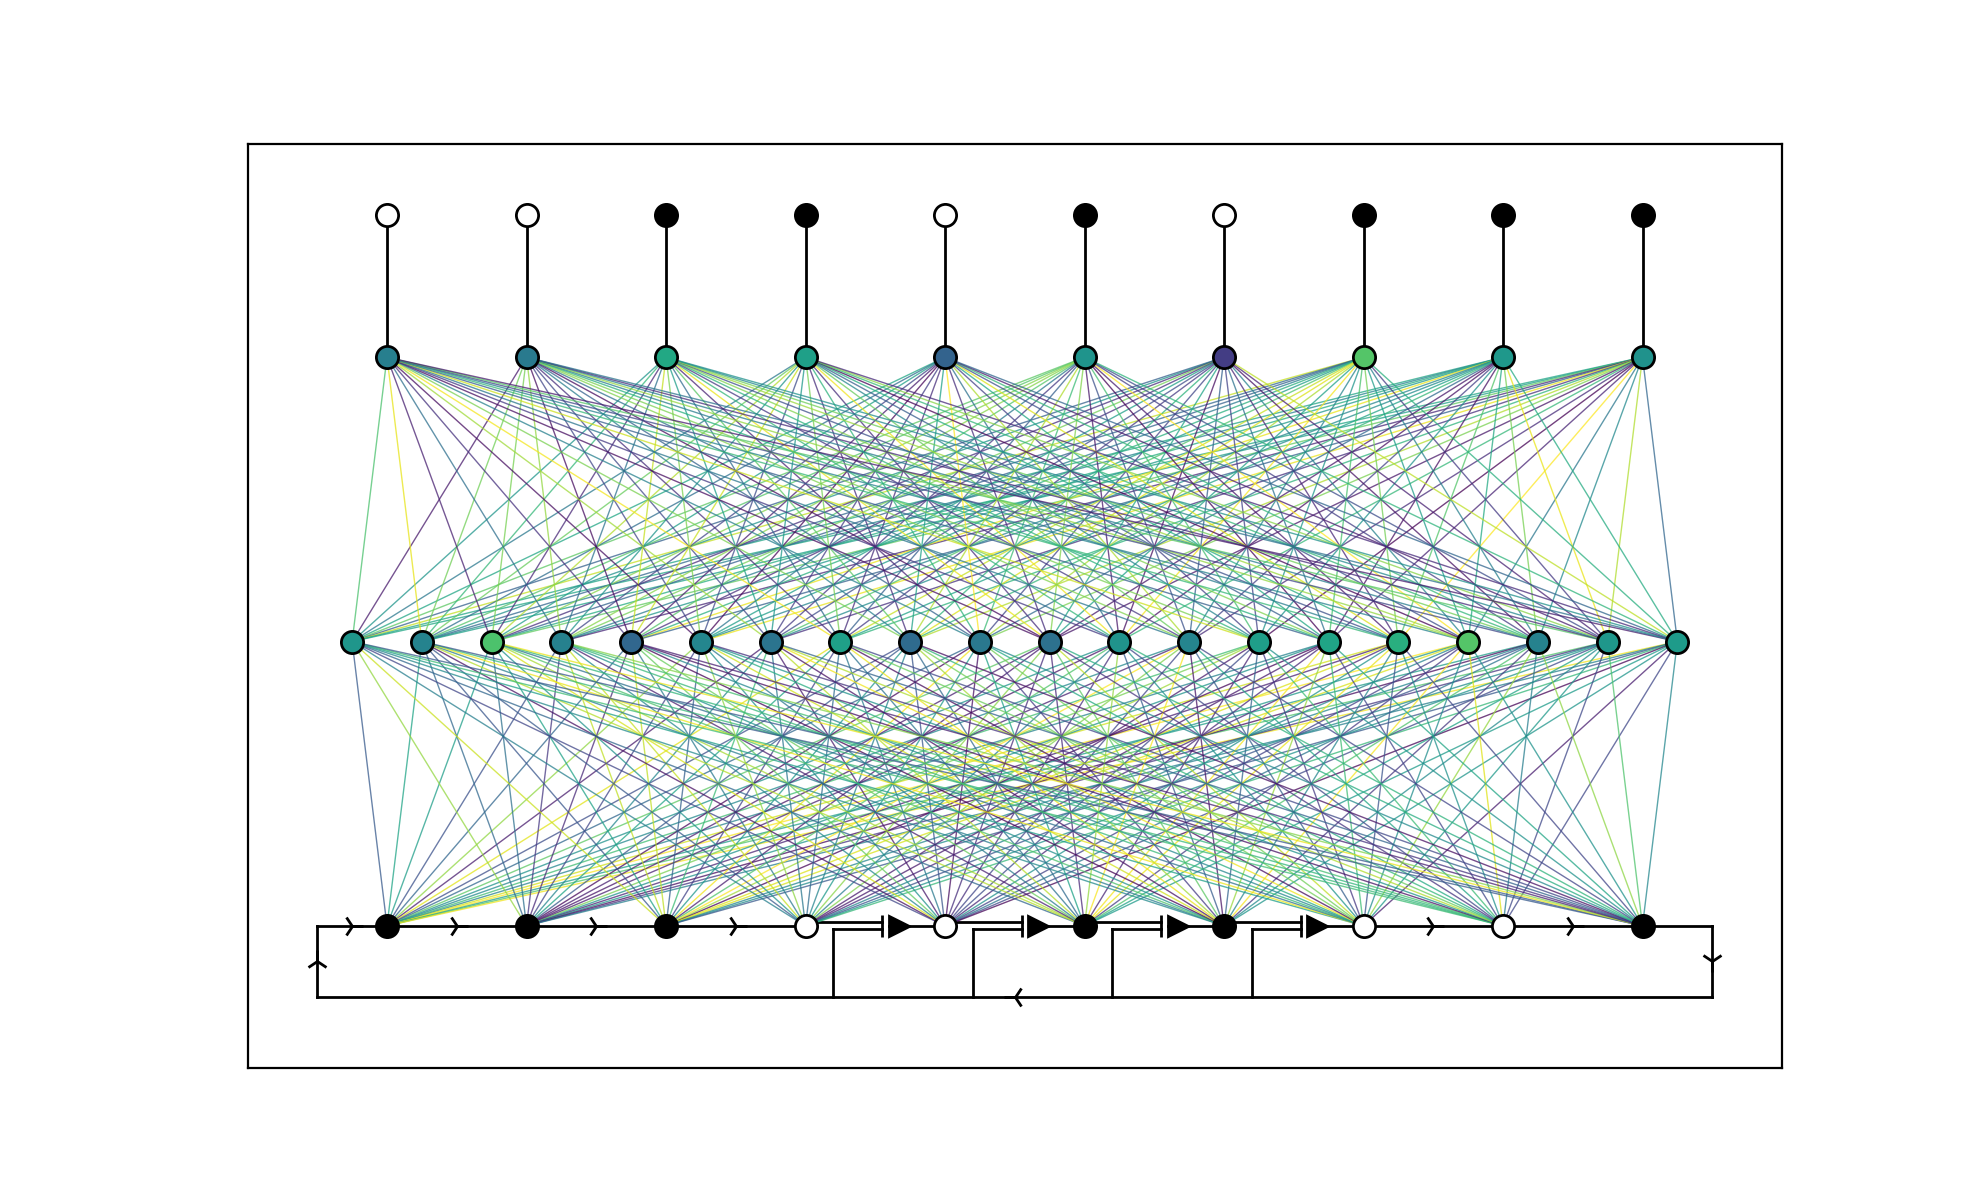

In [48]:
from numpy import max

config = {
    'figsize': (9.9, 6),
    'deg': deg,
    'x_mid': (deg - 1) / 2,
    'cmap': 'viridis',#'binary',
    'y_input': 0,
    'y_hidden': 0.4,
    'y_output': 0.8,
    'y_decision': 1,
    'y_LFSR_loop': -0.1,
    'y_lim': [-0.2, 1.1],
    'num_hidden': 2 * deg,
    'num_input': deg,
    'num_output': deg,
    'node_size': 8,
    'link_width': 1,
    'net_link_alpha': 0.75,
    'arrow_size': 8,
    'net_feedback_linestyle':'--'
}

#############################
# Set up shop in new figure #
#############################

# New figure
plt.figure(figsize=config['figsize'])

# Draw LFSR corrsponding to tap polynomial
draw_lfsr(taps=str2vec(hex2bin(
    coeff_catalog[p], config['deg'])), 
    deg=config['deg'], 
    x_midpt=config['x_mid'],
    y_register=config['y_input'],
    y_feedback=config['y_LFSR_loop'],
    arrow_size=config['arrow_size'],
    lw=config['link_width'])

# Initialize neural net drawing
init_network_diagram(model=model,
    config=config, seed_bits=X[0,:],
    h_activations=h_activations[0,:],
    y_activations=Y_hat[0,:])

###############
# Format axes #
###############

# Vertical axis span
plt.ylim(config['y_lim']);

# Remove all axis ticks
plt.xticks([]);
plt.yticks([]);